In [2]:
import os
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
 
from torchvision import datasets
from torchvision.utils import save_image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pickle
import numpy as np
import pandas as pd
from ast import literal_eval
import glob

from PIL import Image, ImageDraw
import time

import cv2

In [ ]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data[:,1]) != stepsize)[0]+1)

kpa=[]
keypoints=pickle.load(open("keypoints_openpifpaf.pickle","rb"))
kpd={}
for i in keypoints:
	kpd[i]=np.array(keypoints[i])
print(len(kpd))
kpa=[]
for key in list(kpd.keys()):
  x=key.replace(".png.predictions.json","").split("_")
  vid_num=int(x[2])
  frame_num=int(x[3])
  ped_num=x[4]
  if(len(ped_num)==11):
    ped_num=int(x[4][10])
  else:
    ped_num=0
    
#   if np.count_nonzero(kpd[key]<=0)<=9:
#       kpa.append([vid_num,frame_num,ped_num,kpd[key]])
  vec=kpd[key][2::3]
  if (vec > 0.25).all():
      kpa.append([vid_num,frame_num,ped_num,kpd[key]])


keypoints_array_sorted=sorted(kpa,key=lambda e:(e[0],e[2],e[1]))
print(len(keypoints_array_sorted))
thresarr=[]
for i in range(len(keypoints_array_sorted)):
  vec=keypoints_array_sorted[i][3][2::3]
  if (vec > 0.25).all():
      thresarr.append(keypoints_array_sorted[i][3])
keypoints=np.array(thresarr)
kp_train=np.delete(keypoints, list(range(2, keypoints.shape[1], 3)), axis=1)
print(kp_train.shape)

import itertools

key_f = lambda e: (e[0],e[2])
kp_seq=[]
for key, group in itertools.groupby(keypoints_array_sorted, key_f):
    lg=list(group)
    # print(len(lg))
    kp_seq.append(lg)

print(len(keypoints_array_sorted))
gps=[]
for seq in kp_seq:
  l=[]
  for i in range(len(seq)):
#     print(seq[i][3].shape)
    vec=seq[i][3][2::3]
    if (vec > 0.25).all():
      l.append(keypoints_array_sorted[i][3])
  gps.append(l)

gps = list(filter(None, gps))
print(len(gps))

print(len(kp_seq))
sequences=[]
seq_len=16
slide=4
c=0
for lst in kp_seq:
  c+=1
  ll=np.array(lst)
  x=[np.array(i) for i in consecutive(ll)]
  
  for tt in x:
    if(len(tt)>=seq_len):

      pp=[[tt[i:i + seq_len],tt[i+seq_len:i + 2*seq_len]] for i in range(0, len(tt)-(2*seq_len), slide)]
      sequences.extend(pp)

print(len(sequences))

array_of_seq=[]
tuples_to_save=[]
tups_x=[]
tups_y=[]
array_of_data=[]
for i in sequences:
  x=np.array([p[3] for p in i[0]])
  y=np.array([p[3] for p in i[1]])
  array_of_seq.append([x,y])
  tuples_to_save.extend([(p[0],p[1],p[2]) for p in i[0]])
  tuples_to_save.extend([(p[0],p[1],p[2]) for p in i[1]])
  array_of_data.append([x,y,np.array([(p[0],p[1],p[2]) for p in i[0]]),np.array([(p[0],p[1],p[2]) for p in i[1]])])
  
array_of_seq=np.array(array_of_seq)
print(array_of_seq.shape)

import random 
seq_out=array_of_seq
print(seq_out.shape)
sequences_all=[]
sequences_obs_speed=[]
sequences_true_speed=[]
sequences_obs_pose=[]
sequences_true_pose=[]
sequences_true_imgs=[]
sequences_obs_imgs=[]
seq_len=16
split=int(0.75*len(seq_out))
for p in range(len(seq_out)):
  outputs = []

  observed = array_of_data[p][0]
  future = array_of_data[p][1]
  obs = torch.tensor([observed[i] for i in range(0,seq_len,1)])
  true = torch.tensor([future[i] for i in range(0,seq_len,1)])
  sequences_obs_pose.append(np.round(obs.numpy(),2).tolist())
  sequences_true_pose.append(np.round(true.numpy(),2).tolist())
  sequences_true_imgs.append(['/frames/'+'video_'+str(i[0]).rjust(4, '0')+"/"+str(i[1]).rjust(5, '0')+'.png' for i in array_of_data[p][2]])
  sequences_obs_imgs.append(['/frames/'+'video_'+str(i[0]).rjust(4, '0')+"/"+str(i[1]).rjust(5, '0')+'.png' for i in array_of_data[p][3]])
c = list(zip(sequences_obs_pose, sequences_true_pose))#,sequences_true_imgs,sequences_obs_imgs))

random.shuffle(c)

sequences_obs_pose, sequences_true_pose = zip(*c) #, sequences_true_imgs, sequences_obs_imgs

sequences_all_train=sequences_all[:split]
sequences_all_val=sequences_all[split:]

sequences_all=np.array(sequences_all)

data = {'Pose': sequences_obs_pose,
        'Future_Pose': sequences_true_pose,
       }

data_val = {'Pose': sequences_obs_pose[split:],
        'Future_Pose': sequences_true_pose[split:],
           }
df_train = pd.DataFrame (data, columns = ['Pose','Future_Pose'])

df_train.to_csv("./sequences_openpifpaf_complete.csv",index=False)


print(df_train.head())

In [3]:
class myDataset(torch.utils.data.Dataset):
    def __init__(self, args, dtype,fname):
        
        self.args = args
        self.dtype = dtype
        print("Loading",self.dtype)
        sequence_centric = pd.read_csv(fname+self.dtype+".csv")
        df = sequence_centric.copy()      
        for v in list(df.columns.values):
            print(v+' loaded')
            try:
                df.loc[:,v] = df.loc[:, v].apply(lambda x: literal_eval(x))
            except:
                continue
        sequence_centric[df.columns] = df[df.columns]
        self.data = sequence_centric.copy().reset_index(drop=True)
    
        print('*'*30)
        

    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index):

        seq = self.data.iloc[index]
        outputs = []

        obs = torch.tensor([seq.Pose[i] for i in range(0,self.args.input,self.args.skip)])
        obs_speed = (obs[1:] - obs[:-1])
        outputs.append(obs_speed)
        true = torch.tensor([seq.Future_Pose[i] for i in range(0,self.args.output,self.args.skip)])
        true_speed = torch.cat(((true[0]-obs[-1]).unsqueeze(0), true[1:]-true[:-1]))
        outputs.append(true_speed)
        outputs.append(obs)
        outputs.append(true)
        
        return tuple(outputs)    
    
    
def data_loader(args,data,fname):
    dataset = myDataset(args,data,fname)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=args.batch_size, shuffle=args.loader_shuffle,
        pin_memory=args.pin_memory)

    return dataloader

class PoseDataset(Dataset):

    def __init__(self,keypoints, transform=None):
        self.data=keypoints
      
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.data[idx]

        sample = {'keypoints': torch.from_numpy(image)}

        return sample


In [3]:
def ADE_c(pred, true):
    b,n,p=pred.size()[0],pred.size()[1],pred.size()[2]
#     print(b,n,p)
    pred = torch.reshape(pred, (b,n,int(p/2),2))
    true = torch.reshape(true, (b,n,int(p/2),2))
    
    displacement=torch.sqrt((pred[:,:,:,0]-true[:,:,:,0])**2+(pred[:,:,:,1]-true[:,:,:,1])**2)
    ade = torch.mean(torch.mean(displacement,dim=1))

    return ade


def FDE_c(pred, true):
    b,n,p=pred.size()[0],pred.size()[1],pred.size()[2]
#     print(b,n,p)
    pred = torch.reshape(pred, (b,n,int(p/2),2))
    true = torch.reshape(true, (b,n,int(p/2),2))
    
    displacement=torch.sqrt((pred[:,-1,:,0]-true[:,-1,:,0])**2+(pred[:,-1,:,1]-true[:,-1,:,1])**2)

    fde = torch.mean(torch.mean(displacement,dim=1))
    
    return fde

def speed2pos(preds, obs_p):
    pred_pos = torch.zeros(preds.shape[0], preds.shape[1], preds.shape[2]).to('cuda')
    current = obs_p[:,-1,:]
    
    for i in range(preds.shape[1]):
        pred_pos[:,i,:] = current + preds[:,i,:]
        current = pred_pos[:,i,:]
        
    for i in range(preds.shape[2]):
        pred_pos[:,:,i] = torch.min(pred_pos[:,:,i], 1920*torch.ones(pred_pos.shape[0], pred_pos.shape[1], device='cuda'))
        pred_pos[:,:,i] = torch.max(pred_pos[:,:,i], torch.zeros(pred_pos.shape[0], pred_pos.shape[1], device='cuda'))
        
    return pred_pos

In [118]:
def ADE_3d(pred, true):
    b,n,p=pred.size()[0],pred.size()[1],pred.size()[2]
#     print(b,n,p)
    pred = torch.reshape(pred, (b,n,int(p/3),3))
    true = torch.reshape(true, (b,n,int(p/3),3))
    
    displacement=torch.sqrt((pred[:,:,:,0]-true[:,:,:,0])**2+(pred[:,:,:,1]-true[:,:,:,1])**2)
    ade = torch.mean(torch.mean(displacement,dim=1))

    return ade


def FDE_3d(pred, true):
    b,n,p=pred.size()[0],pred.size()[1],pred.size()[2]
#     print(b,n,p)
    pred = torch.reshape(pred, (b,n,int(p/3),3))
    true = torch.reshape(true, (b,n,int(p/3),3))
    
    displacement=torch.sqrt((pred[:,-1,:,0]-true[:,-1,:,0])**2+(pred[:,-1,:,1]-true[:,-1,:,1])**2)

    fde = torch.mean(torch.mean(displacement,dim=1))
    
    return fde

def speed2pos3d(preds, obs_p):
    pred_pos = torch.zeros(preds.shape[0], preds.shape[1], preds.shape[2]).to('cuda')
    current = obs_p[:,-1,:]
    
    for i in range(preds.shape[1]):
        pred_pos[:,i,:] = current + preds[:,i,:]
        current = pred_pos[:,i,:]
        
#     for i in range(preds.shape[2]):
#         pred_pos[:,:,i] = torch.min(pred_pos[:,:,i], 1920*torch.ones(pred_pos.shape[0], pred_pos.shape[1], device='cuda'))
#         pred_pos[:,:,i] = torch.max(pred_pos[:,:,i], torch.zeros(pred_pos.shape[0], pred_pos.shape[1], device='cuda'))
        
    return pred_pos

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.drop =  nn.Dropout(p=0.3)
        self.enc1= nn.Linear(in_features=34*16, out_features=300)
        self.enc2 = nn.Linear(in_features=300, out_features=300)
#         self.enc3 = nn.Linear(in_features=150, out_features=75)
#         self.enc4 = nn.Linear(in_features=300, out_features=10)
        # decoder 
#         self.dec1 = nn.Linear(in_features=10, out_features=300)
#         self.dec2 = nn.Linear(in_features=75, out_features=150)
#         self.dec3 = nn.Linear(in_features=300, out_features=300)
        self.dec4 = nn.Linear(in_features=300, out_features=34*16)
        
    def forward(self, x):
        x = F.relu(self.drop(x))
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.dec1(x))
        return x
net = Autoencoder()
print(net)

Autoencoder(
  (drop): Dropout(p=0.3, inplace=False)
  (enc1): Linear(in_features=544, out_features=300, bias=True)
  (enc2): Linear(in_features=300, out_features=300, bias=True)
  (dec4): Linear(in_features=300, out_features=544, bias=True)
)


In [ ]:
def train(net, trainloader,valloader, NUM_EPOCHS, scheduler):
    train_loss = []
    val_losses = []
    max_val_loss=10000
    for epoch in range(NUM_EPOCHS):
        counter=0
        ade_train=0
        ade_val=0
        
        net.train()
        running_loss = 0.0
        running_val_loss = 0.0
        for data in trainloader:
            counter+=1
            kp = data['keypoints']
            kp = kp.to(device)
            
            optimizer.zero_grad()
            outputs = net(kp.float())
            
            loss = criterion(outputs, kp.float())
            
            ade_train += float(ADE_c(outputs.unsqueeze(0), kp.unsqueeze(0)))
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        
        ade_train/=counter
        
        net.eval()
        counter=0
        with torch.no_grad():
          for data in valloader:
              counter+=1
              kp = data['keypoints']
              kp = kp.to(device)
              outputs = net(kp.float())
              
              ade_val += float(ADE_c(outputs.unsqueeze(0), kp.unsqueeze(0)))
              
              val_loss = criterion(outputs, kp.float())
              running_val_loss += val_loss.item()
          
        val_loss = running_val_loss / len(valloader)
        val_losses.append(val_loss)
        ade_val/=counter
         
        scheduler.step(val_loss) 

        print('Epoch {} of {}, Train Loss: {:.3f}, Val Loss: {:.3f}, ADE_train : {:.3f},  ADE_val: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss, val_loss,ade_train, ade_val))
              
        if val_loss<max_val_loss:
          max_val_loss=val_loss
          torch.save(net.state_dict(), "model_clean_auto.weight")

    return train_loss,val_losses

        

In [258]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
import torchvision.transforms as transforms


class LSTM_vel(nn.Module):
    def __init__(self, args):

        super(LSTM_vel, self).__init__()
         
        self.pose_encoder = nn.LSTM(input_size=34, hidden_size=args.hidden_size)
        self.vel_encoder = nn.LSTM(input_size=34, hidden_size=args.hidden_size)
        
        self.pose_embedding = nn.Sequential(nn.Linear(in_features=args.hidden_size, out_features=34),
                                           nn.ReLU())
        
        self.vel_decoder = nn.LSTMCell(input_size=34, hidden_size=args.hidden_size)
   
        self.fc_vel    = nn.Linear(in_features=args.hidden_size, out_features=34)
        
        self.hardtanh = nn.Hardtanh(min_val=-1*args.hardtanh_limit,max_val=args.hardtanh_limit)
        self.relu = nn.LeakyReLU() 
        self.softmax = nn.Softmax(dim=1)
        
        self.args = args
        
    def forward(self, pose=None, vel=None):


        _, (hidden_vel, cell_vel) = self.vel_encoder(vel.permute(1,0,2))
        hidden_vel = hidden_vel.squeeze(0)
        cell_vel = cell_vel.squeeze(0)


        _, (hidden_pose, cell_pose) = self.pose_encoder(pose.permute(1,0,2))
        hidden_pose = hidden_pose.squeeze(0)
        cell_pose = cell_pose.squeeze(0)
        
        outputs = []
        
        vel_outputs    = torch.tensor([], device=self.args.device)
        
        VelDec_inp = vel[:,-15,:]
        
        hidden_dec = hidden_pose + hidden_vel
        cell_dec = cell_pose + cell_vel
        for i in range(self.args.output//self.args.skip):
            hidden_dec, cell_dec = self.vel_decoder(VelDec_inp, (hidden_dec, cell_dec))
            vel_output  = self.hardtanh(self.fc_vel(hidden_dec))
            vel_outputs = torch.cat((vel_outputs, vel_output.unsqueeze(1)), dim = 1)
            VelDec_inp  = vel_output#.detach()
        
            
        outputs.append(vel_outputs)    
        return tuple(outputs)



In [246]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import utils

class args():
    def __init__(self):
        self.jaad_dataset = '/data/smailait-data/JAAD/processed_annotations' #folder containing parsed jaad annotations (used when first time loading data)
        self.dtype        = 'train'
        self.from_file    = False #read dataset from csv file or reprocess data
        self.save         = True
        self.file         = '/data/smailait-data/jaad_train_16_16.csv'
        self.save_path    = '/data/smailait-data/jaad_train_16_16.csv'
        self.model_path    = '/data/smailait-data/models/multitask_pv_lstm_trained.pkl'
        self.loader_workers = 1
        self.loader_shuffle = False
        self.pin_memory     = False
        self.image_resize   = [240, 426]
        self.device         = 'cuda'
        self.batch_size     = 50
        self.n_epochs       = 1000
        self.hidden_size    = 1000
        self.hardtanh_limit = 100
        self.input  = 16
        self.output = 14
        self.stride = 16
        self.skip   = 1
        # self.task   = 'bounding_box-intention'
        self.task   = 'pose'
        self.use_scenes = False       
        self.lr = 0.01
        
args = args()
net = LSTM_vel(args).to(args.device)

optimizer = optim.Adam(net.parameters(), lr=args.lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=15, 
                                                 threshold = 1e-8, verbose=True)
mse = nn.MSELoss()

l1e = nn.L1Loss()
bce = nn.BCELoss()
train_s_scores = []
train_pose_scores=[]
val_pose_scores=[]
train_c_scores = []
val_s_scores   = []
val_c_scores   = []

train_loader=data_loader(args,"train",'posetrack_')
val_loader=data_loader(args,"valid" ,'posetrack_')


Loading train
Pose loaded
Future_Pose loaded
Mask loaded
Future_Mask loaded
******************************
Loading valid
Pose loaded
Future_Pose loaded
Mask loaded
Future_Mask loaded
******************************


In [259]:
optimizer = optim.Adam(net.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, 
                                                 threshold = 1e-8, verbose=True)
print('='*100)
print('Training ...')

for epoch in range(args.n_epochs):
    start = time.time()
    
    avg_epoch_train_s_loss = 0
    avg_epoch_val_s_loss   = 0
    avg_epoch_train_p_loss   = 0
    avg_epoch_val_p_loss     = 0 
    ade  = 0
    fde  = 0
    ade_train  = 0
    fde_train  = 0
    counter = 0
    
    for idx, (obs_s, target_s, obs_pose, target_pose) in enumerate(train_loader):
        counter += 1        
        
        obs_s    = obs_s.to(device='cuda')
        target_s = target_s.to(device='cuda')
        obs_pose    = obs_pose.to(device='cuda')
        target_pose = target_pose.to(device='cuda')
 
        net.zero_grad()
    
        (speed_preds,) = net(pose=obs_pose, vel=obs_s)

        speed_loss  = l1e(speed_preds, target_s)
    
        preds_p = speed2pos(speed_preds, obs_pose) 
        ade_train += float(ADE_c(preds_p, target_pose))
        fde_train += float(FDE_c(preds_p, target_pose))
        
    
        speed_loss.backward()

        optimizer.step()
        
    
        avg_epoch_train_s_loss += float(speed_loss)

    avg_epoch_train_s_loss /= counter
    train_s_scores.append(avg_epoch_train_s_loss)
    ade_train  /= counter
    fde_train  /= counter    

    counter=0

    for idx, (obs_s, target_s, obs_pose, target_pose) in enumerate(val_loader):
        counter+=1
        obs_s    = obs_s.to(device='cuda')
        target_s = target_s.to(device='cuda')
        obs_pose    = obs_pose.to(device='cuda')
        target_pose = target_pose.to(device='cuda')
        
        with torch.no_grad():
            (speed_preds,) = net(pose=obs_pose,vel=obs_s)

            speed_loss  = l1e(speed_preds, target_s)
            avg_epoch_val_s_loss += float(speed_loss)
        
            preds_p = speed2pos(speed_preds, obs_pose)
            ade += float(ADE_c(preds_p, target_pose))
            fde += float(FDE_c(preds_p, target_pose))

        
    avg_epoch_val_s_loss /= counter
    val_s_scores.append(avg_epoch_val_s_loss)
    
    ade  /= counter
    fde  /= counter     
   
    scheduler.step(avg_epoch_val_s_loss)
    
     
    print('e:', epoch, '| ts: %.2f'% avg_epoch_train_s_loss,  '| vs: %.2f'% avg_epoch_val_s_loss, '| ade_train: %.2f'% ade_train, '| ade_val: %.2f'% ade, '| fde_train: %.2f'% fde_train,'| fde_val: %.2f'% fde,
          '| t:%.2f'%(time.time()-start))


print('='*100) 
# print('Saving ...')
# torch.save(net.state_dict(), args.model_path)
print('Done !')

Training ...


ValueError: too many values to unpack (expected 4)

In [ ]:
class LSTM_spat(nn.Module):
    def __init__(self, args):
        '''
           input: observed body poses and velocites 
           output: predicted poses(not trained), velocities of poses, and intentions
        '''
        super(LSTM_spat, self).__init__()
#         self.encoded_tot=16*20
        self.encoded_size=100
         
        self.pose_encoder = nn.LSTM(input_size=self.encoded_size, hidden_size=args.hidden_size)        
        self.pose_embedding = nn.Sequential(nn.Linear(in_features=args.hidden_size, out_features=self.encoded_size),
                                           nn.ReLU())
        
        self.pose_decoder = nn.LSTMCell(input_size=self.encoded_size, hidden_size=args.hidden_size)
        self.fc_pose   = nn.Linear(in_features=args.hidden_size, out_features=self.encoded_size)
        
        self.hardtanh = nn.Hardtanh(min_val=-1*args.hardtanh_limit,max_val=args.hardtanh_limit)
        self.relu = nn.ReLU() 
        self.softmax = nn.Softmax(dim=1)
        
        self.enc1= nn.Linear(in_features=28, out_features=140)
        self.enc2 = nn.Linear(in_features=140, out_features=self.encoded_size)
        self.dec = nn.Linear(in_features=self.encoded_size, out_features=28)
        
#         self.drop=n
        
#         self.encoder = lstm_encoder(input_size = 34, hidden_size = 1000, num_layers = 3)
#         self.decoder = lstm_decoder(input_size = 34, hidden_size = 1000, num_layers = 3)

#         self.teacher_forcing_ratio = 0.6
        
        self.args = args
        
    def forward(self, pose=None, vel=None, target_pose=None):
        
        poses=pose.permute(1,0,2)

        pose_encoded = torch.tensor([], device=self.args.device)
        pose_recs = torch.tensor([], device=self.args.device)
        
        for i in range(pose.size()[0]):
            x = self.relu(self.enc1(pose[i]))
            x = self.relu(self.enc2(x))
            recreated_pose=self.dec(x)
            pose_encoded = torch.cat((pose_encoded, x.unsqueeze(1)), dim = 1)
            pose_recs = torch.cat((pose_recs, recreated_pose.unsqueeze(1)), dim = 1)
        
        
        
        _, (hidden_pose, cell_pose) = self.pose_encoder(pose_encoded)
        hidden_pose = hidden_pose.squeeze(0)
        cell_pose = cell_pose.squeeze(0)
        
        outputs = []
        pose_outputs   = torch.tensor([], device=self.args.device)
        PoseDec_inp = pose_encoded.permute(1,0,2)[:,-1,:]
        
#         print(PoseDec_inp.shape)
        hidden_dec=hidden_pose
        cell_dec=cell_pose
#         print(hidden_dec.shape)
        for i in range(self.args.output//self.args.skip):
        
            hidden_dec, cell_dec = self.pose_decoder(PoseDec_inp, (hidden_dec, cell_dec))
            pose_output_encoded  = self.fc_pose(hidden_dec)
            
            pose_output= self.dec(pose_output_encoded)
            pose_outputs = torch.cat((pose_outputs, pose_output.unsqueeze(1)), dim = 1)
            PoseDec_inp  = pose_output_encoded.detach()
            
        
        pose_recs= pose_recs.permute(1,0,2)
        
#         print(recreated_pose.shape)
#         print(pose_outputs.shape)
#         print(pose_outputs.shape,pose_recs.shape)
        outputs.append(pose_outputs)
        outputs.append(pose_recs)

            
        return tuple(outputs)

net = LSTM_spat(args).to(args.device)

In [36]:

optimizer = optim.Adam(net.parameters(), lr= 0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=8, 
                                                 threshold = 1e-12, verbose=True)
print('='*100)
print('Training ...')

train_p_scores=[]
val_p_scores=[]

for epoch in range(300):
    start = time.time()
    
    avg_epoch_train_p_loss   = 0
    avg_epoch_val_p_loss     = 0 
    ade  = 0
    fde  = 0
    ade_train  = 0
    fde_train  = 0
    counter = 0
    net.train()
    for idx, (obs_s, target_s, obs_pose, target_pose) in enumerate(train_loader):
        counter += 1        
        
        
        obs_pose    = obs_pose.to(device='cuda')
        target_pose = target_pose.to(device='cuda')
        
        obs_s    = obs_s.to(device='cuda')
        target_s = target_s.to(device='cuda')
 
        net.zero_grad()
    
        (pose_preds,pose_recs) = net(pose=obs_pose, target_pose=target_pose,vel=obs_s)

        loss  = l1e(pose_preds, target_pose)+l1e(pose_recs, obs_pose)
    
        ade_train += float(ADE_c(pose_preds, target_pose))
        fde_train += float(FDE_c(pose_preds, target_pose))
        
    
        loss.backward()
        optimizer.step()
        
    
        avg_epoch_train_p_loss += float(loss)

    avg_epoch_train_p_loss /= counter
    train_p_scores.append(avg_epoch_train_p_loss)
    ade_train  /= counter
    fde_train  /= counter   
    
    
  
    counter=0
    net.eval()
    for idx, (obs_s, target_s, obs_pose, target_pose) in enumerate(val_loader):
        counter+=1
       
        obs_pose    = obs_pose.to(device='cuda')
        target_pose = target_pose.to(device='cuda')
        
        with torch.no_grad():
            (pose_preds,pose_recs) = net(pose=obs_pose, target_pose=target_pose)
          
            val_loss  = l1e(pose_preds, target_pose)+l1e(pose_recs, obs_pose)
            avg_epoch_val_p_loss += float(val_loss)
            
            ade += float(ADE_c(pose_preds, target_pose))
            fde += float(FDE_c(pose_preds, target_pose))

        
    avg_epoch_val_p_loss /= counter
    val_p_scores.append(avg_epoch_val_p_loss)
    
    ade  /= counter
    fde  /= counter     
   
    
    
    scheduler.step(avg_epoch_train_p_loss)
    
    print('e:', epoch,'| loss: %.2f'%avg_epoch_train_p_loss,'| val_loss: %.2f'% avg_epoch_val_p_loss, '| tpose: %.2f'% avg_epoch_train_p_loss, '| vpose: %.2f'% avg_epoch_val_p_loss, '| ade_train: %.2f'% ade_train, '| ade_val: %.2f'% ade, '| fde_train: %.2f'% fde_train,'| fde_val: %.2f'% fde,
          '| t:%.2f'%(time.time()-start))


print('='*100) 
# print('Saving ...')
# torch.save(net.state_dict(), args.model_path)
print('Done !')

Training ...
e: 0 | loss: 520.96 | val_loss: 383.01 | tpose: 520.96 | vpose: 383.01 | ade_train: 564.47 | ade_val: 455.13 | fde_train: 545.84 | fde_val: 444.31 | t:2.52
e: 1 | loss: 347.15 | val_loss: 319.54 | tpose: 347.15 | vpose: 319.54 | ade_train: 399.76 | ade_val: 363.25 | fde_train: 399.65 | fde_val: 368.64 | t:2.43
e: 2 | loss: 314.88 | val_loss: 308.35 | tpose: 314.88 | vpose: 308.35 | ade_train: 350.65 | ade_val: 341.83 | fde_train: 353.91 | fde_val: 352.51 | t:2.43
e: 3 | loss: 314.76 | val_loss: 319.63 | tpose: 314.76 | vpose: 319.63 | ade_train: 346.95 | ade_val: 345.92 | fde_train: 353.69 | fde_val: 355.69 | t:2.48
e: 4 | loss: 314.22 | val_loss: 305.05 | tpose: 314.22 | vpose: 305.05 | ade_train: 351.99 | ade_val: 342.21 | fde_train: 355.92 | fde_val: 353.37 | t:2.46
e: 5 | loss: 307.80 | val_loss: 343.11 | tpose: 307.80 | vpose: 343.11 | ade_train: 344.45 | ade_val: 338.62 | fde_train: 350.49 | fde_val: 348.19 | t:2.44
e: 6 | loss: 313.67 | val_loss: 293.33 | tpose: 313

e: 51 | loss: 270.99 | val_loss: 256.04 | tpose: 270.99 | vpose: 256.04 | ade_train: 323.28 | ade_val: 306.07 | fde_train: 332.02 | fde_val: 322.17 | t:2.48
e: 52 | loss: 256.56 | val_loss: 255.88 | tpose: 256.56 | vpose: 255.88 | ade_train: 315.14 | ade_val: 320.20 | fde_train: 323.90 | fde_val: 331.23 | t:2.43
e: 53 | loss: 249.66 | val_loss: 252.35 | tpose: 249.66 | vpose: 252.35 | ade_train: 313.89 | ade_val: 319.34 | fde_train: 322.00 | fde_val: 334.84 | t:2.42
e: 54 | loss: 248.06 | val_loss: 253.37 | tpose: 248.06 | vpose: 253.37 | ade_train: 313.40 | ade_val: 321.73 | fde_train: 321.09 | fde_val: 340.37 | t:2.42
e: 55 | loss: 248.57 | val_loss: 244.03 | tpose: 248.57 | vpose: 244.03 | ade_train: 313.96 | ade_val: 310.77 | fde_train: 323.98 | fde_val: 326.70 | t:2.44
e: 56 | loss: 244.55 | val_loss: 248.53 | tpose: 244.55 | vpose: 248.53 | ade_train: 311.52 | ade_val: 318.46 | fde_train: 320.09 | fde_val: 336.56 | t:2.44
e: 57 | loss: 241.97 | val_loss: 237.45 | tpose: 241.97 | 

Epoch   104: reducing learning rate of group 0 to 6.2500e-04.
e: 103 | loss: 234.40 | val_loss: 238.44 | tpose: 234.40 | vpose: 238.44 | ade_train: 312.12 | ade_val: 317.15 | fde_train: 322.99 | fde_val: 329.06 | t:2.46
e: 104 | loss: 241.27 | val_loss: 234.01 | tpose: 241.27 | vpose: 234.01 | ade_train: 319.84 | ade_val: 313.66 | fde_train: 329.92 | fde_val: 329.12 | t:2.41
e: 105 | loss: 232.70 | val_loss: 235.02 | tpose: 232.70 | vpose: 235.02 | ade_train: 310.95 | ade_val: 314.73 | fde_train: 320.50 | fde_val: 335.27 | t:2.42
e: 106 | loss: 228.92 | val_loss: 229.15 | tpose: 228.92 | vpose: 229.15 | ade_train: 305.27 | ade_val: 305.64 | fde_train: 315.97 | fde_val: 324.10 | t:2.43
e: 107 | loss: 229.14 | val_loss: 240.91 | tpose: 229.14 | vpose: 240.91 | ade_train: 305.08 | ade_val: 322.84 | fde_train: 315.59 | fde_val: 336.07 | t:2.43
e: 108 | loss: 231.27 | val_loss: 232.71 | tpose: 231.27 | vpose: 232.71 | ade_train: 309.04 | ade_val: 312.15 | fde_train: 319.17 | fde_val: 329.22

e: 154 | loss: 221.00 | val_loss: 225.80 | tpose: 221.00 | vpose: 225.80 | ade_train: 299.91 | ade_val: 306.07 | fde_train: 311.39 | fde_val: 323.83 | t:2.47
e: 155 | loss: 220.48 | val_loss: 237.77 | tpose: 220.48 | vpose: 237.77 | ade_train: 299.21 | ade_val: 323.59 | fde_train: 310.77 | fde_val: 345.43 | t:2.56
e: 156 | loss: 221.33 | val_loss: 224.77 | tpose: 221.33 | vpose: 224.77 | ade_train: 300.07 | ade_val: 306.94 | fde_train: 311.59 | fde_val: 324.88 | t:2.61
e: 157 | loss: 221.17 | val_loss: 231.61 | tpose: 221.17 | vpose: 231.61 | ade_train: 300.16 | ade_val: 314.58 | fde_train: 311.87 | fde_val: 330.83 | t:2.56
e: 158 | loss: 220.07 | val_loss: 224.72 | tpose: 220.07 | vpose: 224.72 | ade_train: 298.57 | ade_val: 303.31 | fde_train: 310.19 | fde_val: 319.88 | t:2.46
e: 159 | loss: 220.71 | val_loss: 223.97 | tpose: 220.71 | vpose: 223.97 | ade_train: 299.64 | ade_val: 304.18 | fde_train: 311.44 | fde_val: 323.85 | t:2.49
e: 160 | loss: 219.99 | val_loss: 221.96 | tpose: 21

e: 206 | loss: 217.05 | val_loss: 224.69 | tpose: 217.05 | vpose: 224.69 | ade_train: 295.86 | ade_val: 307.05 | fde_train: 307.57 | fde_val: 327.07 | t:2.67
e: 207 | loss: 216.64 | val_loss: 224.13 | tpose: 216.64 | vpose: 224.13 | ade_train: 295.31 | ade_val: 304.02 | fde_train: 307.15 | fde_val: 327.52 | t:2.66
e: 208 | loss: 216.73 | val_loss: 222.14 | tpose: 216.73 | vpose: 222.14 | ade_train: 295.38 | ade_val: 302.78 | fde_train: 307.37 | fde_val: 321.95 | t:2.58
e: 209 | loss: 216.64 | val_loss: 230.28 | tpose: 216.64 | vpose: 230.28 | ade_train: 295.40 | ade_val: 314.27 | fde_train: 307.43 | fde_val: 331.98 | t:2.65
e: 210 | loss: 216.24 | val_loss: 220.27 | tpose: 216.24 | vpose: 220.27 | ade_train: 294.82 | ade_val: 301.14 | fde_train: 307.41 | fde_val: 320.13 | t:2.57
e: 211 | loss: 216.55 | val_loss: 223.17 | tpose: 216.55 | vpose: 223.17 | ade_train: 295.22 | ade_val: 304.00 | fde_train: 307.92 | fde_val: 322.31 | t:2.71
e: 212 | loss: 216.44 | val_loss: 221.50 | tpose: 21

e: 258 | loss: 215.04 | val_loss: 228.06 | tpose: 215.04 | vpose: 228.06 | ade_train: 293.59 | ade_val: 312.95 | fde_train: 305.89 | fde_val: 331.02 | t:2.87
e: 259 | loss: 214.97 | val_loss: 223.74 | tpose: 214.97 | vpose: 223.74 | ade_train: 293.44 | ade_val: 303.78 | fde_train: 305.55 | fde_val: 321.40 | t:2.77
e: 260 | loss: 214.77 | val_loss: 221.07 | tpose: 214.77 | vpose: 221.07 | ade_train: 293.22 | ade_val: 301.51 | fde_train: 305.32 | fde_val: 320.89 | t:3.18
e: 261 | loss: 214.94 | val_loss: 215.98 | tpose: 214.94 | vpose: 215.98 | ade_train: 293.47 | ade_val: 294.87 | fde_train: 305.54 | fde_val: 312.73 | t:4.62
e: 262 | loss: 215.01 | val_loss: 228.84 | tpose: 215.01 | vpose: 228.84 | ade_train: 293.51 | ade_val: 314.49 | fde_train: 305.73 | fde_val: 337.47 | t:3.75
Epoch   264: reducing learning rate of group 0 to 9.7656e-06.
e: 263 | loss: 214.86 | val_loss: 221.70 | tpose: 214.86 | vpose: 221.70 | ade_train: 293.32 | ade_val: 303.13 | fde_train: 305.49 | fde_val: 320.29

In [ ]:
import numpy as np

def VIM(GT, pred, dataset_name, mask):
    """
    Visibilty Ignored Metric
    Inputs:
        GT: Ground truth data - array of shape (pred_len, #joint*(2D/3D))
        pred: Prediction data - array of shape (pred_len, #joint*(2D/3D))
        dataset_name: Dataset name
        mask: Visibility mask of pos - array of shape (pred_len, #joint)
    Output:
        errorPose:
    """

    gt_i_global = np.copy(GT)

    if dataset_name == "posetrack":
        mask = np.repeat(mask, 2, axis=-1)
        errorPose = np.power(gt_i_global - pred, 2) * mask
        #get sum on joints and remove the effect of missing joints by averaging on visible joints
        errorPose = np.sqrt(np.divide(np.sum(errorPose, 1), np.sum(mask,axis=1)))
        where_are_NaNs = np.isnan(errorPose)
        errorPose[where_are_NaNs] = 0
    else:   #3dpw
        errorPose = np.power(gt_i_global - pred, 2)
        errorPose = np.sum(errorPose, 1)
        errorPose = np.sqrt(errorPose)
    return errorPose


def VAM(GT, pred, occ_cutoff, pred_visib):
    """
    Visibility Aware Metric
    Inputs:
        GT: Ground truth data - array of shape (pred_len, #joint*(2D/3D))
        pred: Prediction data - array of shape (pred_len, #joint*(2D/3D))
        occ_cutoff: Maximum error penalty
        pred_visib: Predicted visibilities of pose, array of shape (pred_len, #joint)
    Output:
        seq_err:
    """
    pred_visib = np.repeat(pred_visib, 2, axis=-1)
    # F = 0
    seq_err = []
    if type(GT) is list:
        GT = np.array(GT)
    GT_mask = np.where(abs(GT) < 0.5, 0, 1)

    for frame in range(GT.shape[0]):
        f_err = 0
        N = 0
        for j in range(0, GT.shape[1], 2):
            if GT_mask[frame][j] == 0:
                if pred_visib[frame][j] == 0:
                    dist = 0
                elif pred_visib[frame][j] == 1:
                    dist = occ_cutoff
                    N += 1
            elif GT_mask[frame][j] > 0:
                N += 1
                if pred_visib[frame][j] == 0:
                    dist = occ_cutoff
                elif pred_visib[frame][j] == 1:
                    d = np.power(GT[frame][j:j + 2] - pred[frame][j:j + 2], 2)
                    d = np.sum(np.sqrt(d))
                    dist = min(occ_cutoff, d)
            f_err += dist
        
        if N > 0:
            seq_err.append(f_err / N)
        else:
            seq_err.append(f_err)
        # if f_err > 0:
        # F += 1
    return np.array(seq_err)

In [248]:
class myDataset_posetrack(torch.utils.data.Dataset):
    def __init__(self, args, dtype,fname):
        
        self.args = args
        self.dtype = dtype
        self.fname=fname
        print("Loading",self.dtype)
        sequence_centric = pd.read_csv(self.fname+self.dtype+".csv")
        df = sequence_centric.copy()      
        for v in list(df.columns.values):
            print(v+' loaded')
            try:
                df.loc[:,v] = df.loc[:, v].apply(lambda x: literal_eval(x))
            except:
                continue
        sequence_centric[df.columns] = df[df.columns]
        self.data = sequence_centric.copy().reset_index(drop=True)
    
        print('*'*30)
        

    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index):

        seq = self.data.iloc[index]
        outputs = []

        obs = torch.tensor([seq.Pose[i] for i in range(0,self.args.input,self.args.skip)])
        obs_speed = (obs[1:] - obs[:-1])
        outputs.append(obs_speed)
        true = torch.tensor([seq.Future_Pose[i] for i in range(0,self.args.output,self.args.skip)])
        true_speed = torch.cat(((true[0]-obs[-1]).unsqueeze(0), true[1:]-true[:-1]))
        outputs.append(true_speed)
        outputs.append(obs)
        outputs.append(true)
        
        if self.fname=="posetrack_":
            obs_mask = torch.tensor([seq.Mask[i] for i in range(0,self.args.output,self.args.skip)])
            true_mask = torch.tensor([seq.Future_Mask[i] for i in range(0,self.args.output,self.args.skip)])

            outputs.append(obs_mask)
            outputs.append(true_mask)
        
        return tuple(outputs)    
    
    
def data_loader_posetrack(args,data,fname):
    dataset = myDataset_posetrack(args,data,fname)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=args.batch_size, shuffle=args.loader_shuffle,
        pin_memory=args.pin_memory)

    return dataloader

train_loader=data_loader_posetrack(args,"train",'posetrack_')
val_loader=data_loader_posetrack(args,"valid" ,'posetrack_')

Loading train
Pose loaded
Future_Pose loaded
Mask loaded
Future_Mask loaded
******************************
Loading valid
Pose loaded
Future_Pose loaded
Mask loaded
Future_Mask loaded
******************************


In [272]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
import torchvision.transforms as transforms


class LSTM_posetrack(nn.Module):
    def __init__(self, args):

        super(LSTM_posetrack, self).__init__()
         
        self.pose_encoder = nn.LSTM(input_size=28, hidden_size=args.hidden_size)
        self.vel_encoder = nn.LSTM(input_size=28, hidden_size=args.hidden_size)
        
        self.pose_embedding = nn.Sequential(nn.Linear(in_features=args.hidden_size, out_features=28),
                                           nn.ReLU())
        
        self.vel_decoder = nn.LSTMCell(input_size=28, hidden_size=args.hidden_size)
   
        self.fc_vel    = nn.Linear(in_features=args.hidden_size, out_features=28)
        
        self.hardtanh = nn.Hardtanh(min_val=-1*args.hardtanh_limit,max_val=args.hardtanh_limit)
        self.relu = nn.LeakyReLU() 
        self.softmax = nn.Softmax(dim=1)
        
        self.mask_encoder = nn.LSTM(input_size=14, hidden_size=args.hidden_size)
        self.mask_decoder = nn.LSTMCell(input_size=14, hidden_size=args.hidden_size)
        self.fc_mask    = nn.Linear(in_features=args.hidden_size, out_features=14)
        
        self.sigmoid = nn.Sigmoid()
        
        self.args = args
        
    def forward(self, pose=None, vel=None, mask=None):


        _, (hidden_vel, cell_vel) = self.vel_encoder(vel.permute(1,0,2))
        hidden_vel = hidden_vel.squeeze(0)
        cell_vel = cell_vel.squeeze(0)


        _, (hidden_pose, cell_pose) = self.pose_encoder(pose.permute(1,0,2))
        hidden_pose = hidden_pose.squeeze(0)
        cell_pose = cell_pose.squeeze(0)

        
        _, (hidden_dec2, cell_dec2) = self.mask_encoder(mask.permute(1,0,2))
        hidden_dec2 = hidden_dec2.squeeze(0)
        cell_dec2 = cell_dec2.squeeze(0)
        
        outputs = []
        vel_outputs    = torch.tensor([], device=self.args.device)
        mask_outputs    = torch.tensor([], device=self.args.device)
        
        VelDec_inp = vel[:,-1,:]
        MaskDec_inp = mask[:,-1,:]
        
        hidden_dec = hidden_pose + hidden_vel
        cell_dec = cell_pose + cell_vel
        for i in range(self.args.output//self.args.skip):
            hidden_dec, cell_dec = self.vel_decoder(VelDec_inp, (hidden_dec, cell_dec))
            vel_output  = self.hardtanh(self.fc_vel(hidden_dec))
            vel_outputs = torch.cat((vel_outputs, vel_output.unsqueeze(1)), dim = 1)
            VelDec_inp  = vel_output.detach()
            
            hidden_dec2, cell_dec2 = self.mask_decoder(MaskDec_inp, (hidden_dec2, cell_dec2))
            mask_output  = self.sigmoid(self.fc_mask(hidden_dec2))
            mask_outputs = torch.cat((mask_outputs, mask_output.unsqueeze(1)), dim = 1)
            MaskDec_inp  = mask_output.detach()
            
            
        
            
        outputs.append(vel_outputs)    
        outputs.append(mask_outputs) 
        return tuple(outputs)



In [275]:
net = LSTM_posetrack(args).to(args.device)
optimizer = optim.Adam(net.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, 
                                                 threshold = 1e-8, verbose=True)
print('='*100)
print('Training ...')

for epoch in range(200):
    start = time.time()
    
    avg_epoch_train_s_loss = 0
    avg_epoch_val_s_loss   = 0
    avg_epoch_train_p_loss   = 0
    avg_epoch_val_p_loss     = 0 
    
    ade  = 0
    fde  = 0
    ade_train  = 0
    fde_train  = 0
    counter = 0
    
    for idx, (obs_s, target_s, obs_pose, target_pose, obs_mask, target_mask) in enumerate(train_loader):
        counter += 1        
        
        obs_s    = obs_s.to(device='cuda')
        target_s = target_s.to(device='cuda')
        obs_pose    = obs_pose.to(device='cuda')
        target_pose = target_pose.to(device='cuda')
        obs_mask    = obs_mask.to(device='cuda')
        target_mask = target_mask.to(device='cuda')
        
#         print(obs_s.shape)
        
        net.zero_grad()
    
        (speed_preds,mask_preds) = net(pose=obs_pose, vel=obs_s,mask=obs_mask)

        speed_loss  = l1e(speed_preds, target_s)
        mask_loss  = bce(mask_preds, target_mask)
    
        preds_p = speed2pos(speed_preds, obs_pose) 
        ade_train += float(ADE_c(preds_p, target_pose))
        fde_train += float(FDE_c(preds_p, target_pose))
        
        loss= 0.9*speed_loss+0.1*mask_loss
        loss.backward()

        optimizer.step()
        
    
        avg_epoch_train_s_loss += float(speed_loss)
        avg_epoch_train_p_loss += float(mask_loss)

    avg_epoch_train_s_loss /= counter
    avg_epoch_train_p_loss /= counter
    train_s_scores.append(avg_epoch_train_s_loss)
    ade_train  /= counter
    fde_train  /= counter    

    counter=0

    for idx, (obs_s, target_s, obs_pose, target_pose, obs_mask, target_mask) in enumerate(val_loader):
        counter+=1
        obs_s    = obs_s.to(device='cuda')
        target_s = target_s.to(device='cuda')
        obs_pose    = obs_pose.to(device='cuda')
        target_pose = target_pose.to(device='cuda')
        obs_mask    = obs_mask.to(device='cuda')
        target_mask = target_mask.to(device='cuda')
        
        with torch.no_grad():
            (speed_preds,mask_preds) = net(pose=obs_pose,vel=obs_s,mask=obs_mask)

            speed_loss  = l1e(speed_preds, target_s)
            mask_loss  = bce(mask_preds, target_mask)
            
            loss= 0.7*speed_loss+0.3*mask_loss
            avg_epoch_val_s_loss += float(speed_loss)
            avg_epoch_val_p_loss += float(mask_loss)
        
            preds_p = speed2pos(speed_preds, obs_pose)
            ade += float(ADE_c(preds_p, target_pose))
            fde += float(FDE_c(preds_p, target_pose))

        
    avg_epoch_val_s_loss /= counter
    avg_epoch_val_p_loss /= counter
    val_s_scores.append(avg_epoch_val_s_loss)
    
    ade  /= counter
    fde  /= counter     
   
    scheduler.step(avg_epoch_val_s_loss)
    
     
    print('e:', epoch, '| ts: %.2f'% avg_epoch_train_s_loss,  '| vs: %.2f'% avg_epoch_val_s_loss,'| tm: %.2f'% avg_epoch_train_p_loss,  '| vm: %.2f'% avg_epoch_val_p_loss, '| ade_train: %.2f'% ade_train, '| ade_val: %.2f'% ade, '| fde_train: %.2f'% fde_train,'| fde_val: %.2f'% fde,
          '| t:%.2f'%(time.time()-start))


print('='*100) 
# print('Saving ...')
# torch.save(net.state_dict(), args.model_path)
print('Done !')

Training ...
e: 0 | ts: 9.81 | vs: 11.81 | tm: 0.71 | vm: 0.63 | ade_train: 77.39 | ade_val: 89.97 | fde_train: 129.00 | fde_val: 150.22 | t:3.45
e: 1 | ts: 9.69 | vs: 11.83 | tm: 0.61 | vm: 0.58 | ade_train: 75.59 | ade_val: 90.18 | fde_train: 126.66 | fde_val: 151.12 | t:3.52
e: 2 | ts: 9.65 | vs: 11.80 | tm: 0.52 | vm: 0.43 | ade_train: 74.59 | ade_val: 89.37 | fde_train: 125.18 | fde_val: 150.27 | t:3.43
e: 3 | ts: 9.63 | vs: 11.81 | tm: 0.41 | vm: 0.41 | ade_train: 74.39 | ade_val: 90.15 | fde_train: 125.02 | fde_val: 151.79 | t:3.40
e: 4 | ts: 9.60 | vs: 11.79 | tm: 0.38 | vm: 0.39 | ade_train: 73.72 | ade_val: 89.34 | fde_train: 123.93 | fde_val: 150.28 | t:3.46
e: 5 | ts: 9.59 | vs: 11.79 | tm: 0.38 | vm: 0.40 | ade_train: 73.49 | ade_val: 89.82 | fde_train: 123.61 | fde_val: 151.27 | t:3.40
e: 6 | ts: 9.57 | vs: 11.77 | tm: 0.37 | vm: 0.37 | ade_train: 72.94 | ade_val: 89.07 | fde_train: 122.64 | fde_val: 150.31 | t:3.38
e: 7 | ts: 9.54 | vs: 11.72 | tm: 0.35 | vm: 0.36 | ade_

KeyboardInterrupt: 

In [ ]:
import json

with open("./Posetrack/posetrack_test_in.json", "r") as read_file:
    data = json.load(read_file)

with open("./Posetrack/posetrack_test_masks_in.json", "r") as read_file:
    data_m = json.load(read_file)
    
out_data=[]
out_mask=[]
for i in range(len(data)):
    lp=[]
    lm=[]
    for j in range(len(data[i])):
        pose=torch.tensor(data[i][j]).unsqueeze(0).to(args.device)
        mask=torch.tensor(data_m[i][j]).unsqueeze(0).to(args.device)
        vel= pose[:,1:] - pose[:,:-1]
#         print(vel.shape)
#         break
        (speed_preds,mask_preds) = net(pose=pose,vel=vel,mask=mask)
        
        preds_p = speed2pos(speed_preds, pose)
        pred=preds_p.squeeze(0)
        mask_pred=mask_preds.squeeze(0)
        lp.append(pred.tolist())
        lm.append(mask_pred.detach().cpu().numpy().round().tolist())
#         print(pred.shape)
#         break
    out_data.append(lp)
    out_mask.append(lm)
#     break


In [85]:
print(out_data[0])

[[[856.9794921875, 277.9046630859375, 826.3987426757812, 152.06527709960938, 948.0103759765625, 295.48431396484375, 782.9957885742188, 330.4884338378906, 975.9987182617188, 459.0050354003906, 0.0, 0.0, 991.9949340820312, 587.5028076171875, 0.0, 0.0, 889.5012817382812, 554.0001831054688, 768.4898681640625, 551.4994506835938, 0.0, 0.0017964034341275692, 655.9986572265625, 616.49365234375, 6.429851055145264e-05, 0.0012186160311102867, 665.9994506835938, 544.984130859375], [856.9813232421875, 277.9063415527344, 826.4015502929688, 152.0662841796875, 948.0088500976562, 295.48388671875, 782.995849609375, 330.4869384765625, 975.9985961914062, 459.0052185058594, 0.0, 0.0, 991.9942626953125, 587.50341796875, 0.0, 0.0, 889.5027465820312, 554.0004272460938, 768.48779296875, 551.4971313476562, 0.0030963867902755737, 0.001546650193631649, 655.9992065429688, 616.4925537109375, 0.0021209269762039185, 0.0011603105813264847, 665.9995727539062, 544.983154296875], [856.98193359375, 277.9067687988281, 826.

In [86]:
# with open('posetrack_test_masks_out.json', 'w') as f:
#     json.dump(out_mask, f)
with open('posetrack_test_out.json', 'w') as f:
    json.dump(out_data, f)

In [146]:
with open("./Posetrack/posetrack_test_in.json", "r") as read_file:
#     with open('posetrack_test_out.json', 'r') as f:
        
        data = json.load(read_file)
#         data_o = json.load(f)
        x=True
#         for i in range(len(data)):
#             for j in range(len(data[i])):
#                 print(len(data_m[i][j]),len(data_mo[i][j]))

print(x)

with open("./Posetrack/posetrack_test_masks_in.json", "r") as read_file:
#     with open('posetrack_test_masks_out.json', 'r') as f:
#         data_mo = json.load(f)
        data_m = json.load(read_file)
#         x=True
#         for i in range(len(data_m)):
#             for j in range(len(data_m[i])):
#                 print(len(data_m[i][j]),len(data_mo[i][j]))
                    

    

True


In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
import torchvision.transforms as transforms


class LSTM_vel3d(nn.Module):
    def __init__(self, args):

        super(LSTM_vel3d, self).__init__()
         
        self.pose_encoder = nn.LSTM(input_size=39, hidden_size=args.hidden_size)
        self.vel_encoder = nn.LSTM(input_size=39, hidden_size=args.hidden_size)
        
        self.pose_embedding = nn.Sequential(nn.Linear(in_features=args.hidden_size, out_features=39),
                                           nn.ReLU())
        
        self.vel_decoder = nn.LSTMCell(input_size=39, hidden_size=args.hidden_size)
   
        self.fc_vel    = nn.Linear(in_features=args.hidden_size, out_features=39)
        
        self.hardtanh = nn.Hardtanh(min_val=-1*args.hardtanh_limit,max_val=args.hardtanh_limit)
        self.relu = nn.LeakyReLU() 
        self.softmax = nn.Softmax(dim=1)
        
        self.args = args
        
    def forward(self, pose=None, vel=None):


        _, (hidden_vel, cell_vel) = self.vel_encoder(vel.permute(1,0,2))
        hidden_vel = hidden_vel.squeeze(0)
        cell_vel = cell_vel.squeeze(0)


        _, (hidden_pose, cell_pose) = self.pose_encoder(pose.permute(1,0,2))
        hidden_pose = hidden_pose.squeeze(0)
        cell_pose = cell_pose.squeeze(0)
        
        outputs = []
        
        vel_outputs    = torch.tensor([], device=self.args.device)
        
        VelDec_inp = vel[:,-1,:]
        
        hidden_dec = hidden_pose + hidden_vel
        cell_dec = cell_pose + cell_vel
        for i in range(self.args.output//self.args.skip):
            hidden_dec, cell_dec = self.vel_decoder(VelDec_inp, (hidden_dec, cell_dec))
            vel_output  = self.hardtanh(self.fc_vel(hidden_dec))
            vel_outputs = torch.cat((vel_outputs, vel_output.unsqueeze(1)), dim = 1)
            VelDec_inp  = vel_output#.detach()
        
            
        outputs.append(vel_outputs)    
        return tuple(outputs)

net=LSTM_vel3d(args).to(args.device)

In [120]:

train_loader=data_loader(args,"train",'3dpw_')
val_loader=data_loader(args,"valid" ,'3dpw_')

optimizer = optim.Adam(net.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, 
                                                 threshold = 1e-8, verbose=True)
print('='*100)
print('Training ...')

for epoch in range(args.n_epochs):
    start = time.time()
    
    avg_epoch_train_s_loss = 0
    avg_epoch_val_s_loss   = 0
    avg_epoch_train_p_loss   = 0
    avg_epoch_val_p_loss     = 0 
    ade  = 0
    fde  = 0
    ade_train  = 0
    fde_train  = 0
    counter = 0
    
    for idx, (obs_s, target_s, obs_pose, target_pose) in enumerate(train_loader):
        counter += 1        
        
        obs_s    = obs_s.to(device='cuda')
        target_s = target_s.to(device='cuda')
        obs_pose    = obs_pose.to(device='cuda')
        target_pose = target_pose.to(device='cuda')
 
        net.zero_grad()
    
        (speed_preds,) = net(pose=obs_pose, vel=obs_s)

        speed_loss  = l1e(speed_preds, target_s)
    
        preds_p = speed2pos3d(speed_preds, obs_pose) 
        ade_train += float(ADE_3d(preds_p, target_pose))
        fde_train += float(FDE_3d(preds_p, target_pose))
        
    
        speed_loss.backward()

        optimizer.step()
        
    
        avg_epoch_train_s_loss += float(speed_loss)

    avg_epoch_train_s_loss /= counter
    train_s_scores.append(avg_epoch_train_s_loss)
    ade_train  /= counter
    fde_train  /= counter    

    counter=0

    for idx, (obs_s, target_s, obs_pose, target_pose) in enumerate(val_loader):
        counter+=1
        obs_s    = obs_s.to(device='cuda')
        target_s = target_s.to(device='cuda')
        obs_pose    = obs_pose.to(device='cuda')
        target_pose = target_pose.to(device='cuda')
        
        with torch.no_grad():
            (speed_preds,) = net(pose=obs_pose,vel=obs_s)

            speed_loss  = l1e(speed_preds, target_s)
            avg_epoch_val_s_loss += float(speed_loss)
        
            preds_p = speed2pos3d(speed_preds, obs_pose)
            ade += float(ADE_3d(preds_p, target_pose))
            fde += float(FDE_3d(preds_p, target_pose))

        
    avg_epoch_val_s_loss /= counter
    val_s_scores.append(avg_epoch_val_s_loss)
    
    ade  /= counter
    fde  /= counter     
   
    scheduler.step(avg_epoch_val_s_loss)
    
     
    print('e:', epoch, '| ts: %.2f'% avg_epoch_train_s_loss,  '| vs: %.2f'% avg_epoch_val_s_loss, '| ade_train: %.2f'% ade_train, '| ade_val: %.2f'% ade, '| fde_train: %.2f'% fde_train,'| fde_val: %.2f'% fde,
          '| t:%.2f'%(time.time()-start))


print('='*100) 
# print('Saving ...')
# torch.save(net.state_dict(), args.model_path)
print('Done !')

Loading train
Pose loaded
Future_Pose loaded
******************************
Loading valid
Pose loaded
Future_Pose loaded
******************************
Training ...
e: 0 | ts: 0.04 | vs: 0.02 | ade_train: 0.39 | ade_val: 0.16 | fde_train: 0.66 | fde_val: 0.25 | t:0.33
e: 1 | ts: 0.02 | vs: 0.01 | ade_train: 0.25 | ade_val: 0.13 | fde_train: 0.43 | fde_val: 0.20 | t:0.32
e: 2 | ts: 0.02 | vs: 0.01 | ade_train: 0.20 | ade_val: 0.13 | fde_train: 0.38 | fde_val: 0.22 | t:0.34
e: 3 | ts: 0.02 | vs: 0.01 | ade_train: 0.18 | ade_val: 0.12 | fde_train: 0.34 | fde_val: 0.21 | t:0.34
e: 4 | ts: 0.02 | vs: 0.01 | ade_train: 0.21 | ade_val: 0.14 | fde_train: 0.39 | fde_val: 0.23 | t:0.35
e: 5 | ts: 0.02 | vs: 0.01 | ade_train: 0.24 | ade_val: 0.13 | fde_train: 0.43 | fde_val: 0.21 | t:0.33
e: 6 | ts: 0.02 | vs: 0.01 | ade_train: 0.22 | ade_val: 0.14 | fde_train: 0.40 | fde_val: 0.22 | t:0.33
e: 7 | ts: 0.02 | vs: 0.02 | ade_train: 0.19 | ade_val: 0.13 | fde_train: 0.34 | fde_val: 0.22 | t:0.33
e: 

e: 74 | ts: 0.01 | vs: 0.01 | ade_train: 0.08 | ade_val: 0.10 | fde_train: 0.13 | fde_val: 0.19 | t:0.35
e: 75 | ts: 0.01 | vs: 0.01 | ade_train: 0.08 | ade_val: 0.10 | fde_train: 0.13 | fde_val: 0.19 | t:0.34
Epoch    77: reducing learning rate of group 0 to 3.1250e-04.
e: 76 | ts: 0.01 | vs: 0.01 | ade_train: 0.08 | ade_val: 0.10 | fde_train: 0.13 | fde_val: 0.19 | t:0.35
e: 77 | ts: 0.01 | vs: 0.01 | ade_train: 0.08 | ade_val: 0.10 | fde_train: 0.13 | fde_val: 0.19 | t:0.34
e: 78 | ts: 0.01 | vs: 0.01 | ade_train: 0.08 | ade_val: 0.10 | fde_train: 0.13 | fde_val: 0.19 | t:0.34
e: 79 | ts: 0.01 | vs: 0.01 | ade_train: 0.08 | ade_val: 0.10 | fde_train: 0.13 | fde_val: 0.19 | t:0.35
e: 80 | ts: 0.01 | vs: 0.01 | ade_train: 0.08 | ade_val: 0.10 | fde_train: 0.13 | fde_val: 0.19 | t:0.45
e: 81 | ts: 0.01 | vs: 0.01 | ade_train: 0.08 | ade_val: 0.10 | fde_train: 0.13 | fde_val: 0.19 | t:0.40
e: 82 | ts: 0.01 | vs: 0.01 | ade_train: 0.08 | ade_val: 0.10 | fde_train: 0.13 | fde_val: 0.19 | 

e: 148 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.36
e: 149 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.35
e: 150 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.43
e: 151 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.35
e: 152 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.40
Epoch   154: reducing learning rate of group 0 to 2.4414e-06.
e: 153 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.35
e: 154 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.40
e: 155 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.35
e: 156 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val

e: 222 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.37
e: 223 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.37
e: 224 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.37
e: 225 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.38
e: 226 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.37
e: 227 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.37
e: 228 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.37
e: 229 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.37
Epoch   231: reducing learning rate of group 0 to 1.9073e-08.
e: 230 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val

e: 299 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.36
e: 300 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.36
e: 301 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.37
e: 302 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 303 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.38
e: 304 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.36
e: 305 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.36
e: 306 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.36
e: 307 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.37
e: 308 | ts: 0.01 | vs: 0.01 | ade_train: 0.07

e: 377 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 378 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.37
e: 379 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.40
e: 380 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.38
e: 381 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 382 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 383 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 384 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.40
e: 385 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 386 | ts: 0.01 | vs: 0.01 | ade_train: 0.07

e: 455 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 456 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.40
e: 457 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.40
e: 458 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.40
e: 459 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.41
e: 460 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.42
e: 461 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.45
e: 462 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.41
e: 463 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.40
e: 464 | ts: 0.01 | vs: 0.01 | ade_train: 0.07

e: 533 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 534 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.38
e: 535 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.37
e: 536 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.38
e: 537 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.40
e: 538 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.40
e: 539 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 540 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.38
e: 541 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 542 | ts: 0.01 | vs: 0.01 | ade_train: 0.07

e: 611 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.38
e: 612 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 613 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.41
e: 614 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 615 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.37
e: 616 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.40
e: 617 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.50
e: 618 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.42
e: 619 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.40
e: 620 | ts: 0.01 | vs: 0.01 | ade_train: 0.07

e: 689 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.37
e: 690 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.37
e: 691 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.37
e: 692 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.37
e: 693 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.37
e: 694 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 695 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.36
e: 696 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.37
e: 697 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.36
e: 698 | ts: 0.01 | vs: 0.01 | ade_train: 0.07

e: 767 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.40
e: 768 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.40
e: 769 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.41
e: 770 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.40
e: 771 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 772 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.41
e: 773 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.43
e: 774 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.38
e: 775 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 776 | ts: 0.01 | vs: 0.01 | ade_train: 0.07

e: 845 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 846 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.38
e: 847 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.38
e: 848 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 849 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.40
e: 850 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 851 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.41
e: 852 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 853 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 854 | ts: 0.01 | vs: 0.01 | ade_train: 0.07

e: 923 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.38
e: 924 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 925 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 926 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 927 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.37
e: 928 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 929 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.38
e: 930 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.37
e: 931 | ts: 0.01 | vs: 0.01 | ade_train: 0.07 | ade_val: 0.10 | fde_train: 0.12 | fde_val: 0.19 | t:0.39
e: 932 | ts: 0.01 | vs: 0.01 | ade_train: 0.07

In [121]:
import json

with open("./Posetrack/3dpw_test_in.json", "r") as read_file:
    data = json.load(read_file)


out_data=[]

for i in range(len(data)):
    lp=[]
    for j in range(len(data[i])):
        pose=torch.tensor(data[i][j]).unsqueeze(0).to(args.device)
        vel= pose[:,1:] - pose[:,:-1]
#         print(vel.shape)
#         break
        (speed_preds,) = net(pose=pose,vel=vel)
        
        preds_p = speed2pos3d(speed_preds, pose)
        pred=preds_p.squeeze(0)
      
        lp.append(pred.tolist())
      
    out_data.append(lp)
    

In [122]:
with open('3dpw_test_out.json', 'w') as f:
    json.dump(out_data, f)

In [48]:
import matplotlib 

edges = [(0,1),(0,2),(0,3),(2,4),(3,5),(4,6),(5,7),(2,8),(3,9),(8,9),(8,10),(9,11),(10,12),(11,13)]

def draw_keypoints(outputs, image_in=None):
     
        image=np.zeros((1080,1920,3))
#     for i in range(len(outputs)):
        keypoints = outputs
        
        keypoints = keypoints.reshape(-1, 2)
        print(keypoints.shape)
        for p in range(keypoints.shape[0]):
            # draw the keypoints
            if( not(keypoints[p,0]<=0 and keypoints[p,1]<=0)):
              cv2.circle(image, (int(keypoints[p, 0]), int(keypoints[p, 1])), 
                        3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            
              cv2.putText(image, f"{p}", (int(keypoints[p, 0]+10), int(keypoints[p, 1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
                
        for ie, e in enumerate(edges):
            # get different colors for the edges
            rgb = matplotlib.colors.hsv_to_rgb([
                ie/float(len(edges)), 1.0, 1.0
            ])
            rgb = rgb*255
            # print(keypoints[e, 0][0])
            # join the keypoint pairs to draw the skeletal structure
            if not((keypoints[e, 0][0]<=0 or keypoints[e, 1][0]<=0) or (keypoints[e, 0][1]<=0 or keypoints[e, 1][1]<=0)):
              cv2.line(image, (keypoints[e, 0][0], keypoints[e, 1][0]),
                    (keypoints[e, 0][1], keypoints[e, 1][1]),
                    tuple(rgb), 2, lineType=cv2.LINE_AA)
        
        return image


In [49]:
plt.rcParams['figure.figsize'] = [20, 10]
x=draw_keypoints(np.array(data[2][0][15]).astype(int))
plt.imshow(x)
plt.show()
x2=draw_keypoints(np.array(data_o[2][0][0]).astype(int))
plt.imshow(x2)
plt.show()
for i in range(14):
    x2=draw_keypoints(np.array(data_o[2][0][i]).astype(int))
    plt.imshow(x2)
    plt.show()
    

IndexError: list index out of range

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
(14, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


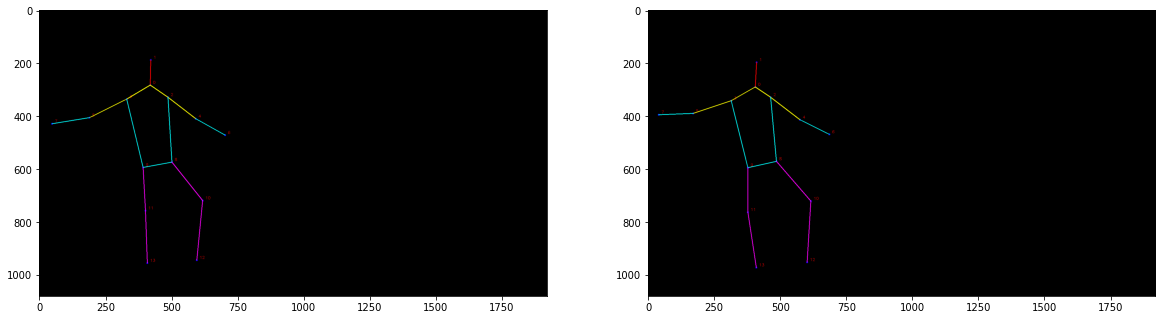

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
(14, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


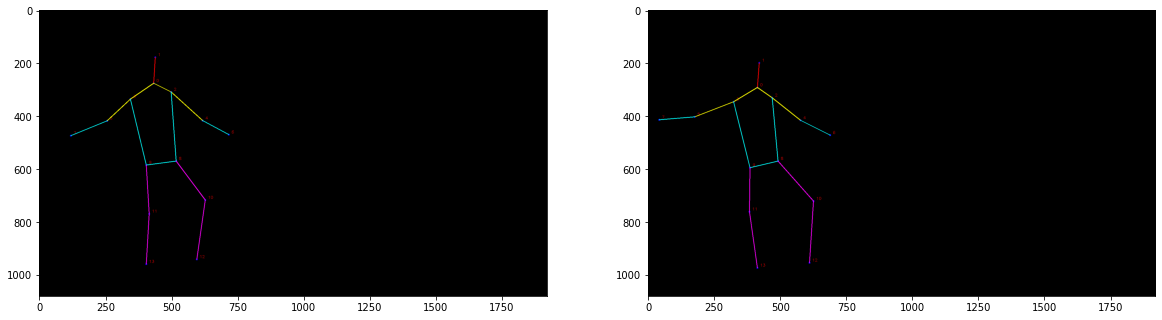

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
(14, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


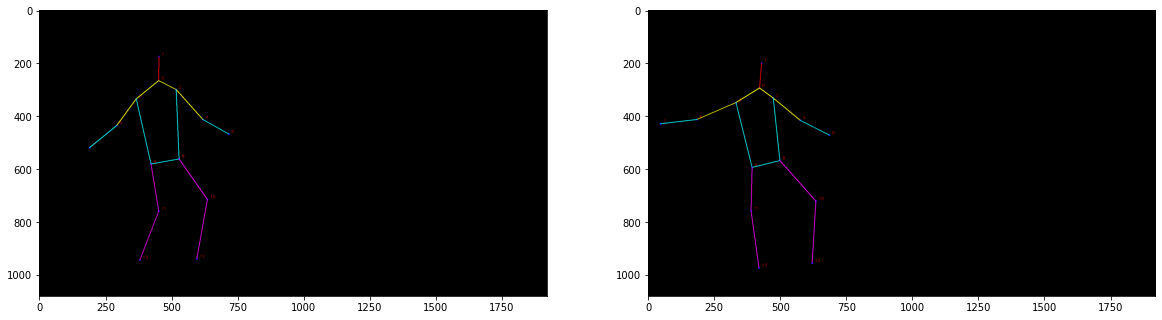

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
(14, 2)


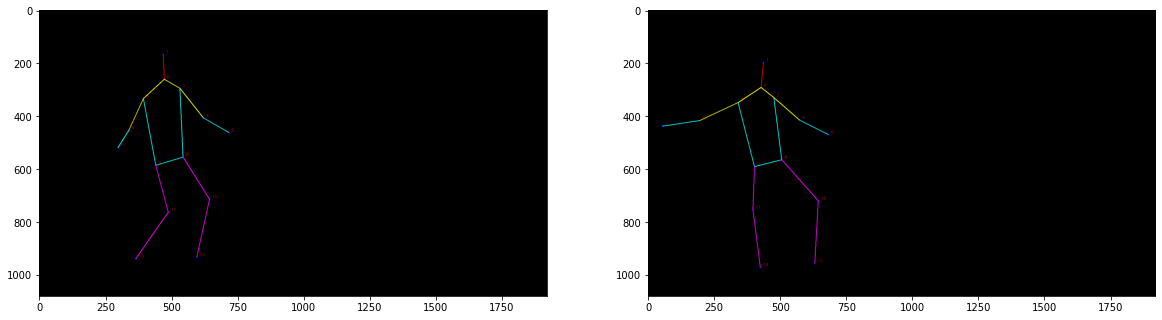

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
(14, 2)


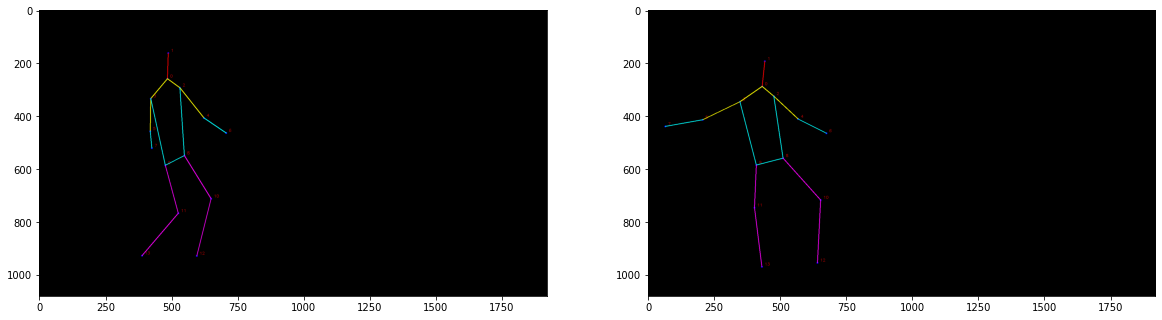

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
(14, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


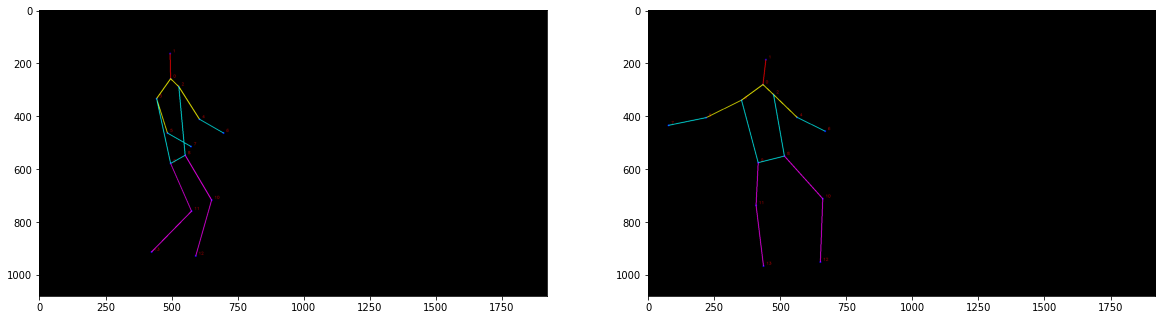

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
(14, 2)


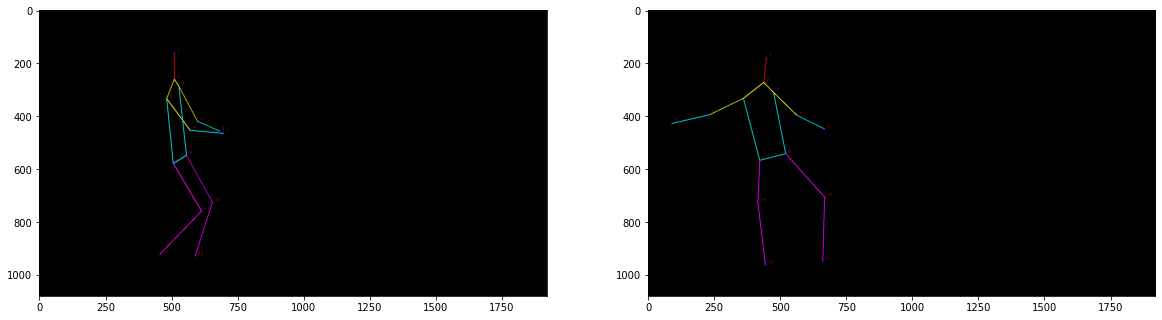

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
(14, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


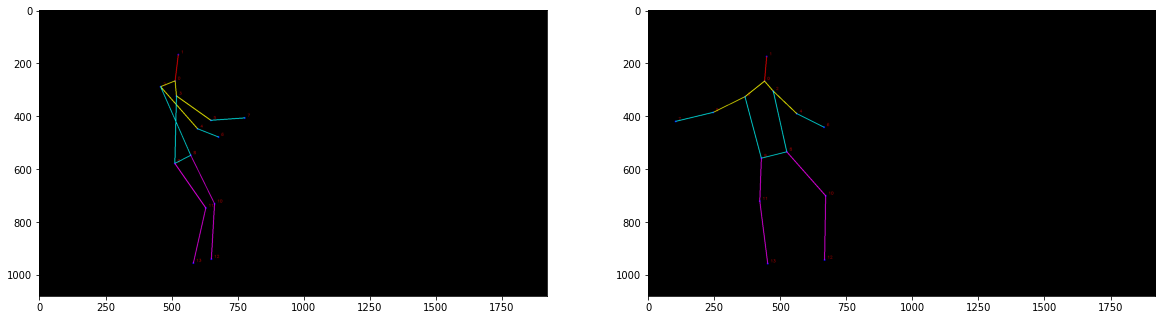

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
(14, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


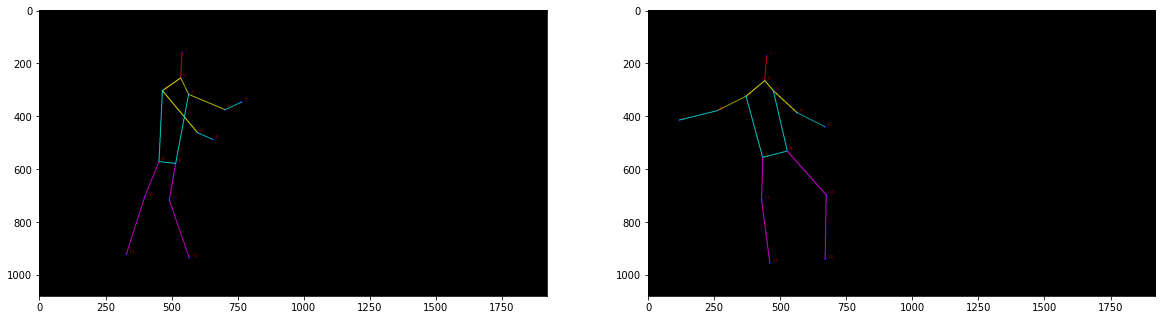

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
(14, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


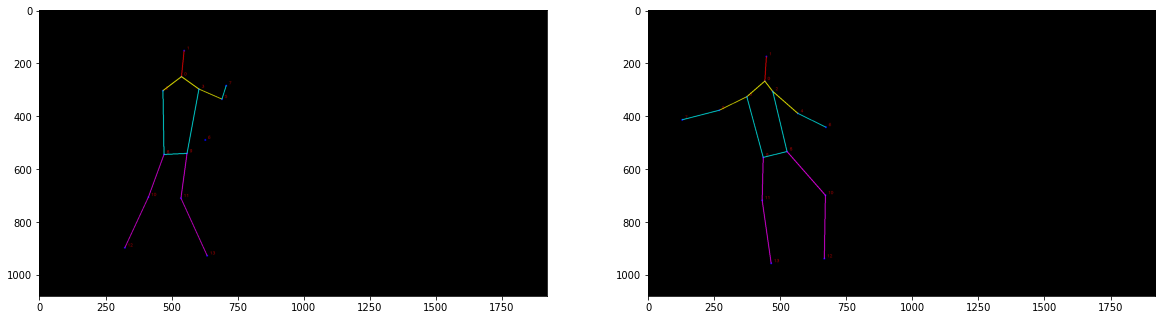

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
(14, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


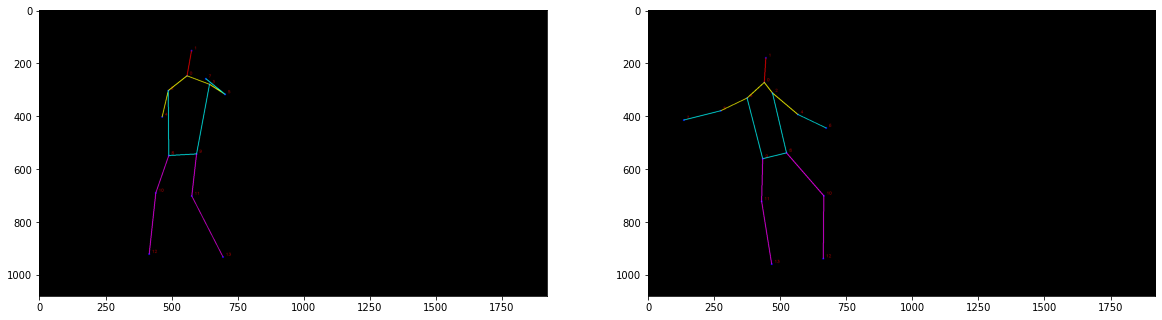

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
(14, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


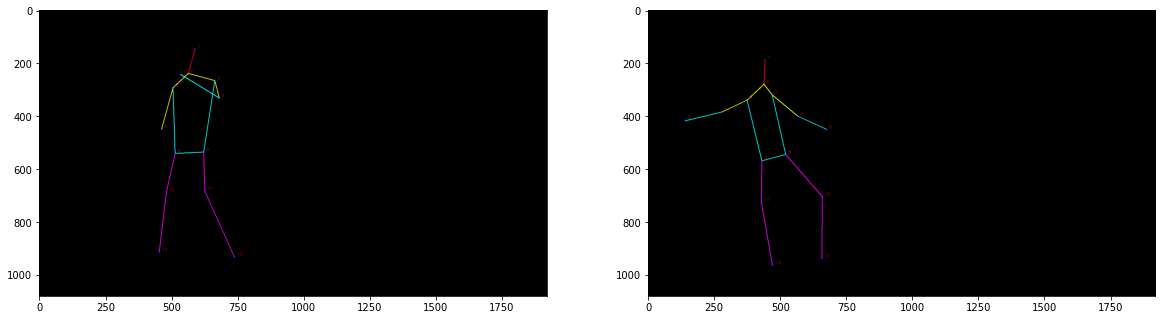

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
(14, 2)


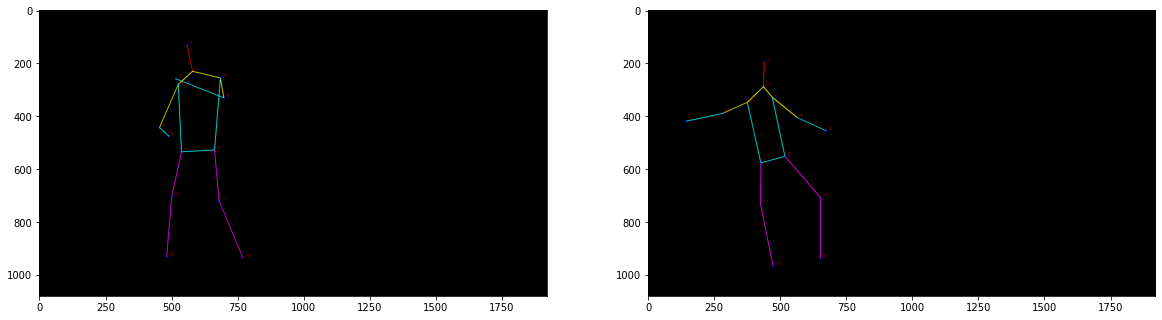

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
(14, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


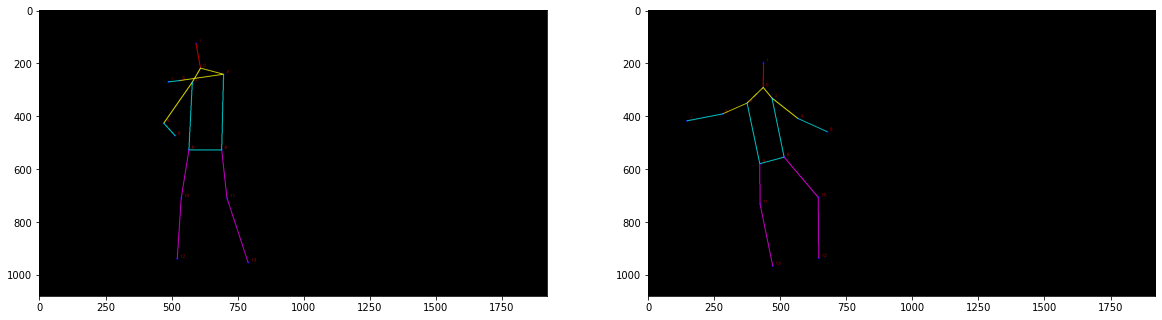

In [257]:
for idx, (obs_s, target_s, obs_pose, target_pose, obs_mask, target_mask) in enumerate(val_loader):
        counter+=1
        obs_s    = obs_s.to(device='cuda')
        target_s = target_s.to(device='cuda')
        obs_pose    = obs_pose.to(device='cuda')
        target_pose = target_pose.to(device='cuda')
        obs_mask    = obs_mask.to(device='cuda')
        target_mask = target_mask.to(device='cuda')
        
        (speed_preds,mask_preds) = net(pose=obs_pose,vel=obs_s,mask=obs_mask)
        preds_p = speed2pos(speed_preds, obs_pose)
#         print(speed_preds[23])
#         print(target_pose.shape)
        for i in range(14):
            actual=target_pose[23][i].detach().cpu().numpy()
            pred=preds_p[23][i].detach().cpu().numpy()
            
            x1=draw_keypoints(actual.astype(int))
            x2=draw_keypoints(pred.astype(int))
            
            f, axarr = plt.subplots(1,2)
            axarr[0].imshow(x1)
            axarr[1].imshow(x2)
            plt.show()

        
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
0 0 0


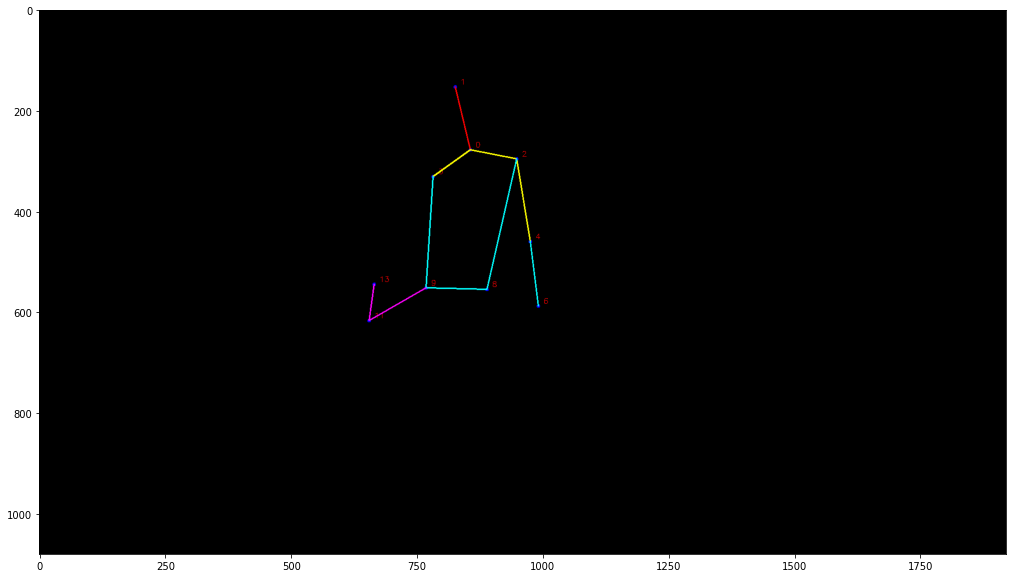

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
0 1 0


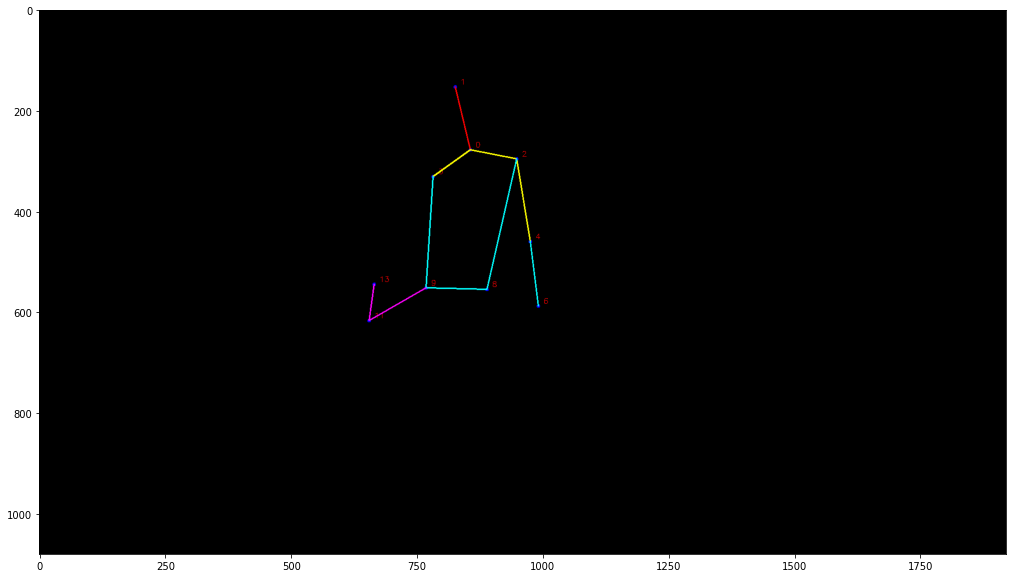

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
0 2 0


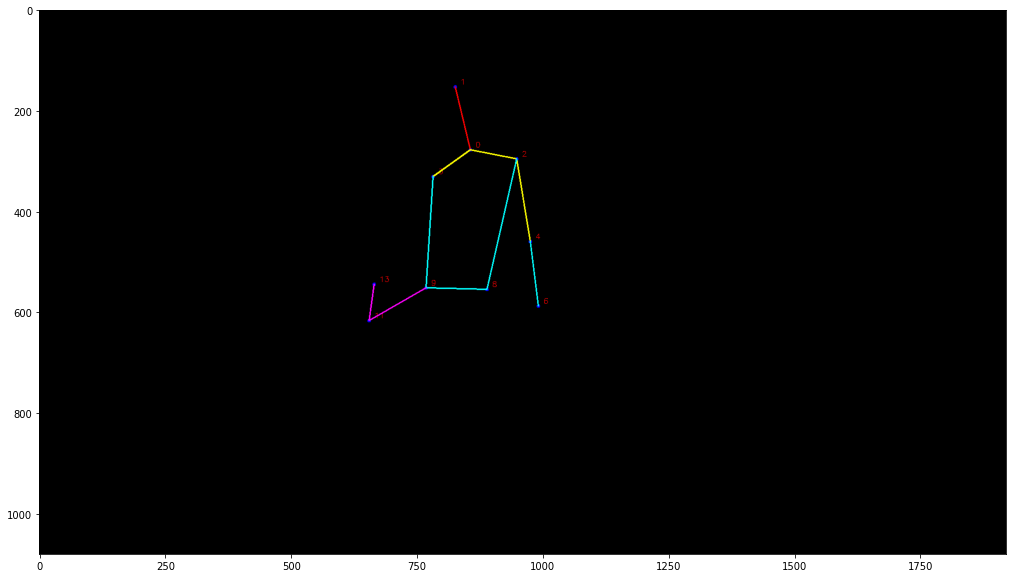

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
0 3 0


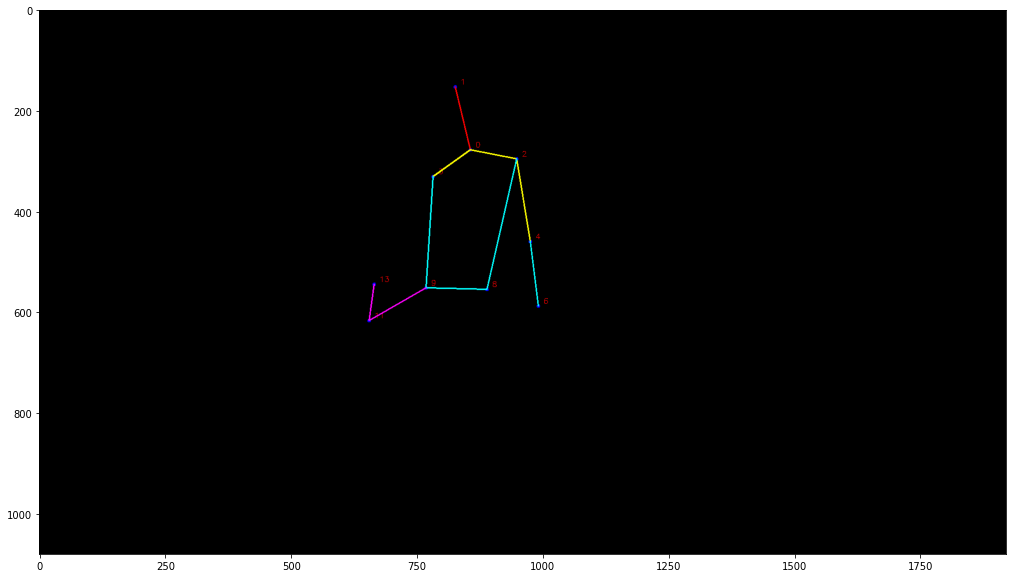

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
0 4 0


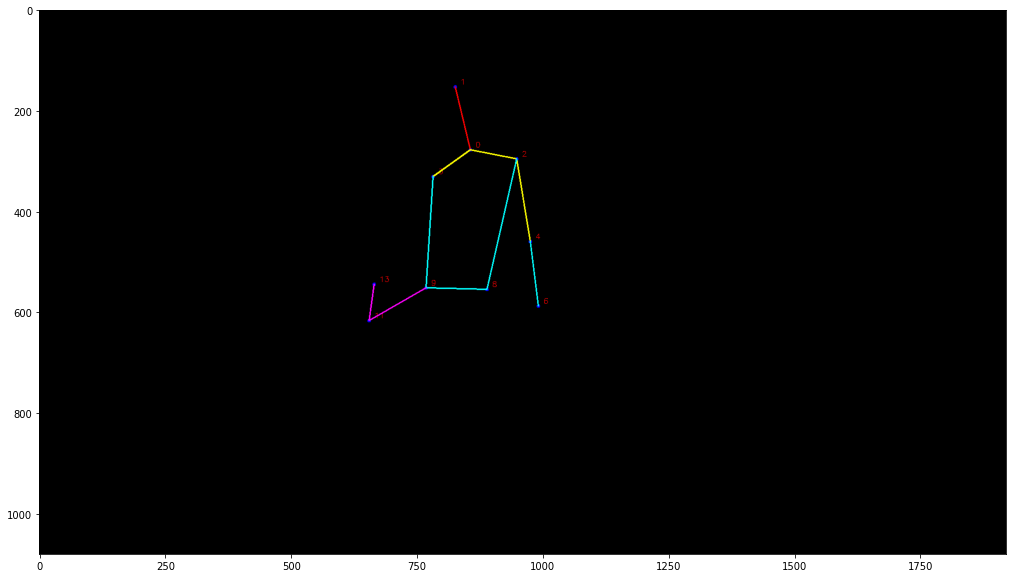

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
0 5 0


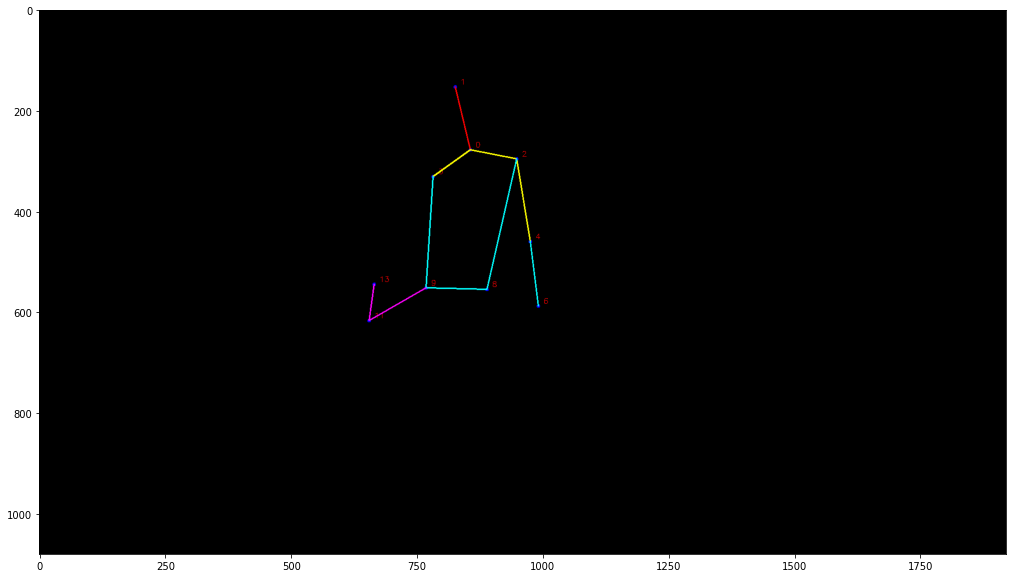

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
0 6 0


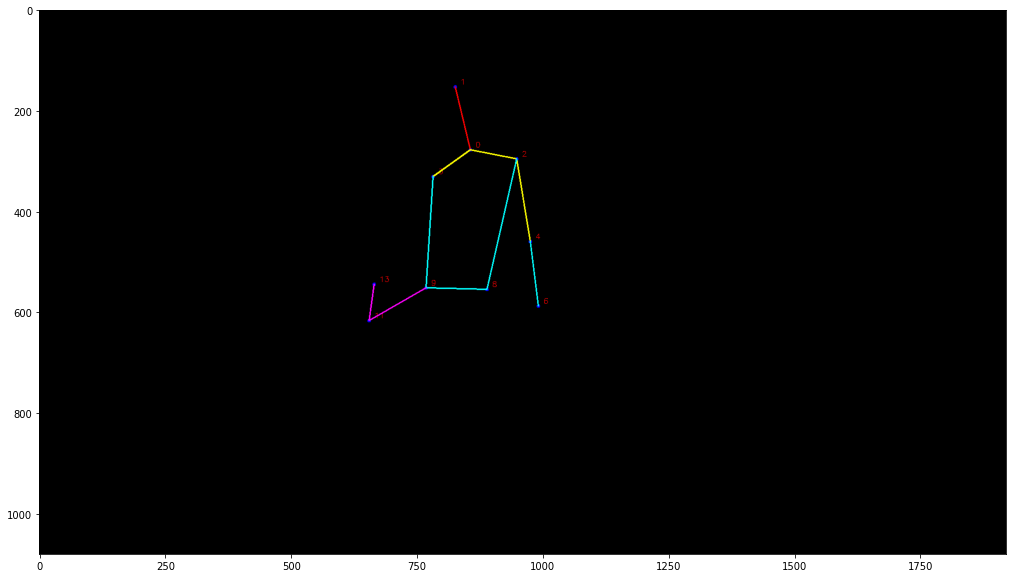

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
0 7 0


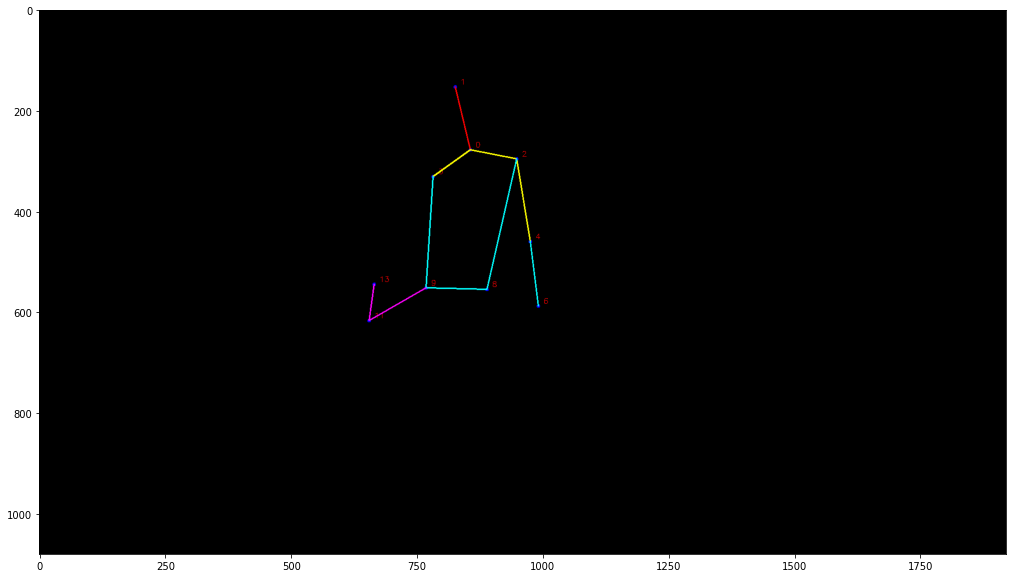

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
0 8 0


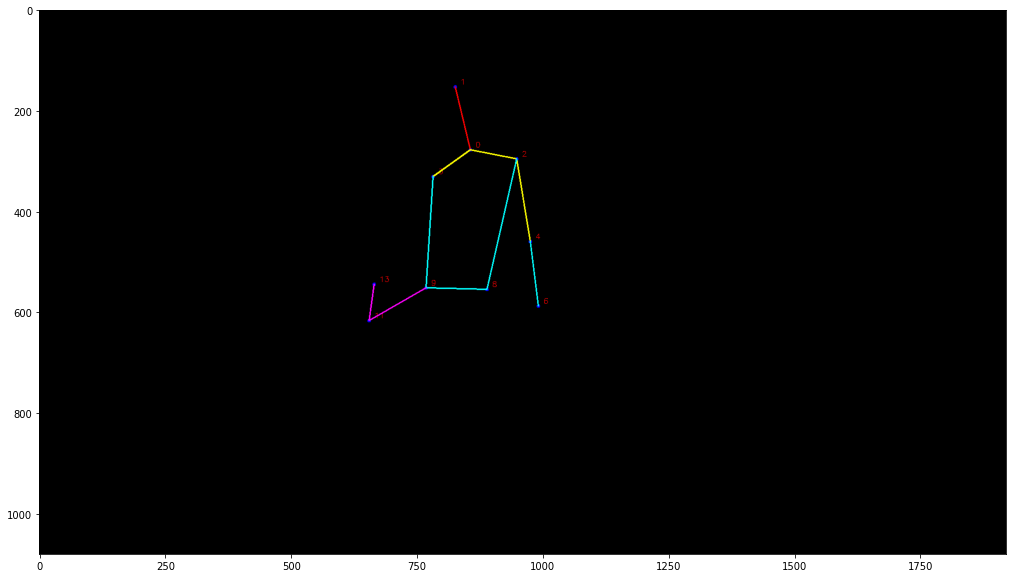

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
0 9 0


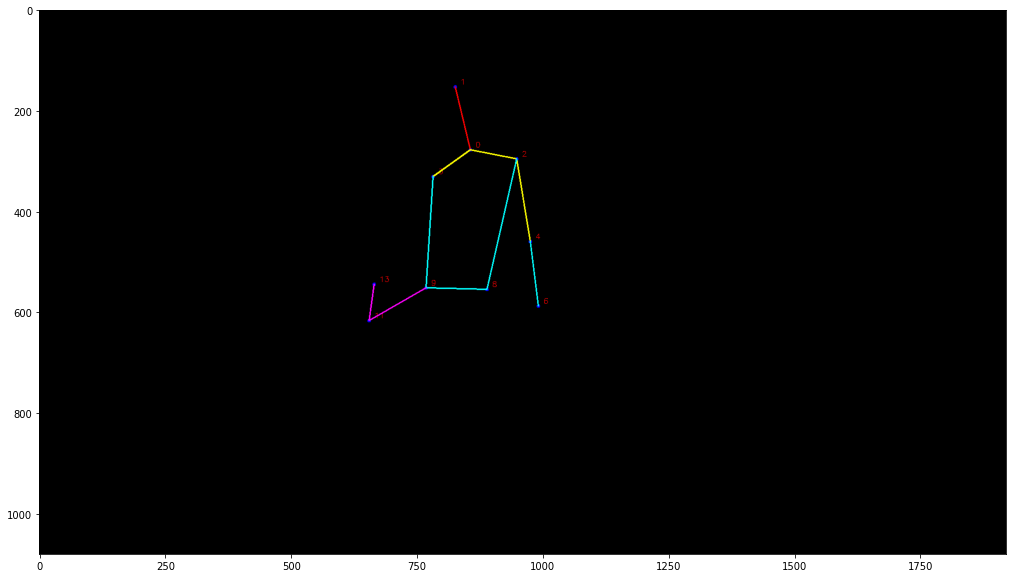

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
0 10 0


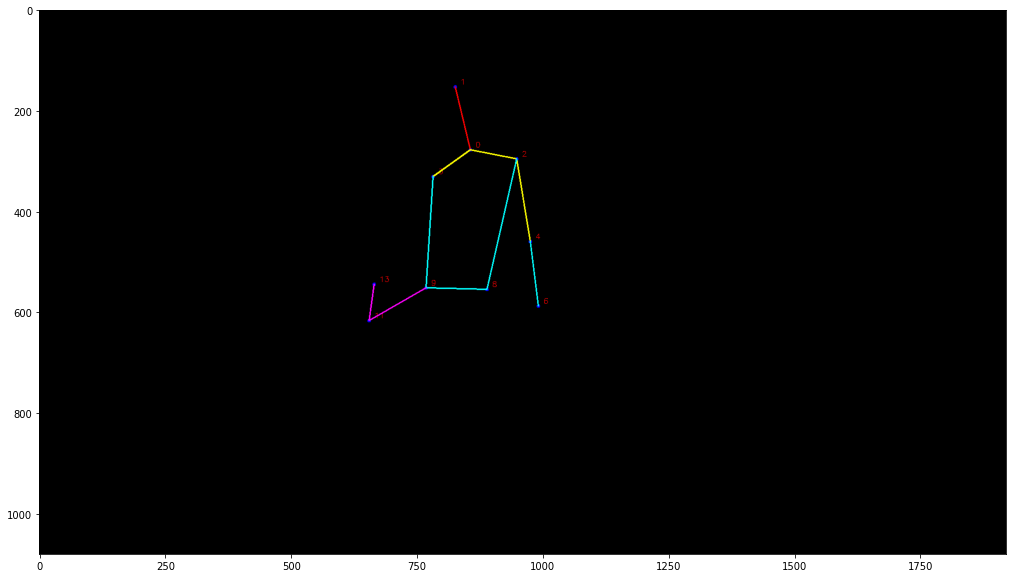

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
0 11 0


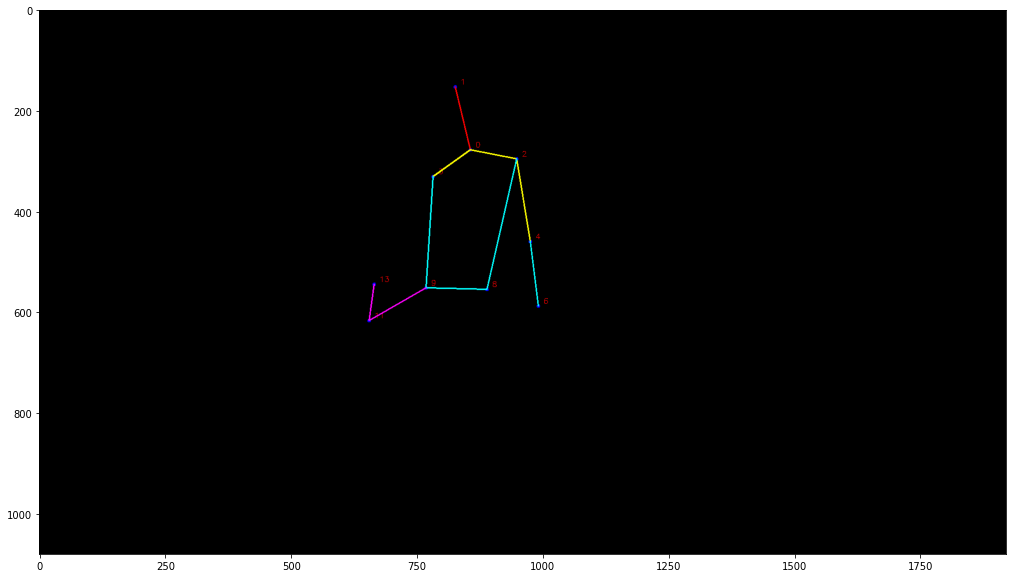

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
0 12 0


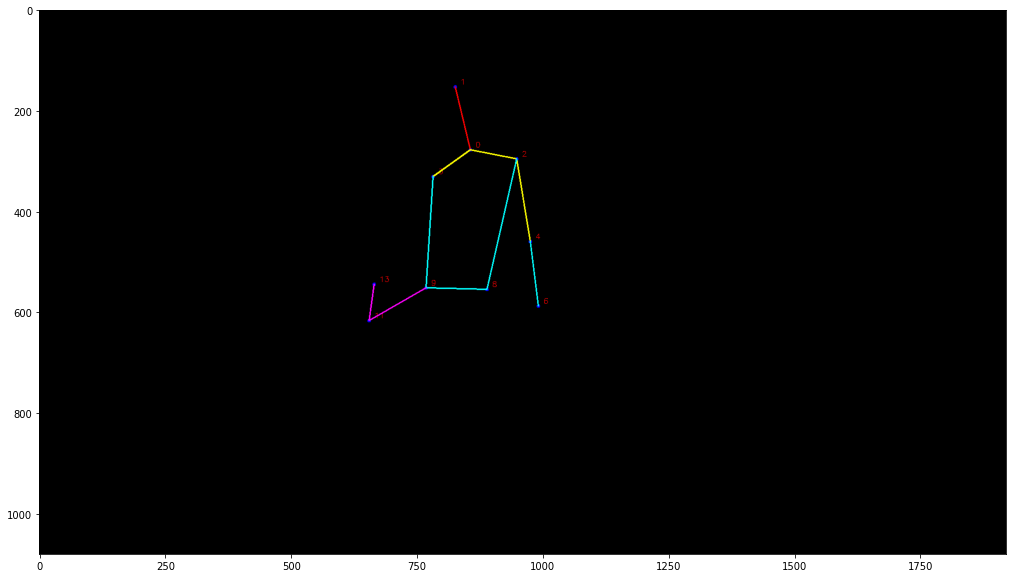

(14, 2)
0 13 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


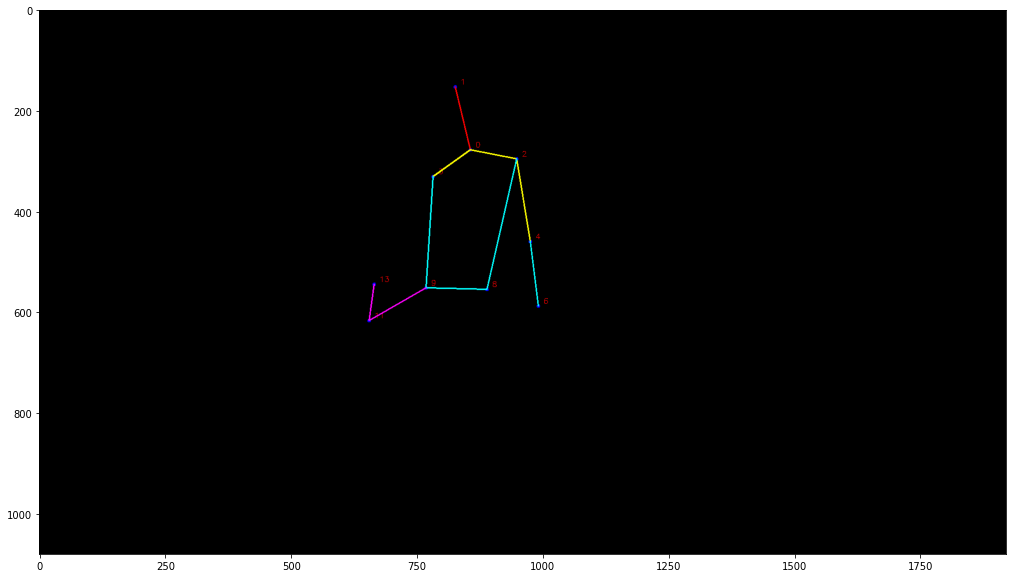

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
1 0 0


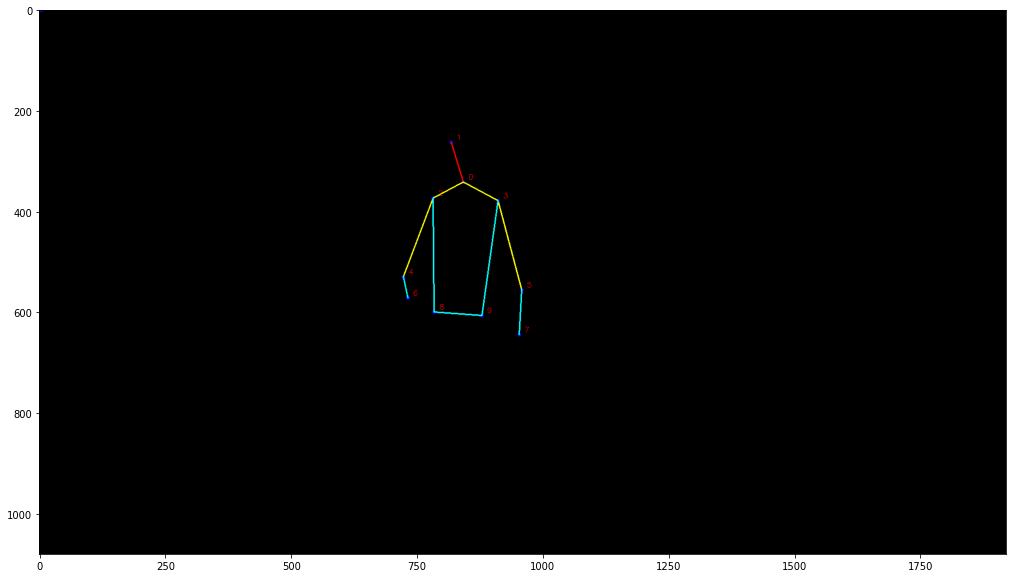

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
1 1 0


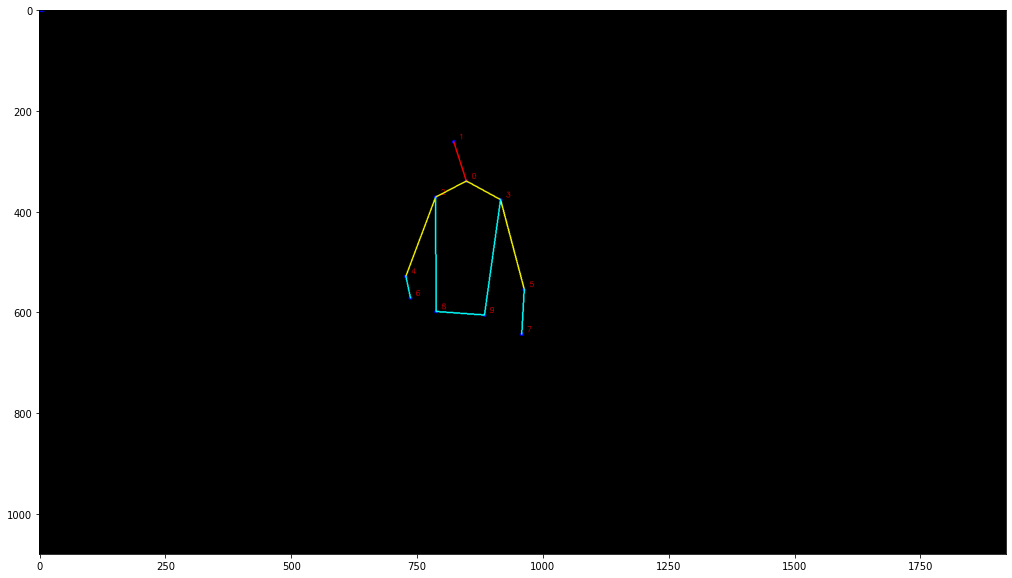

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
1 2 0


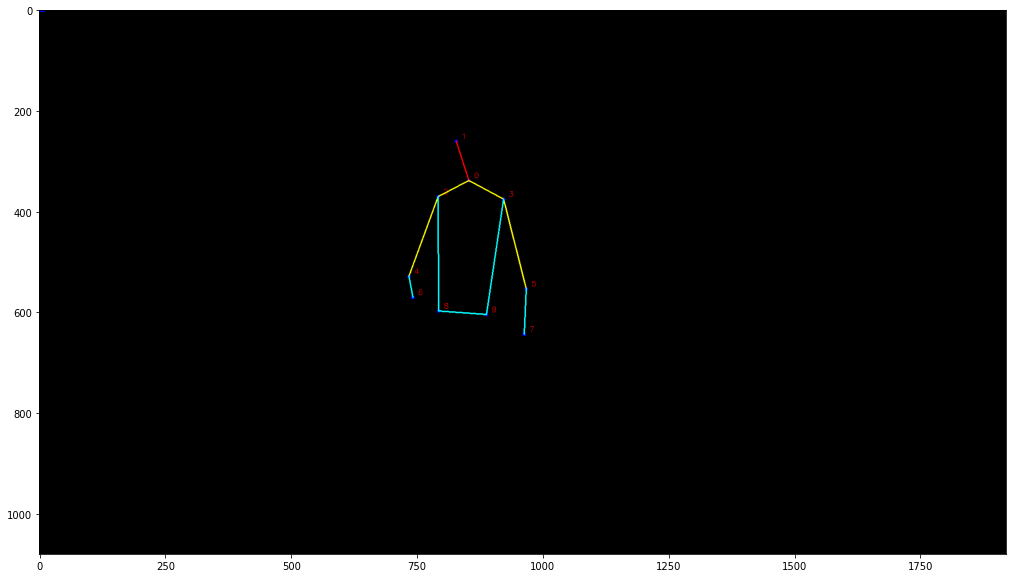

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
1 3 0


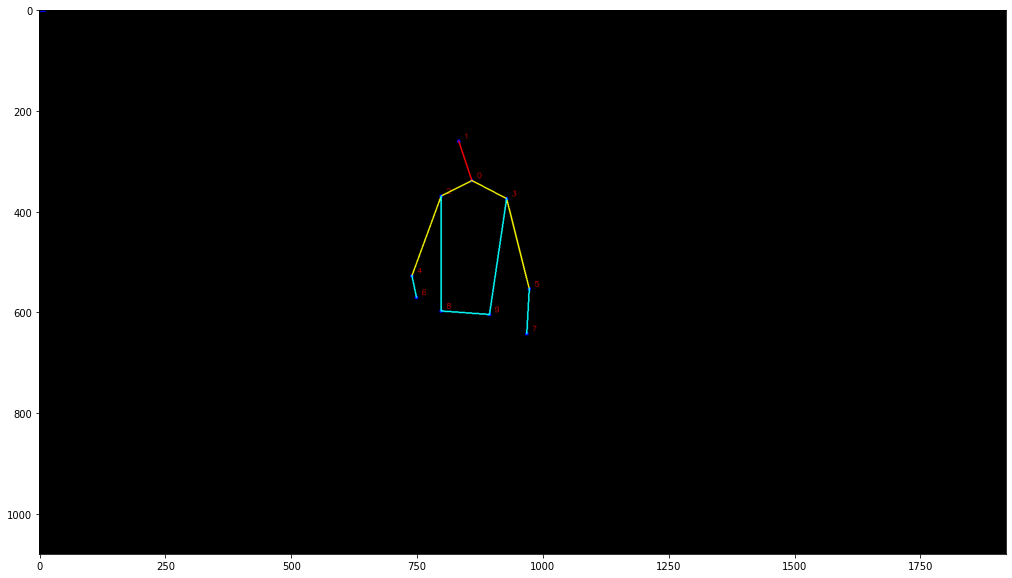

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
1 4 0


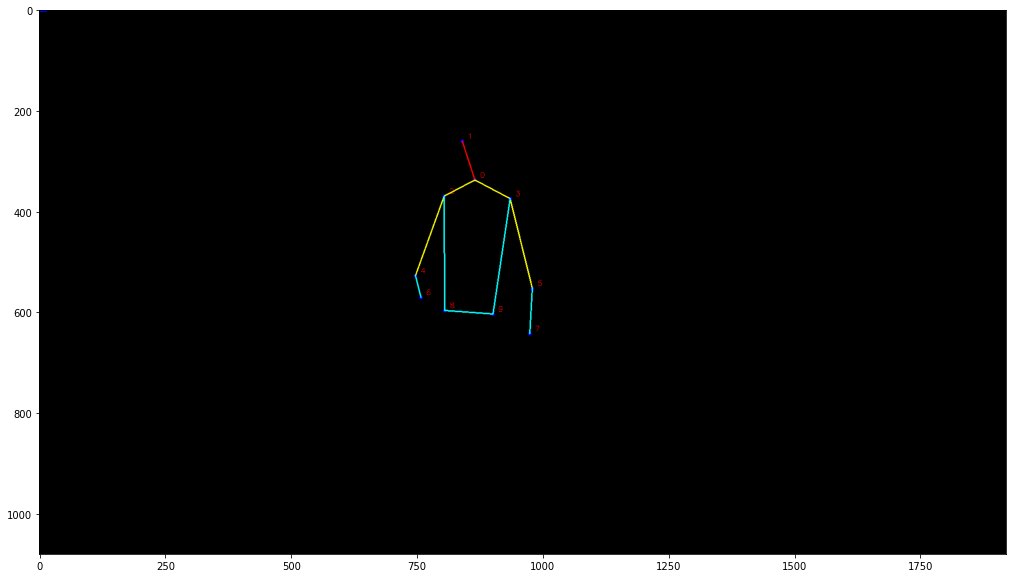

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
1 5 0


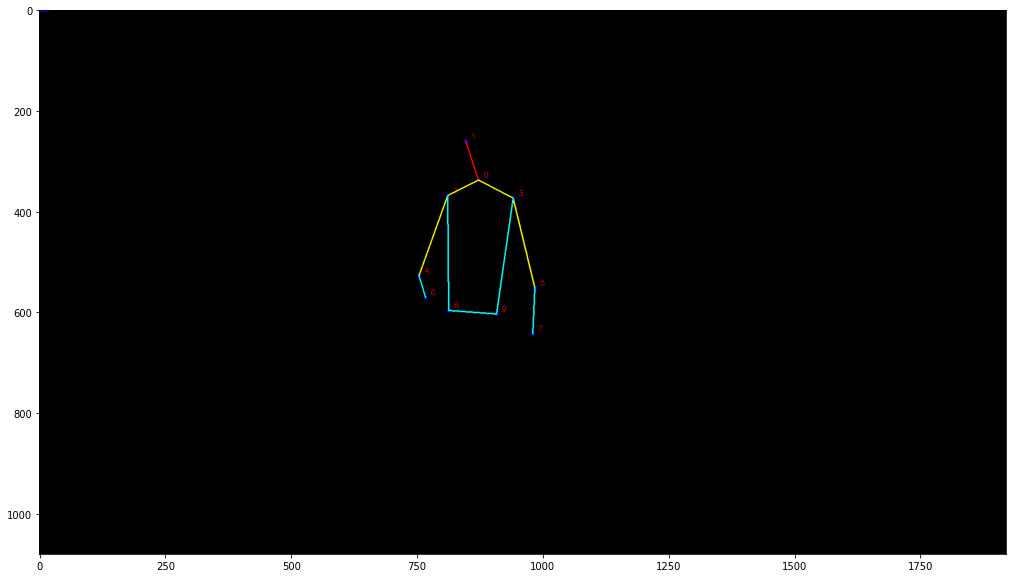

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
1 6 0


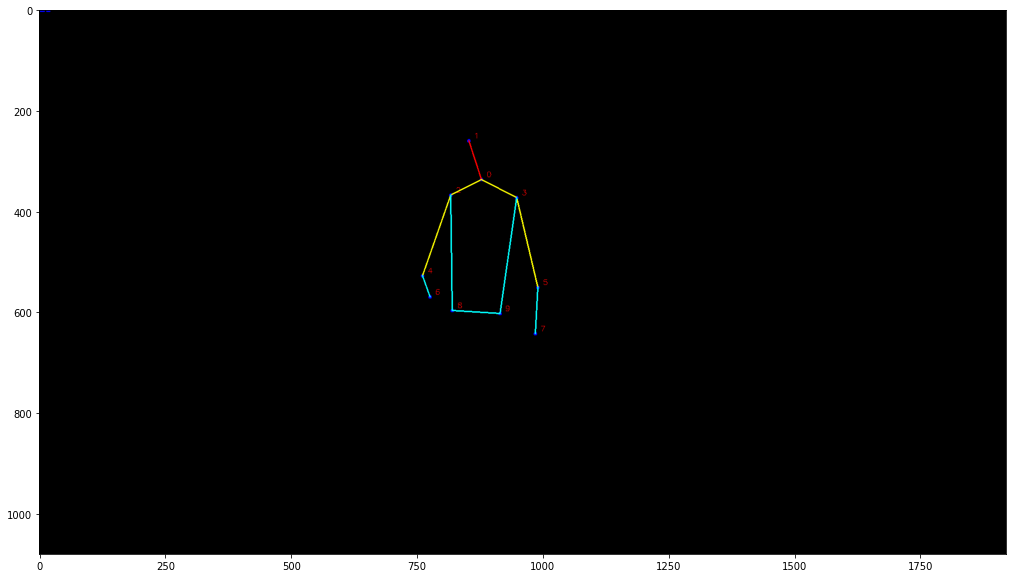

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
1 7 0


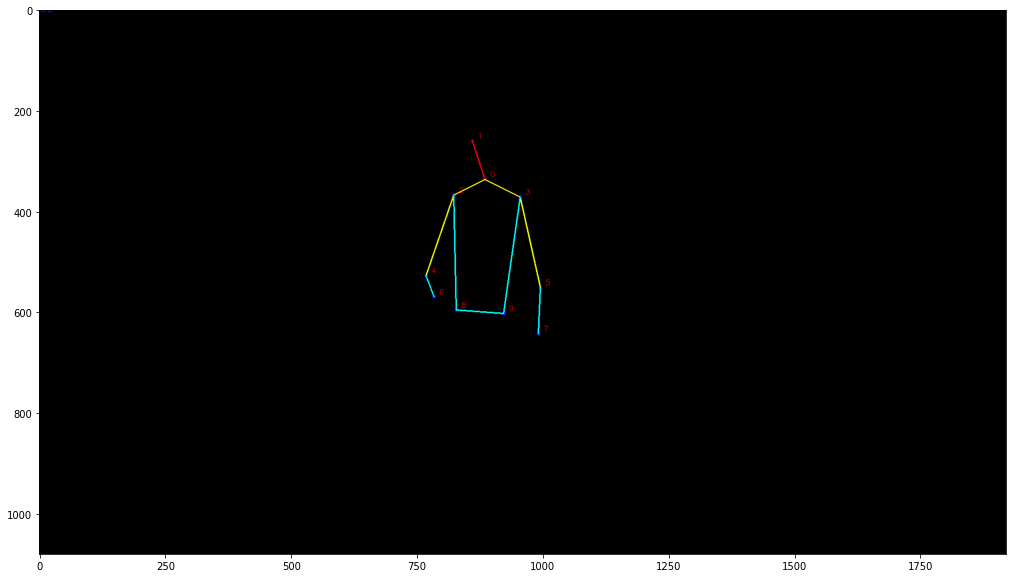

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
1 8 0


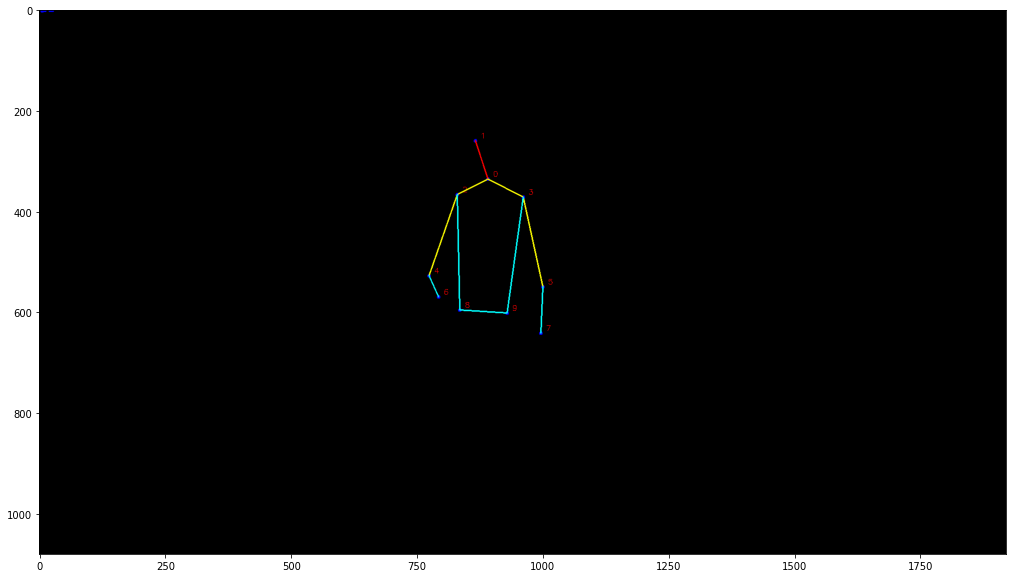

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
1 9 0


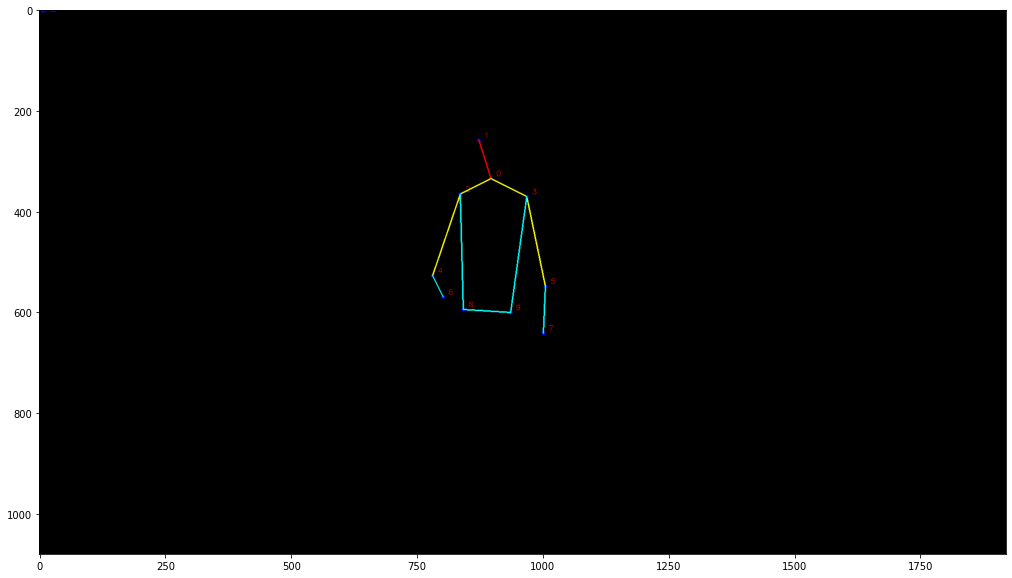

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
1 10 0


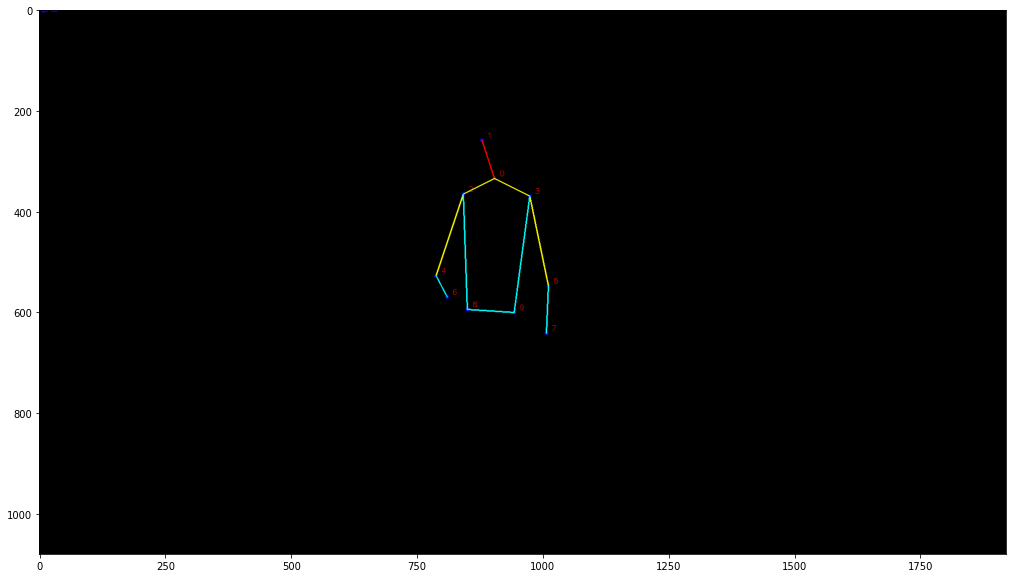

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
1 11 0


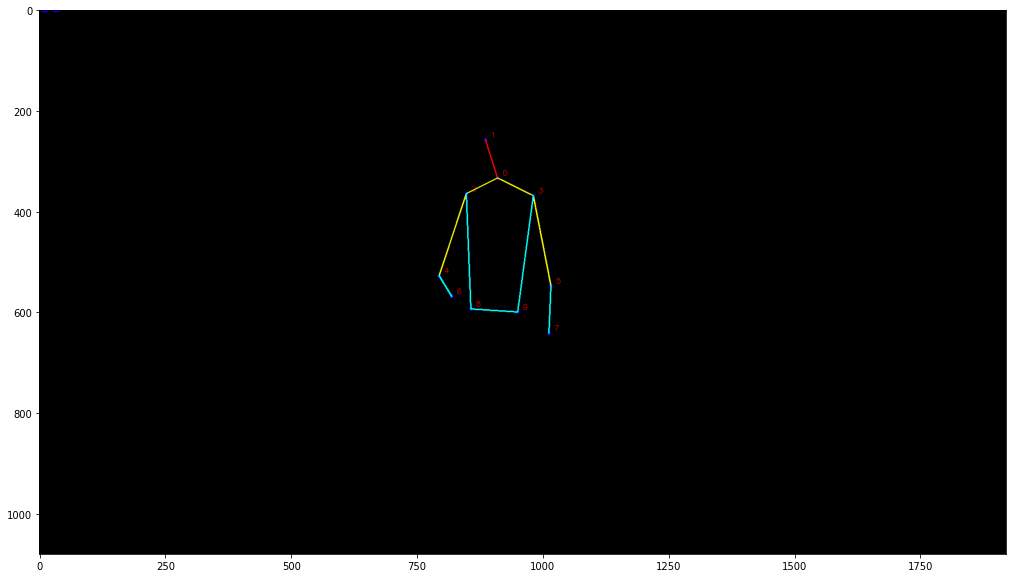

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
1 12 0


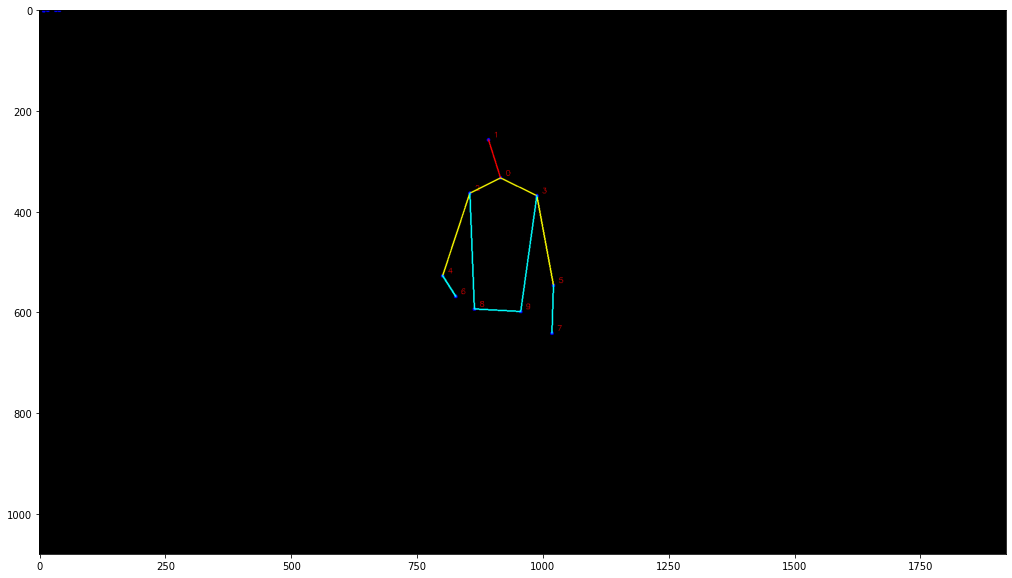

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
1 13 0


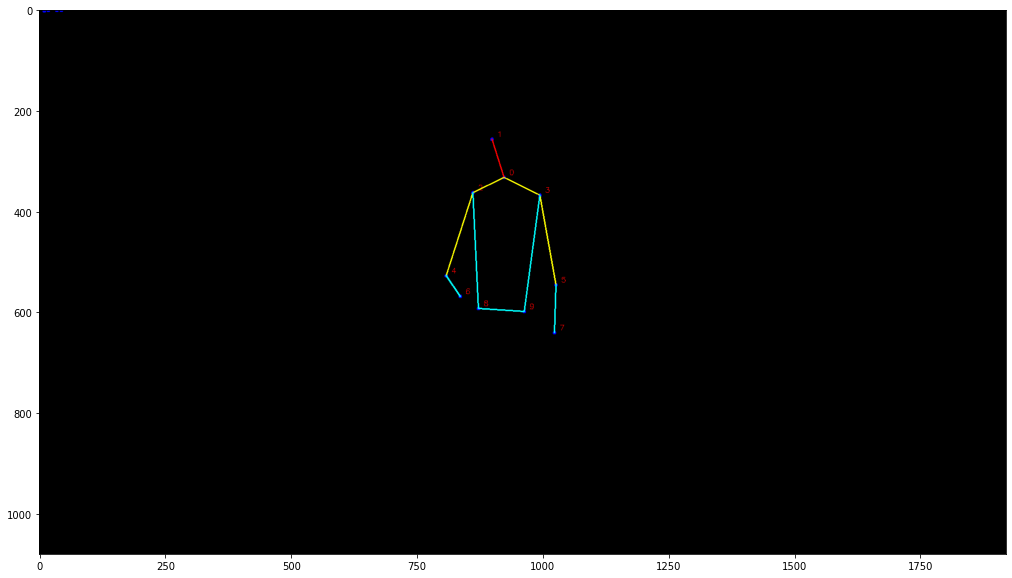

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
2 0 0


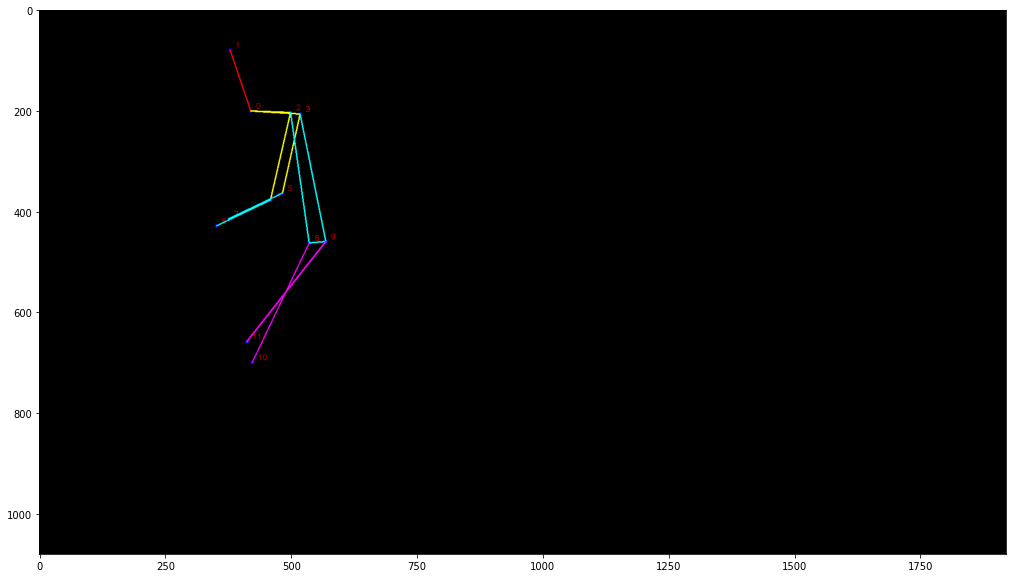

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
2 1 0


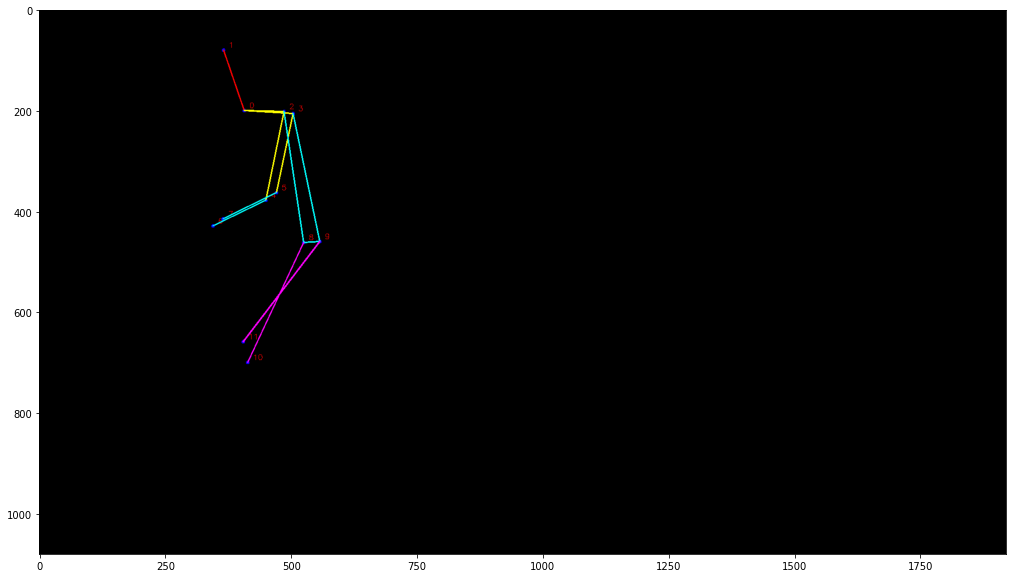

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
2 2 0


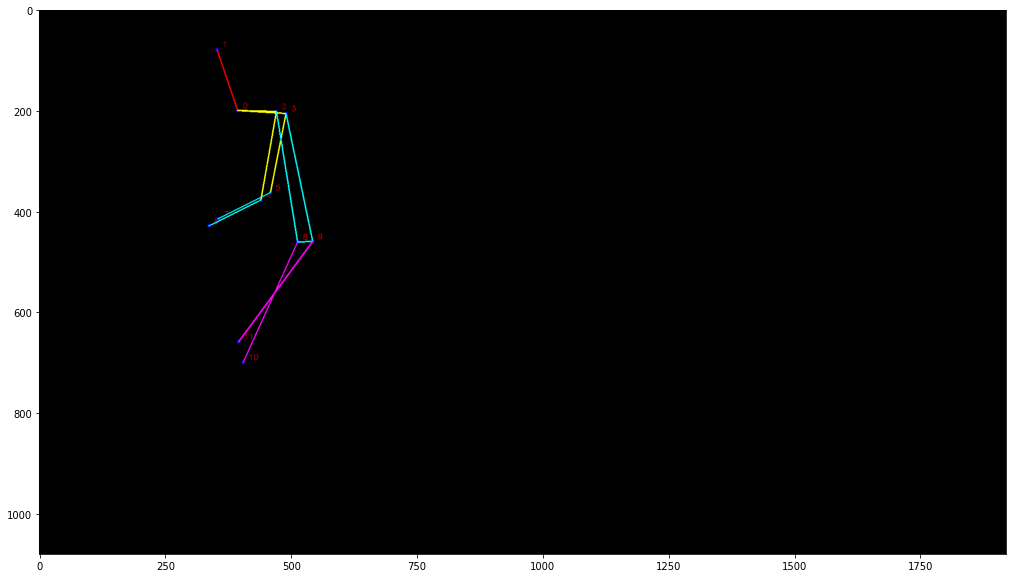

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
2 3 0


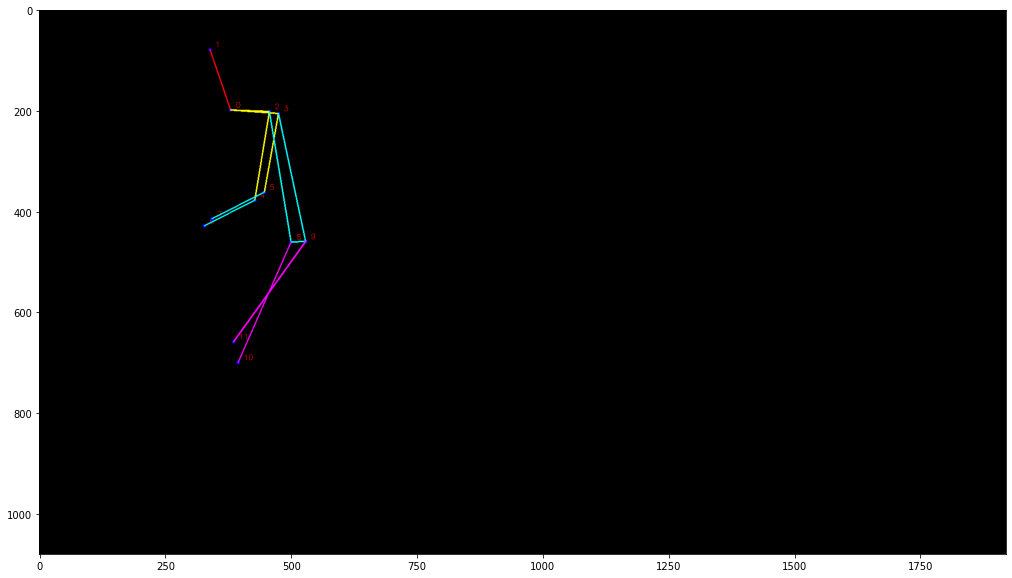

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
2 4 0


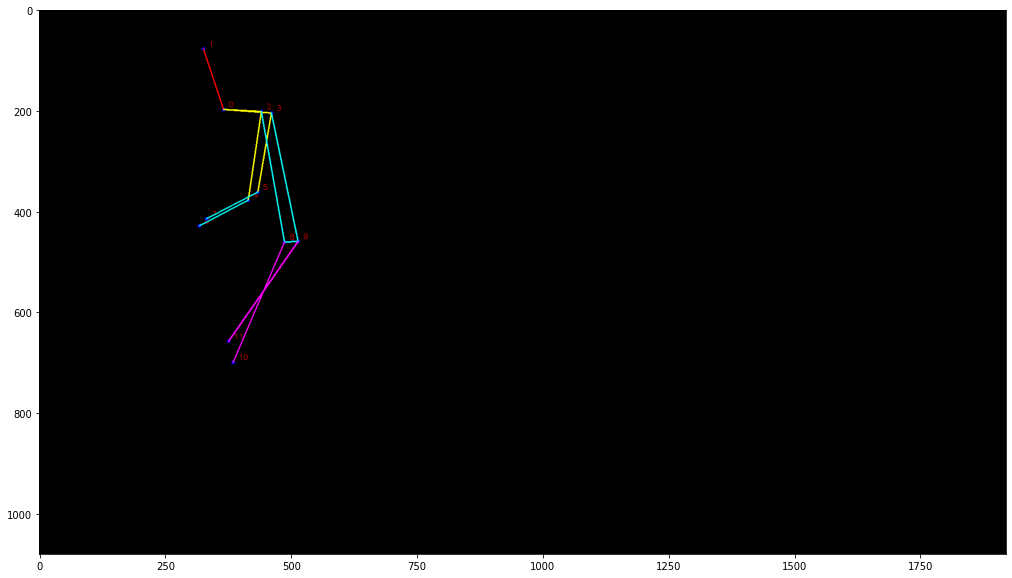

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
2 5 0


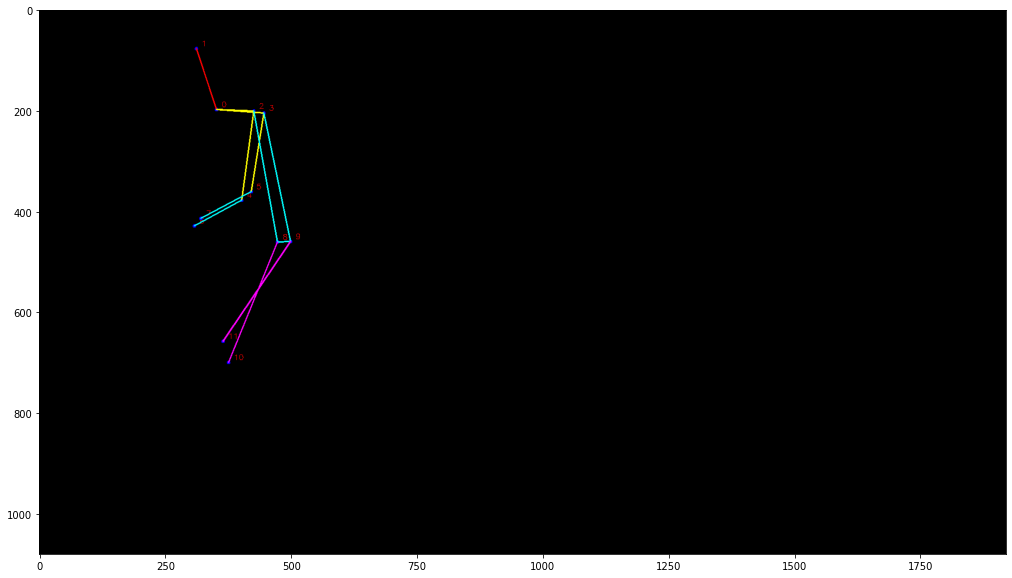

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
2 6 0


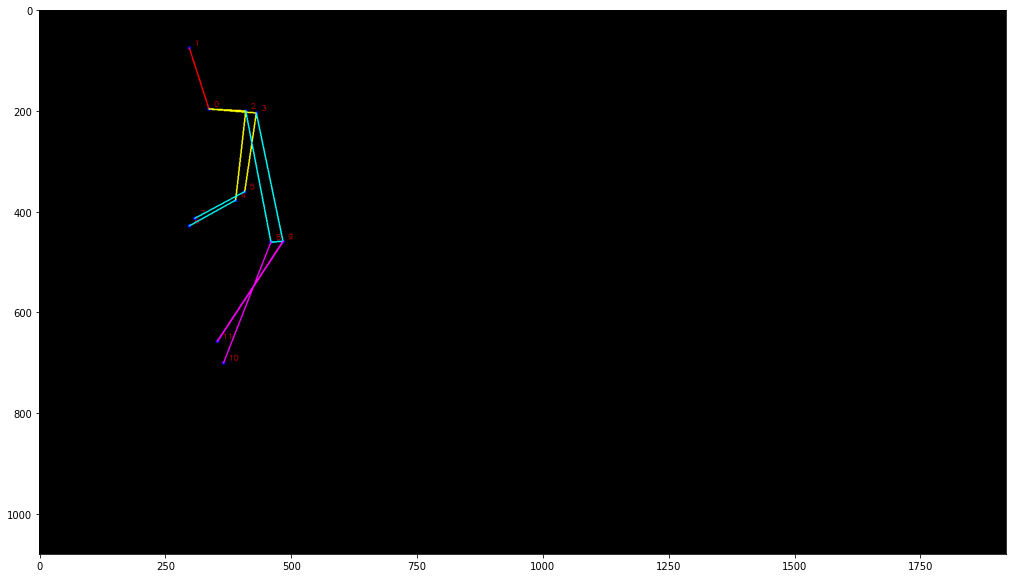

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
2 7 0


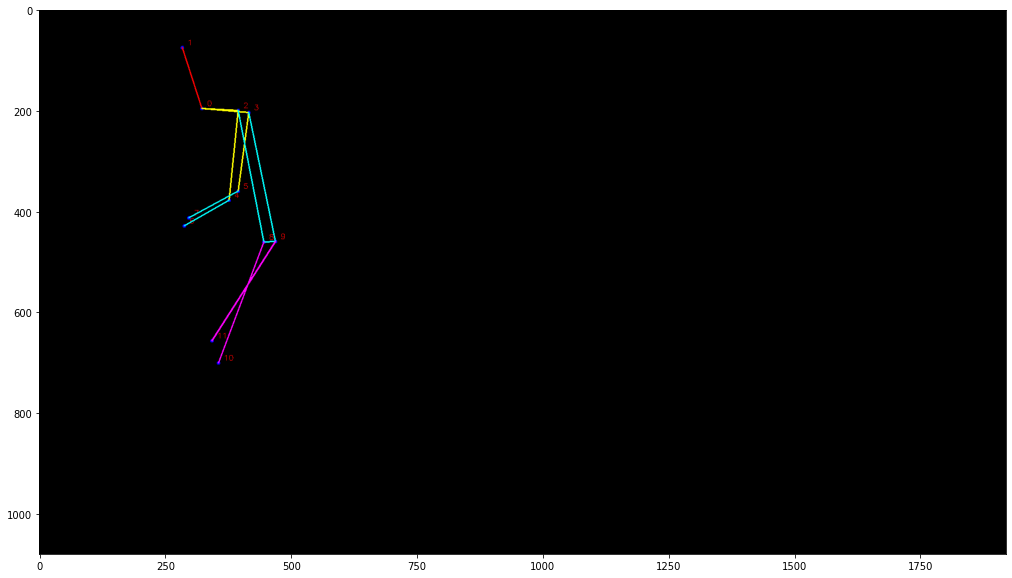

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
2 8 0


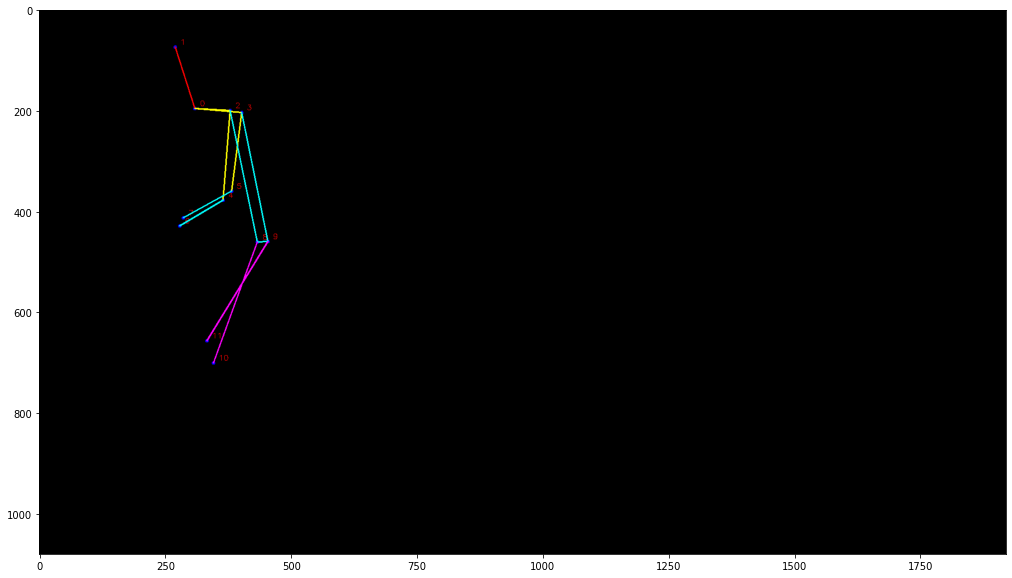

(14, 2)
2 9 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


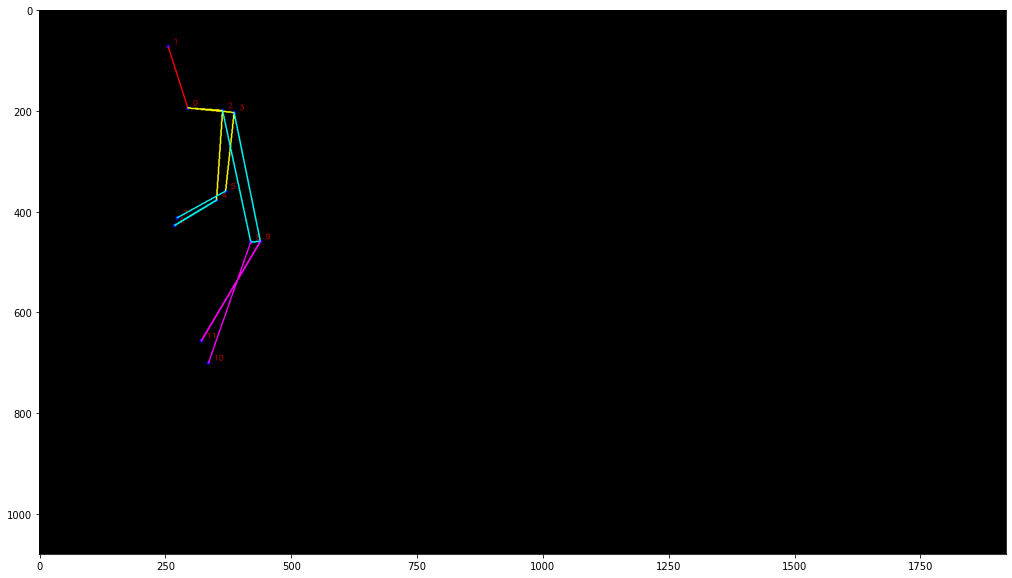

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
2 10 0


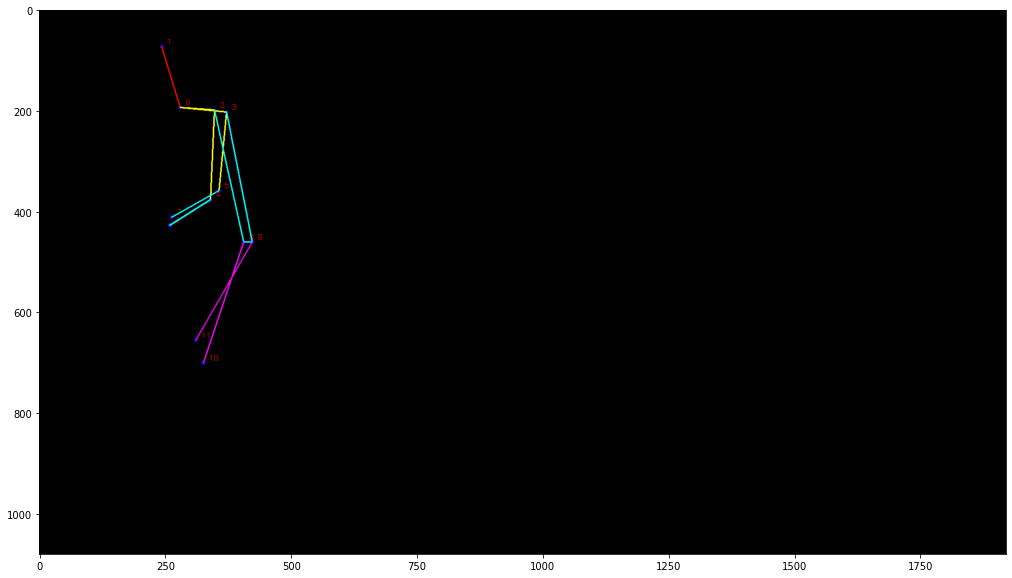

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
2 11 0


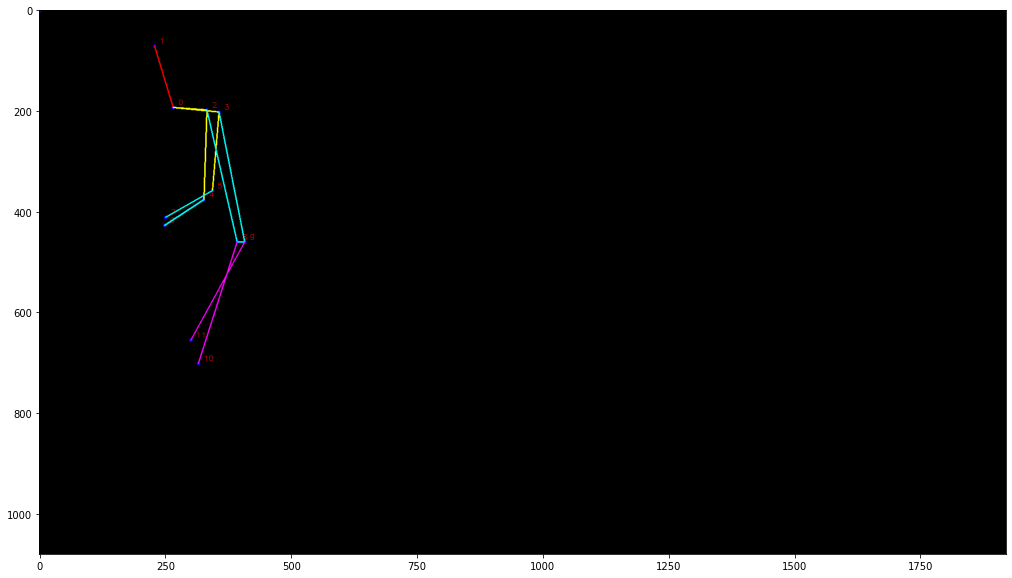

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
2 12 0


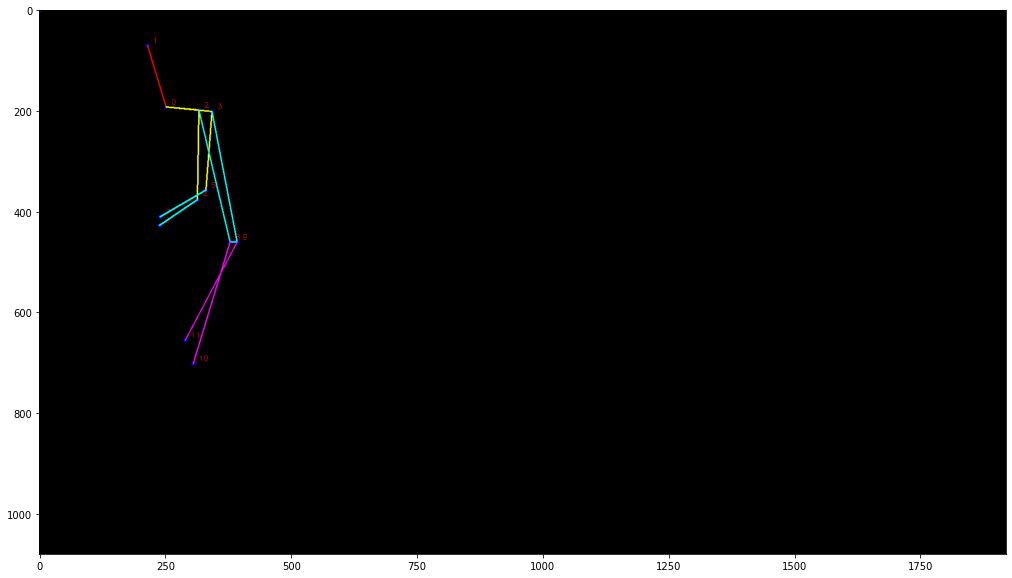

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
2 13 0


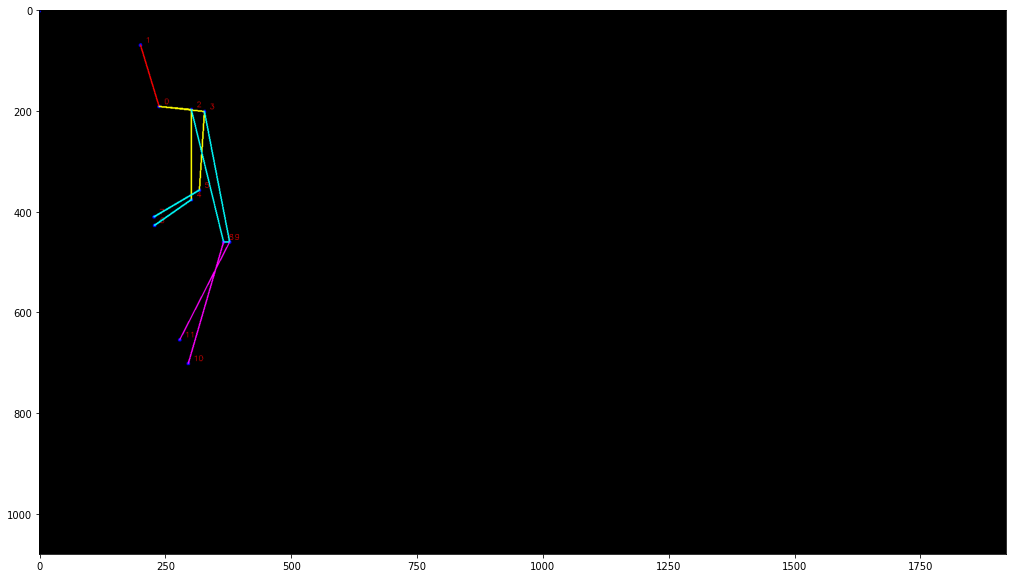

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
3 0 0


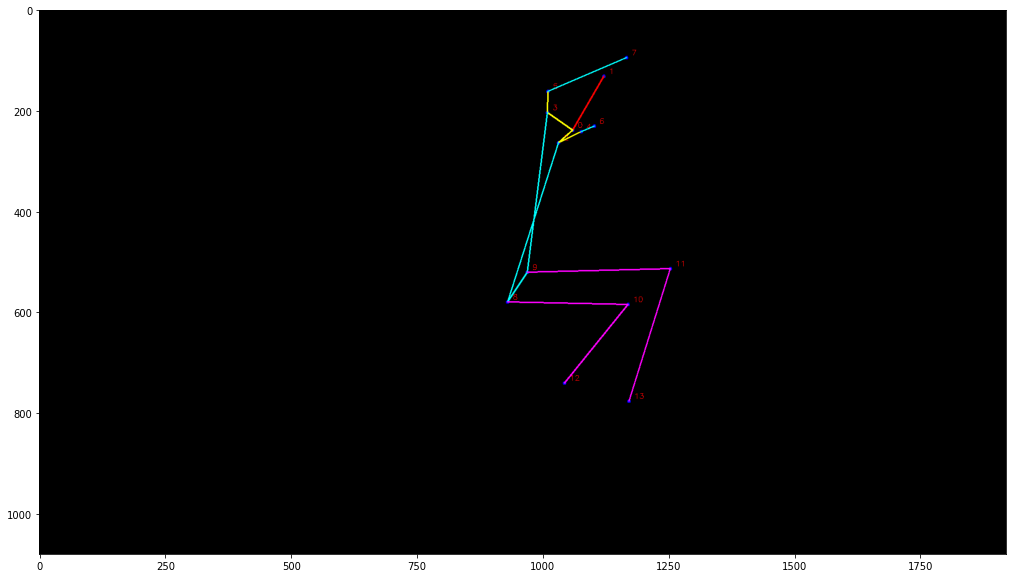

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
3 1 0


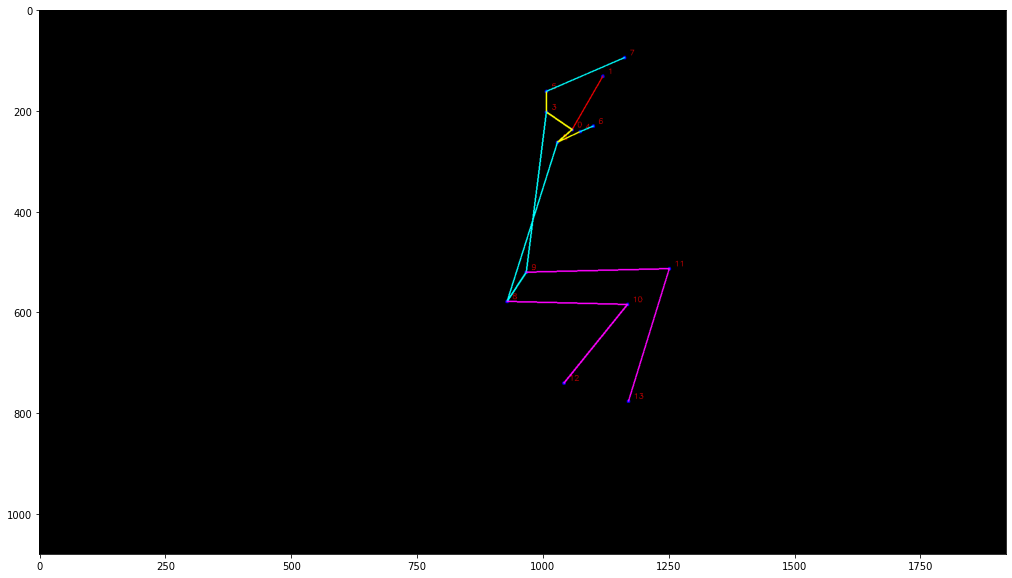

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
3 2 0


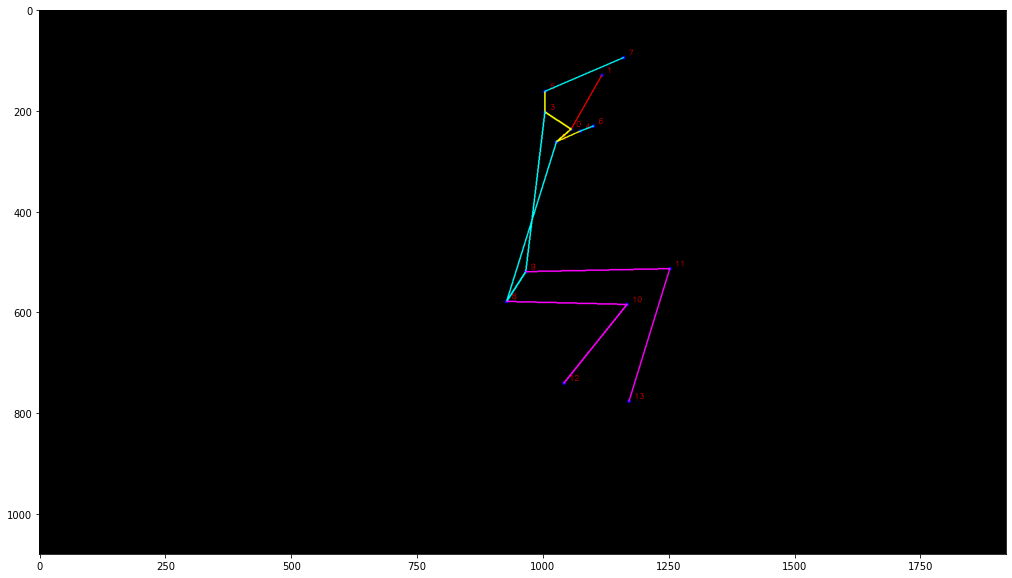

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
3 3 0


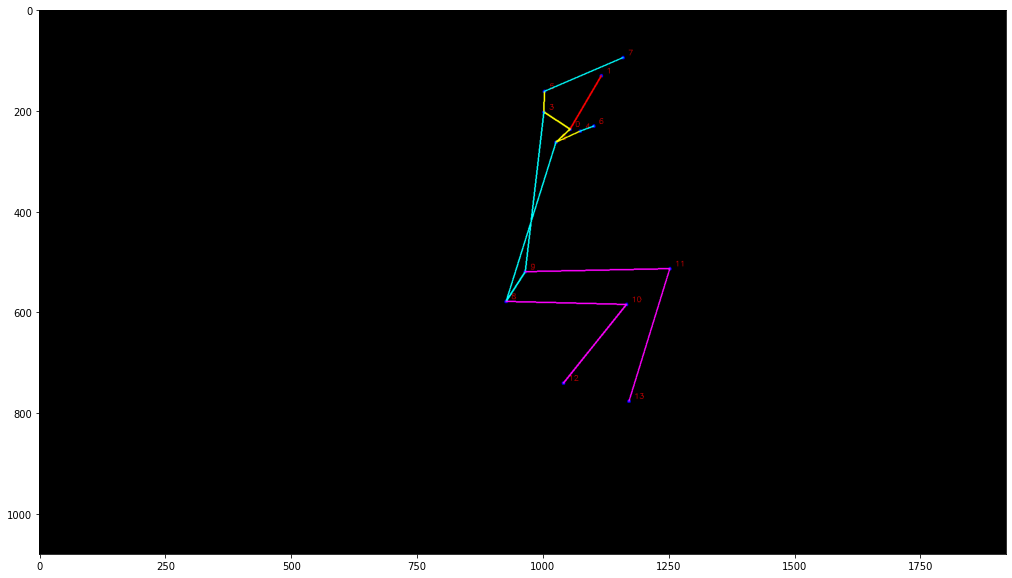

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
3 4 0


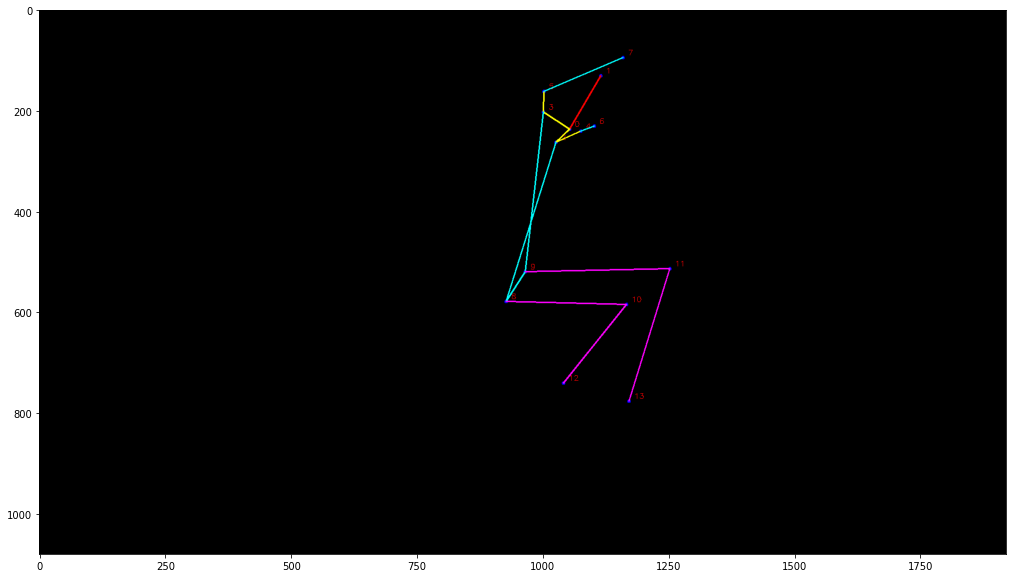

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
3 5 0


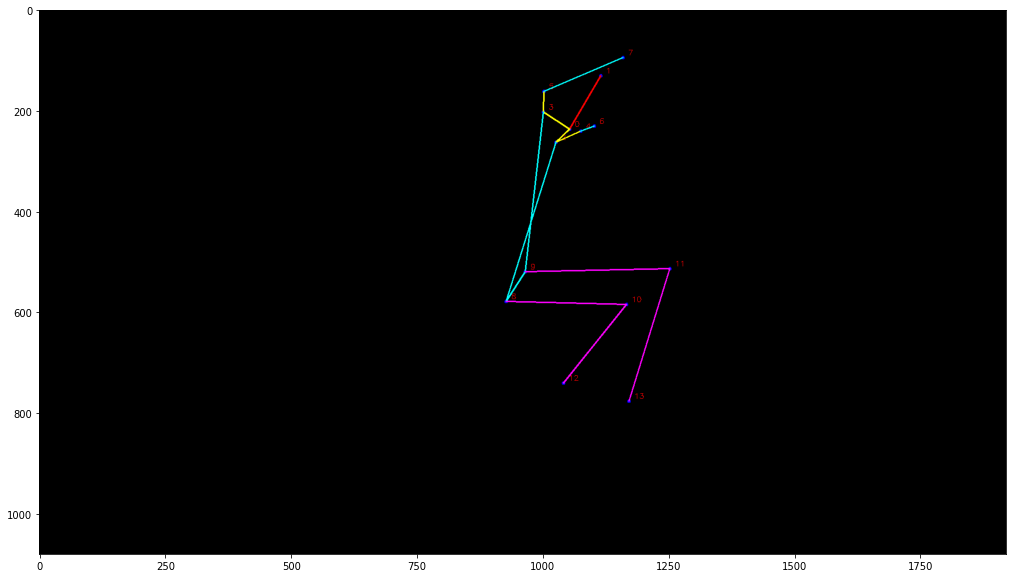

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
3 6 0


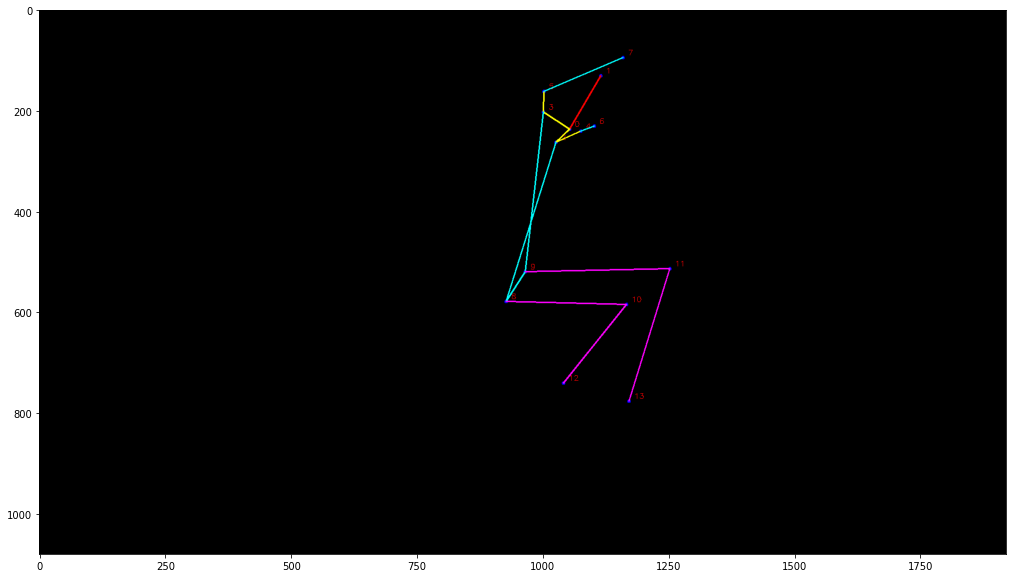

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
3 7 0


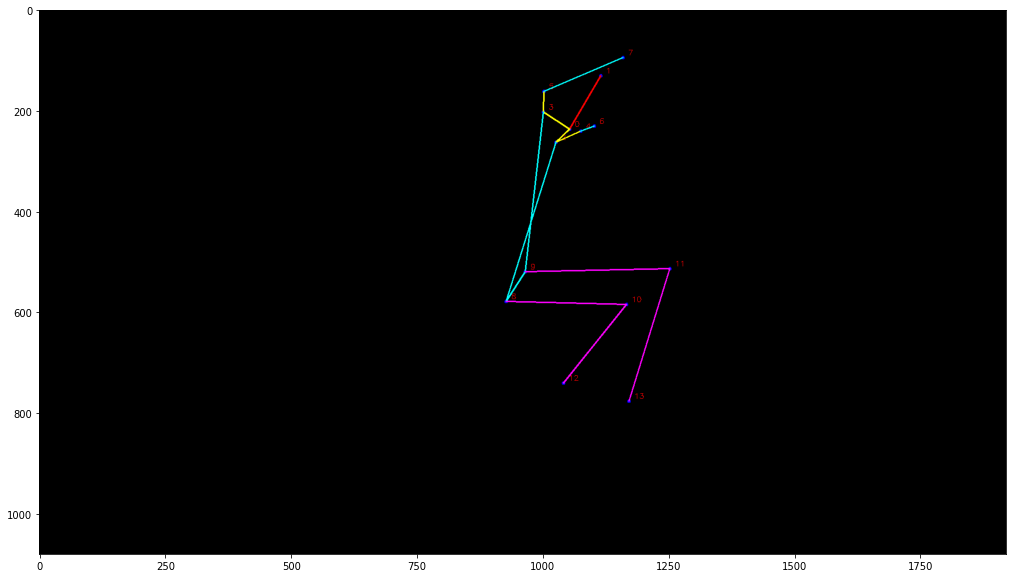

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
3 8 0


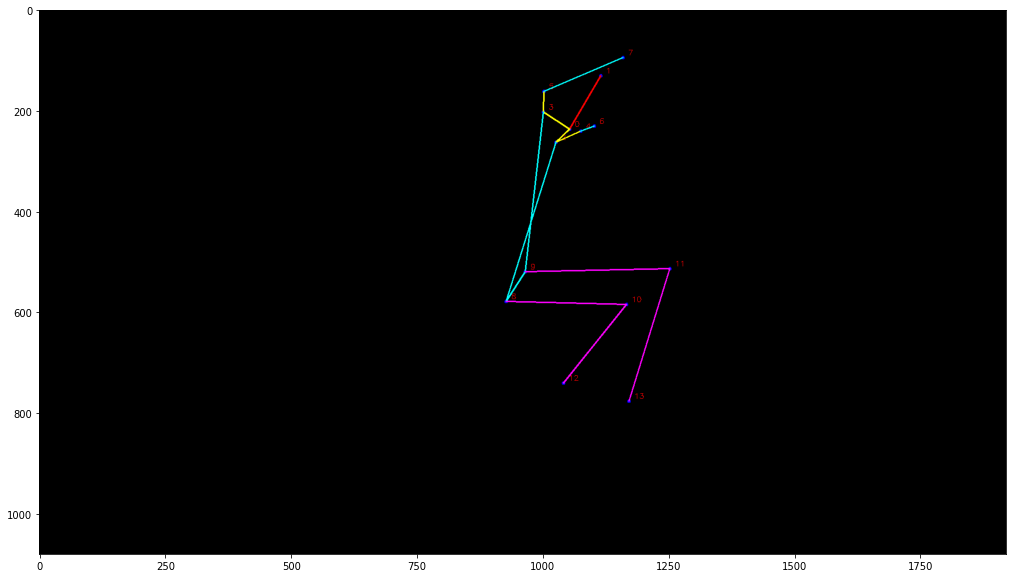

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
3 9 0


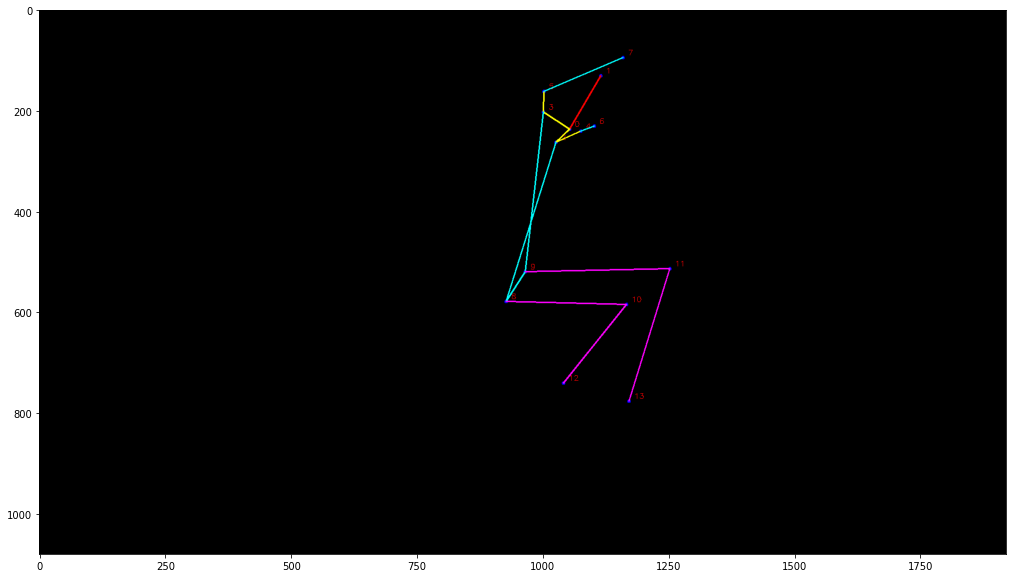

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
3 10 0


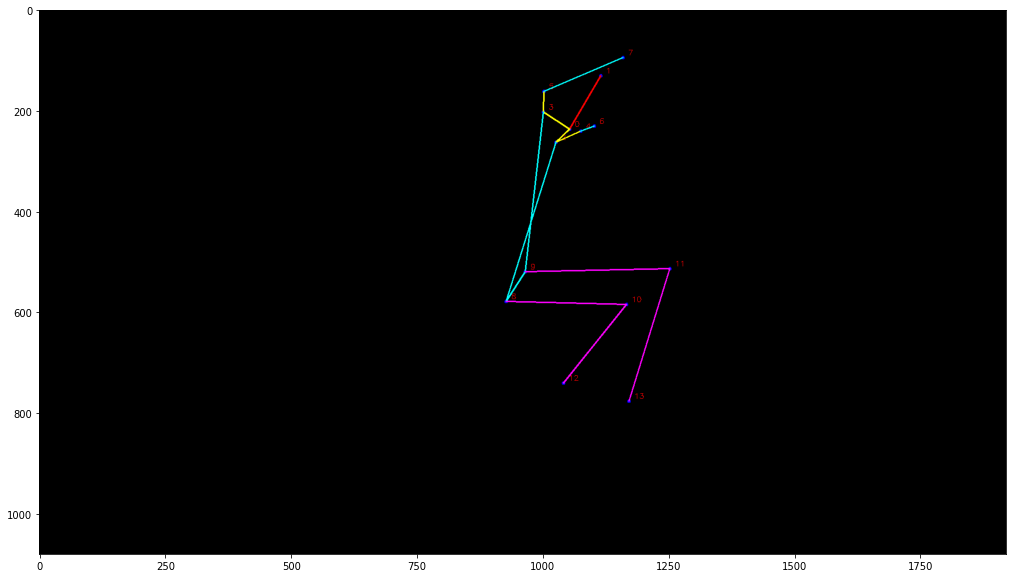

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
3 11 0


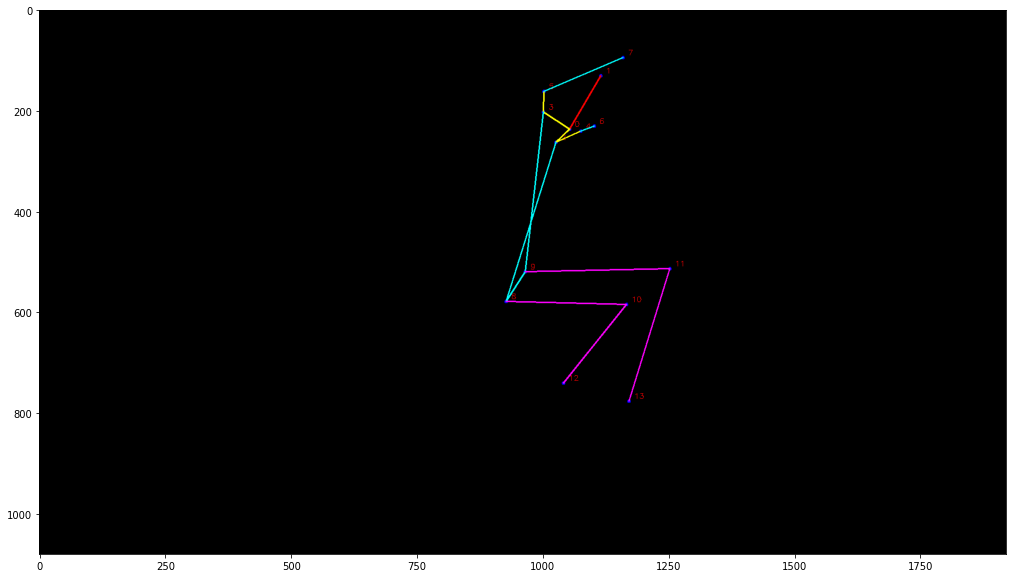

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
3 12 0


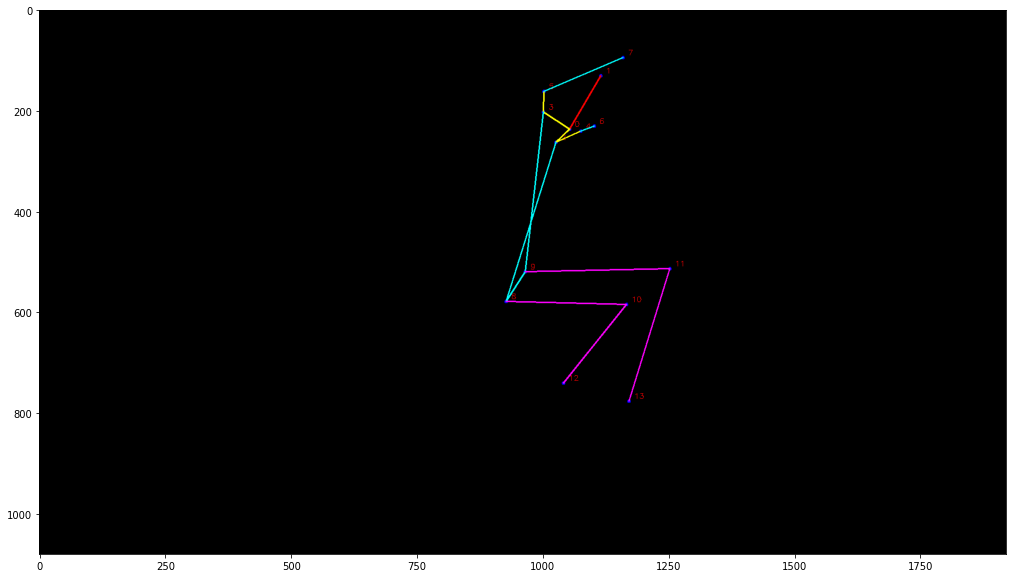

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
3 13 0


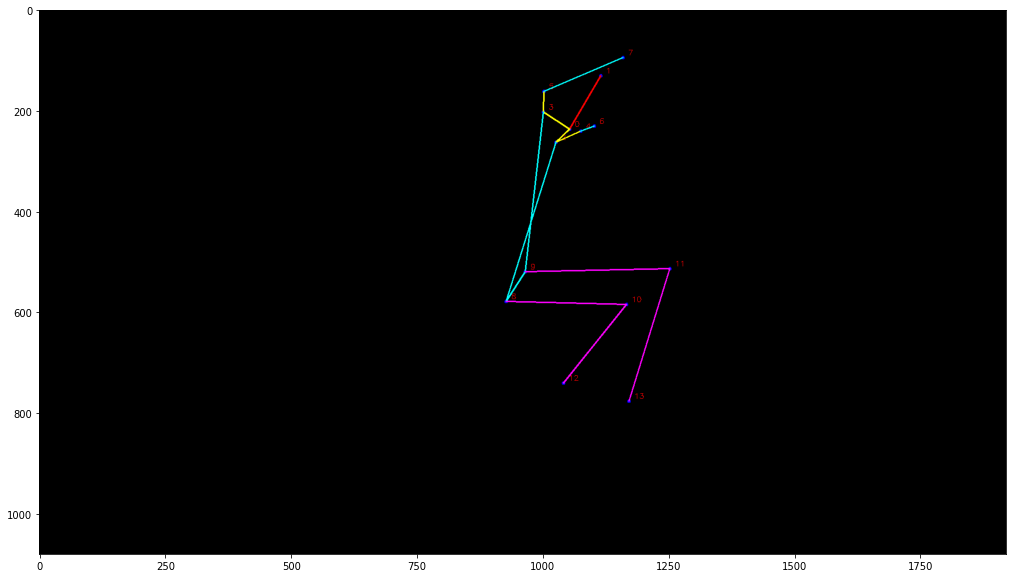

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
4 0 0


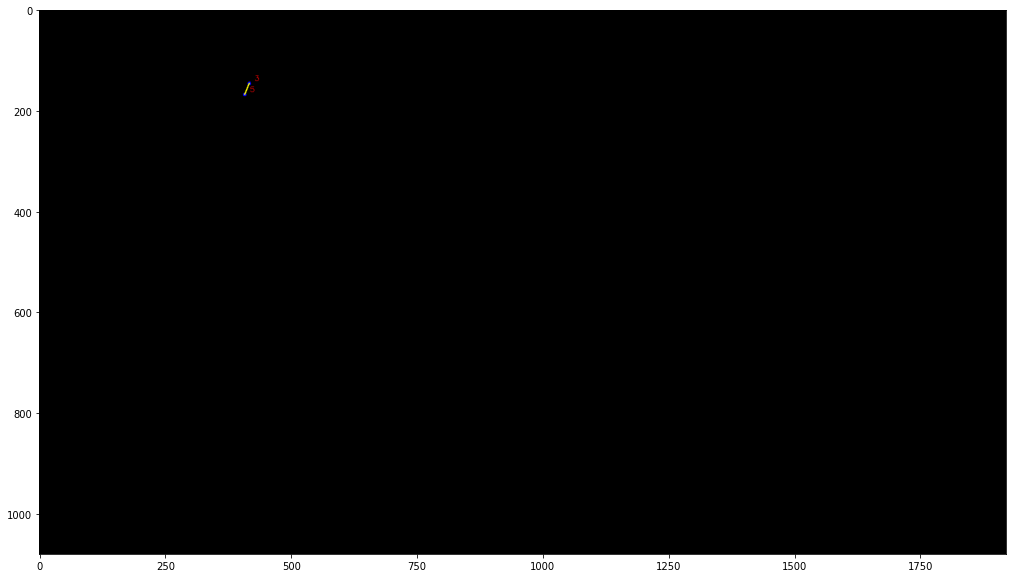

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
4 1 0


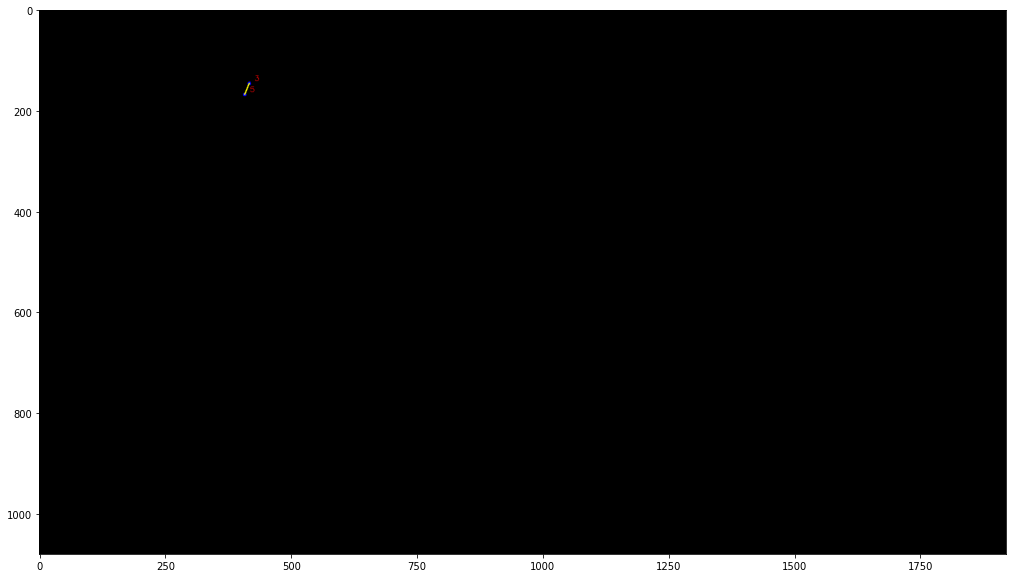

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
4 2 0


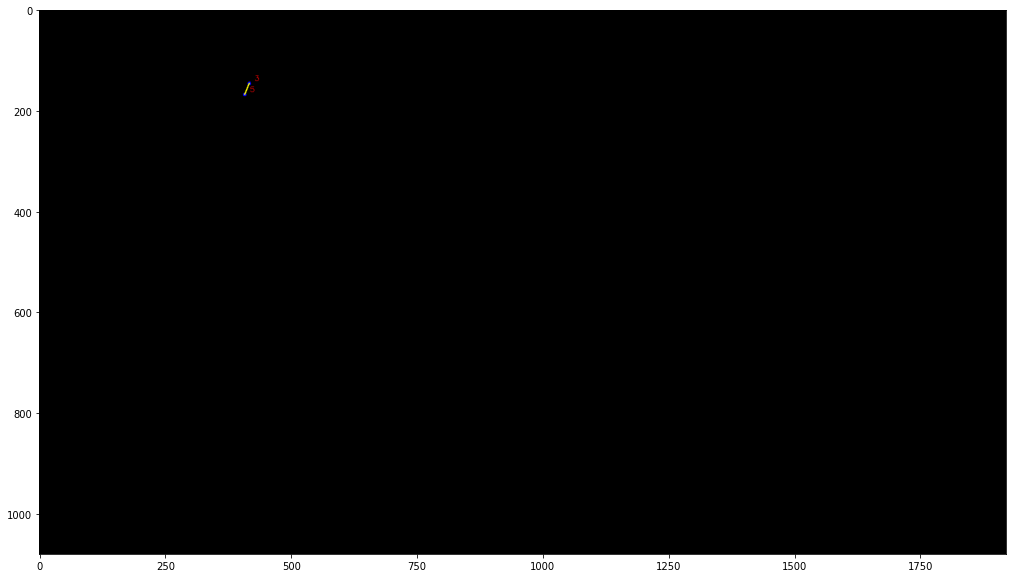

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
4 3 0


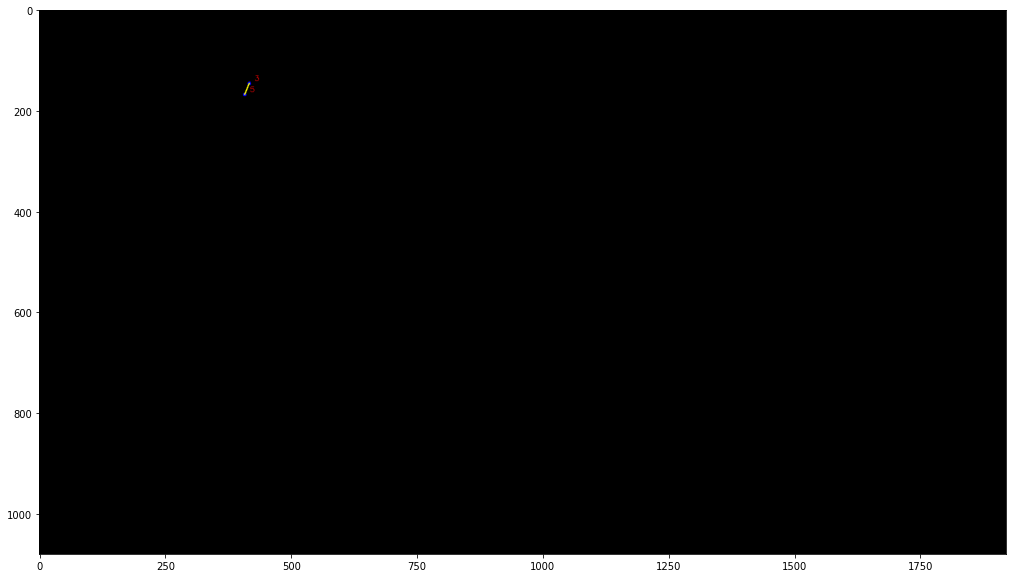

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
4 4 0


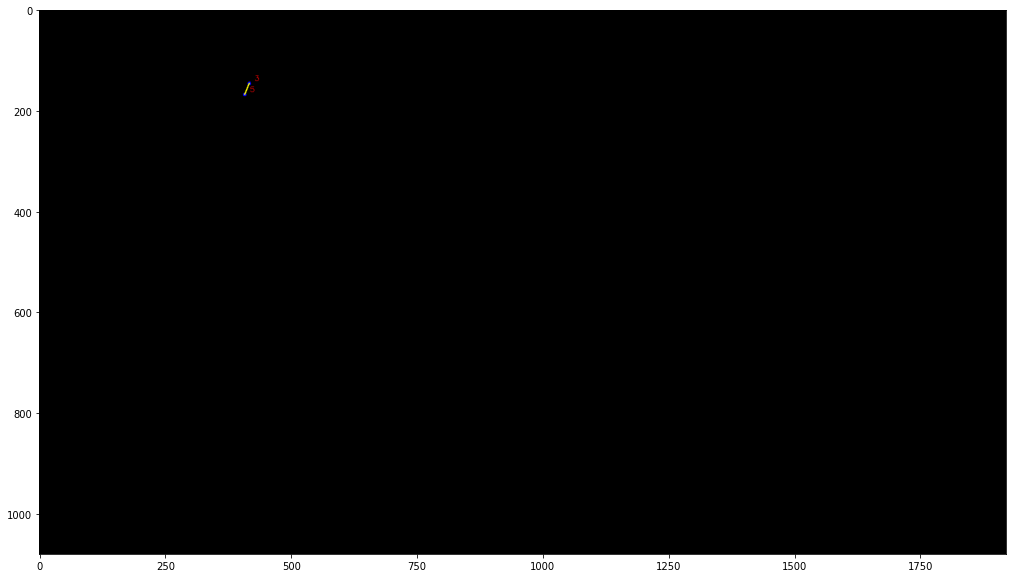

(14, 2)
4 5 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


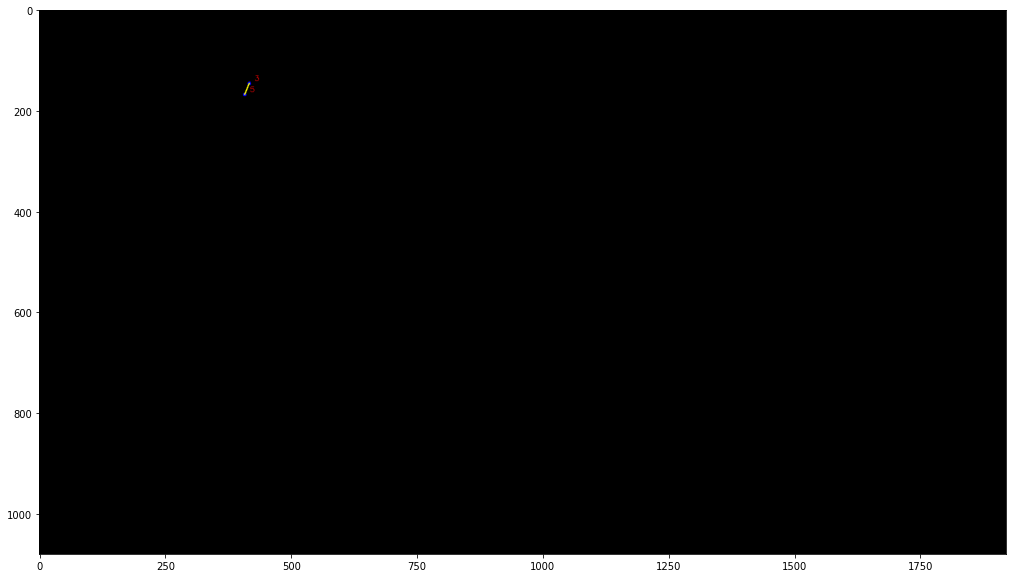

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
4 6 0


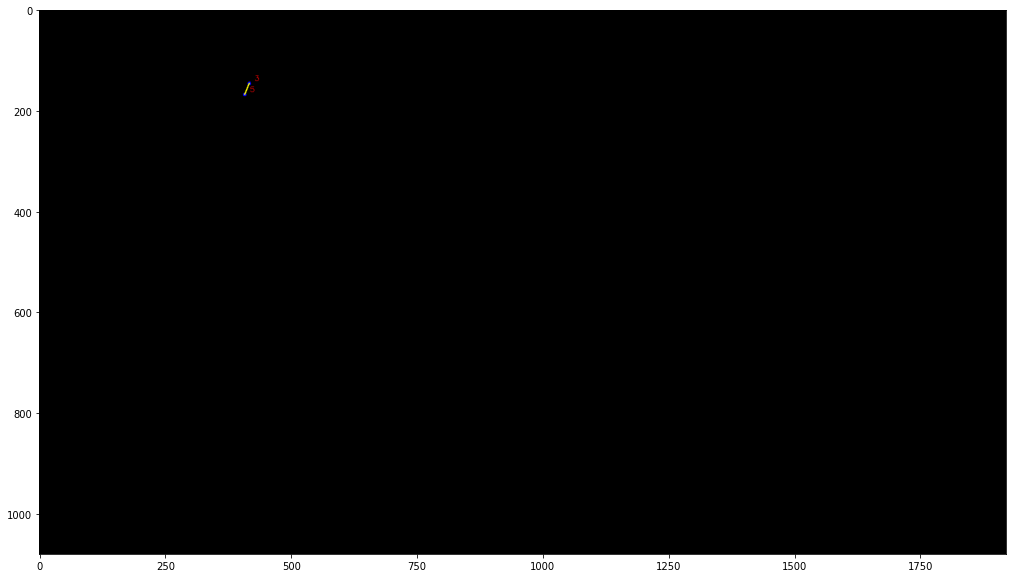

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
4 7 0


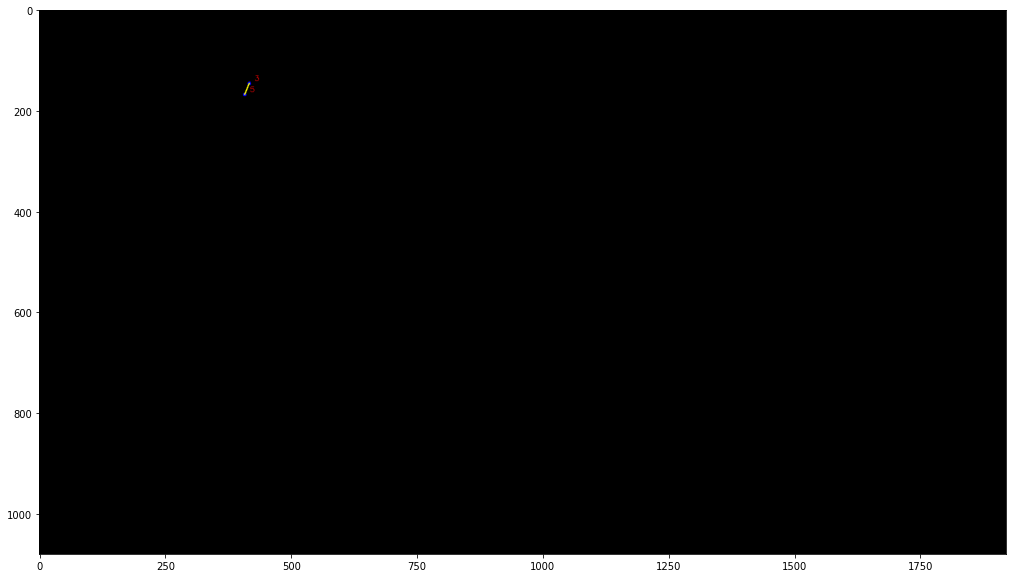

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
4 8 0


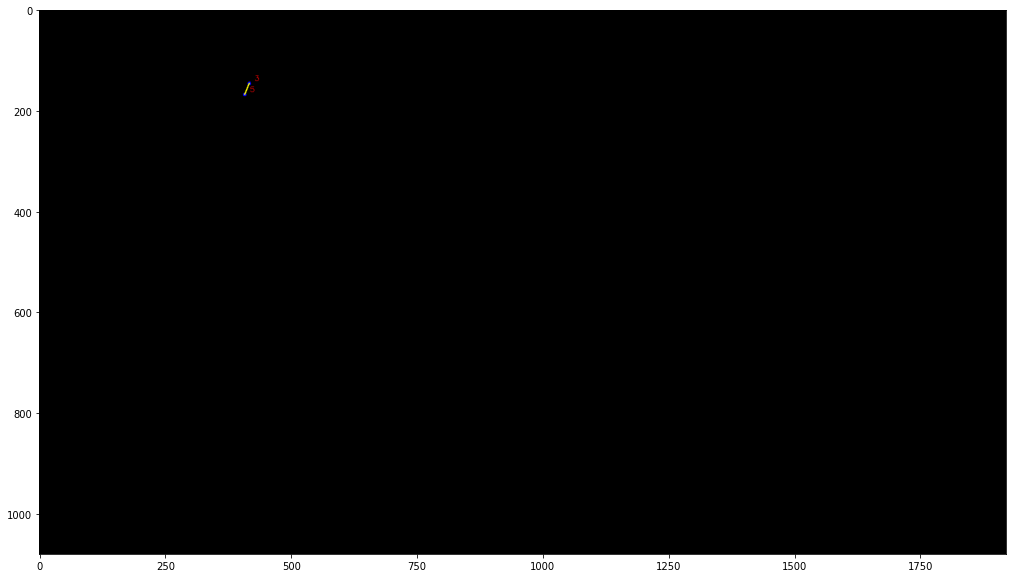

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
4 9 0


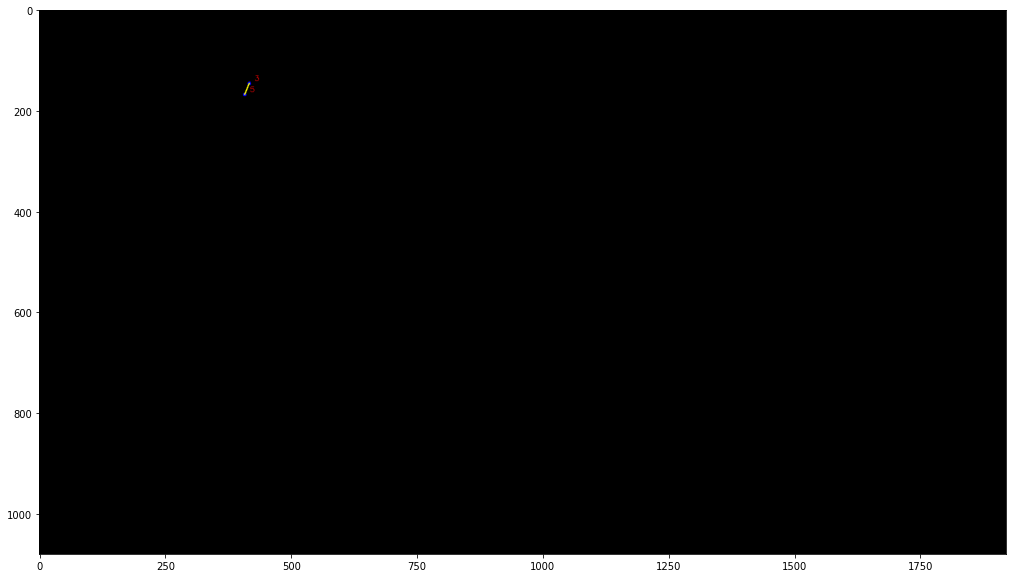

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
4 10 0


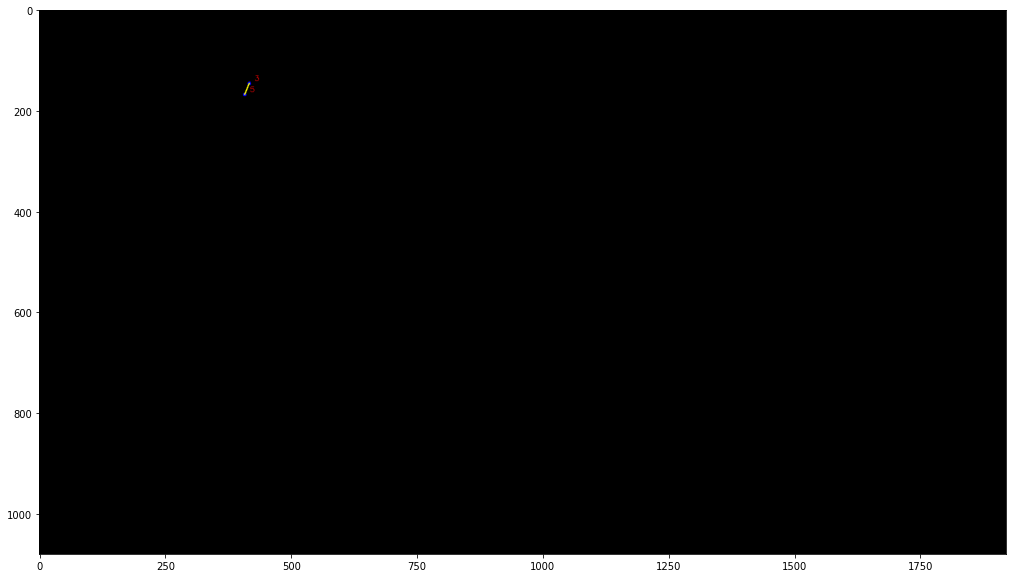

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
4 11 0


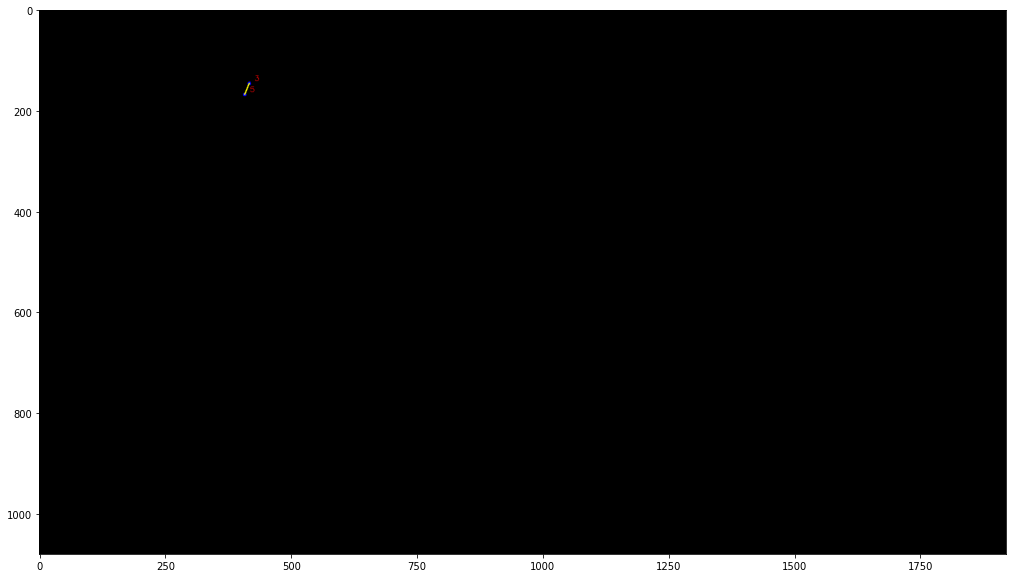

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
4 12 0


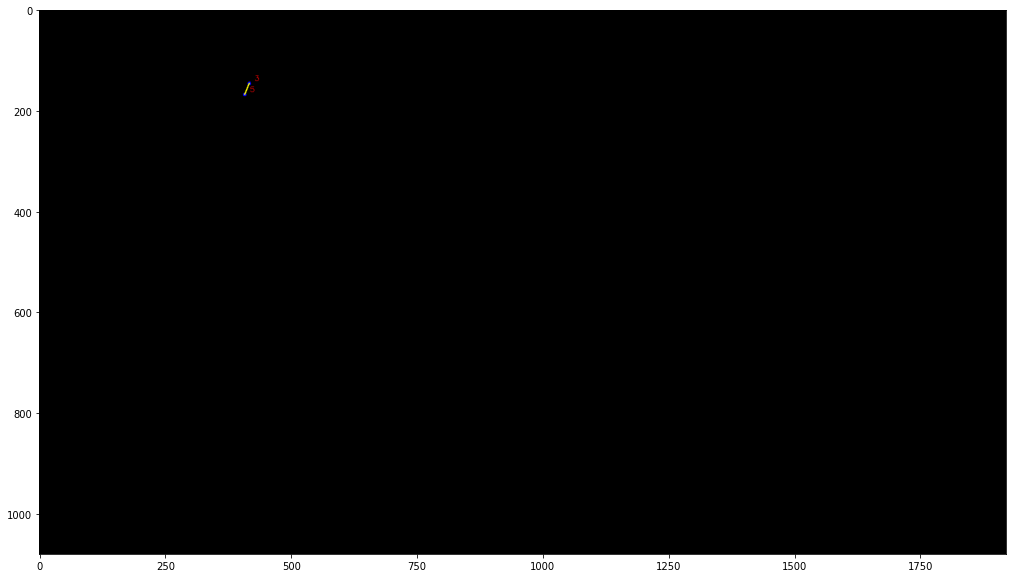

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
4 13 0


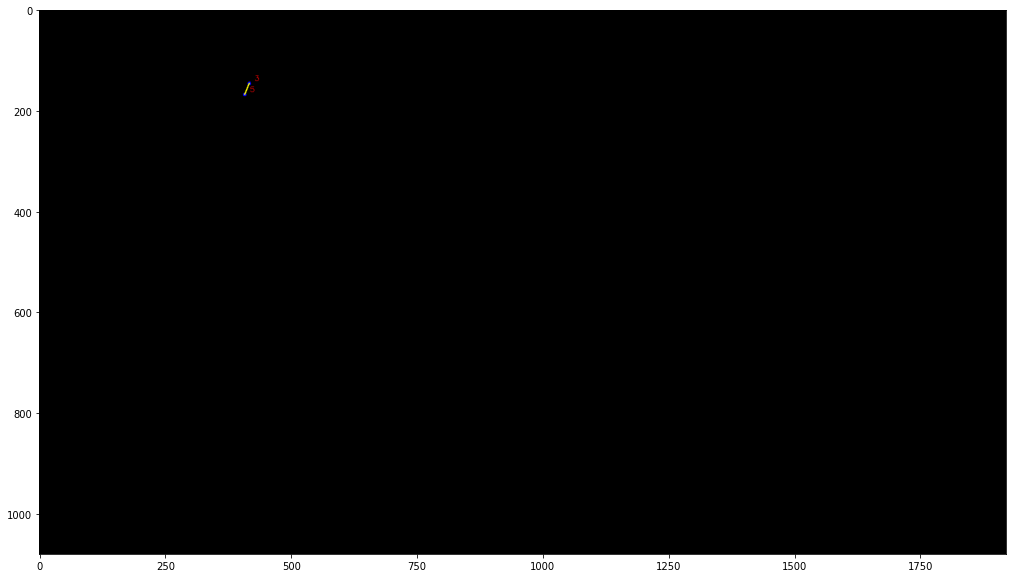

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
5 0 0


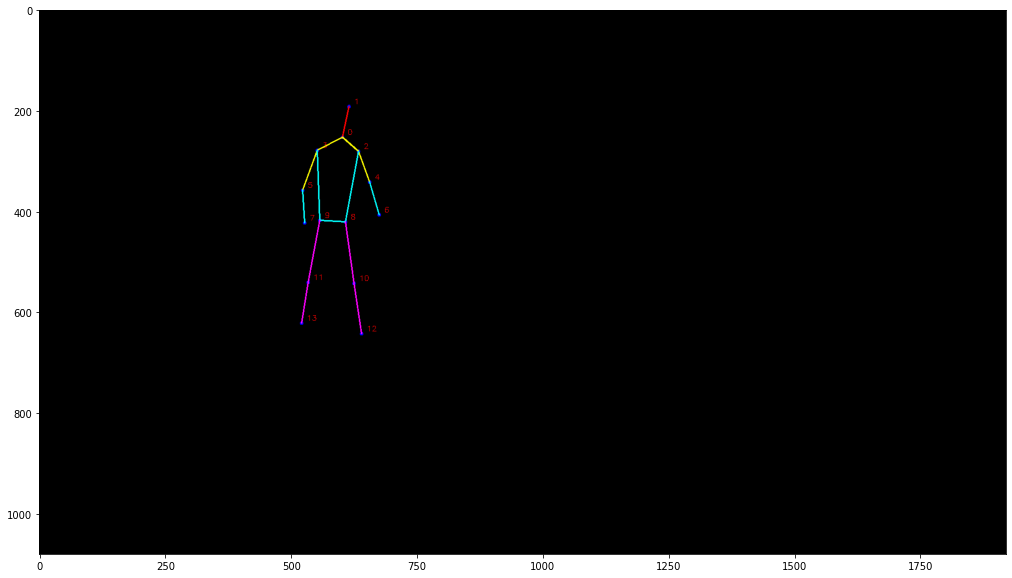

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
5 1 0


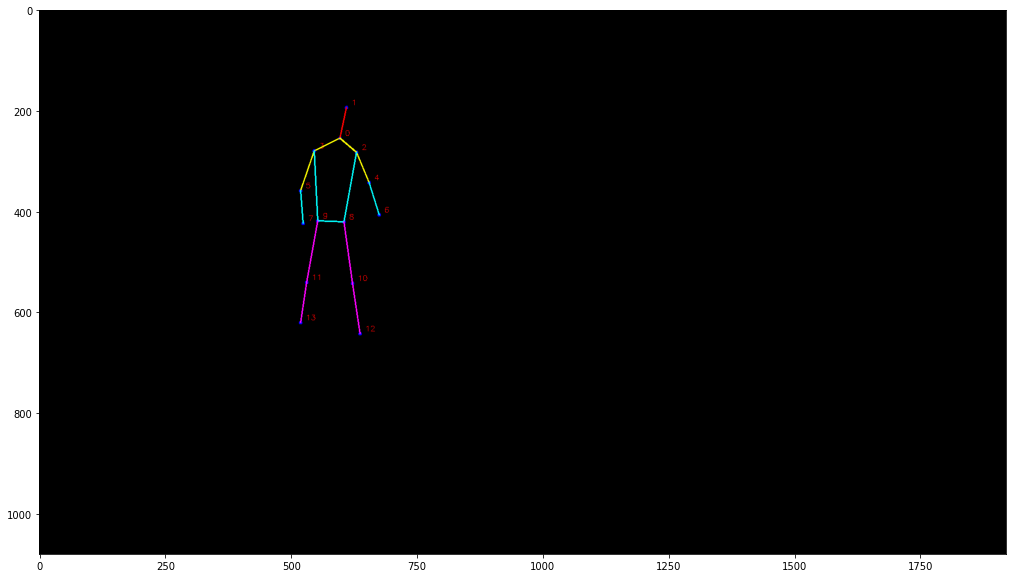

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
5 2 0


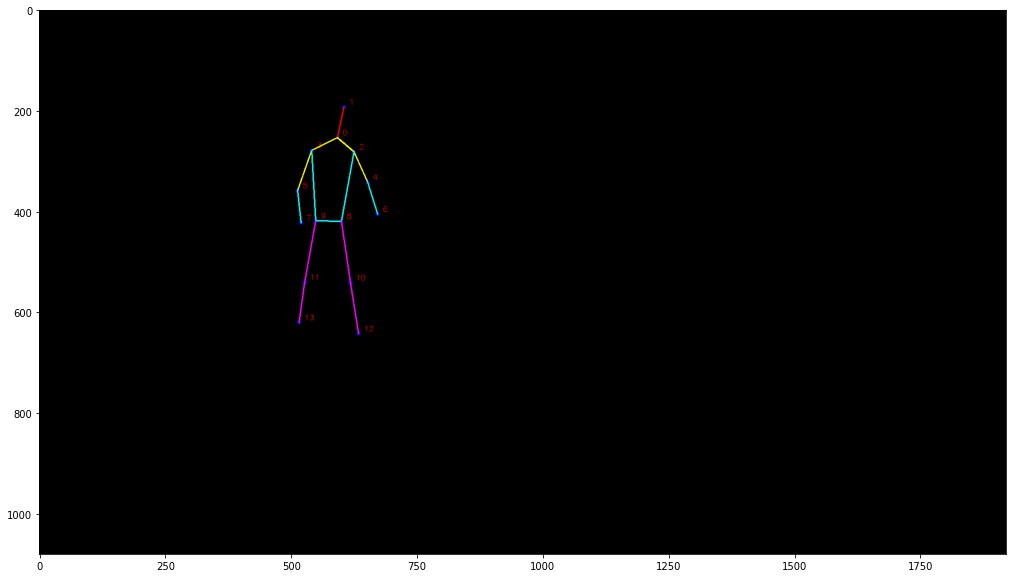

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
5 3 0


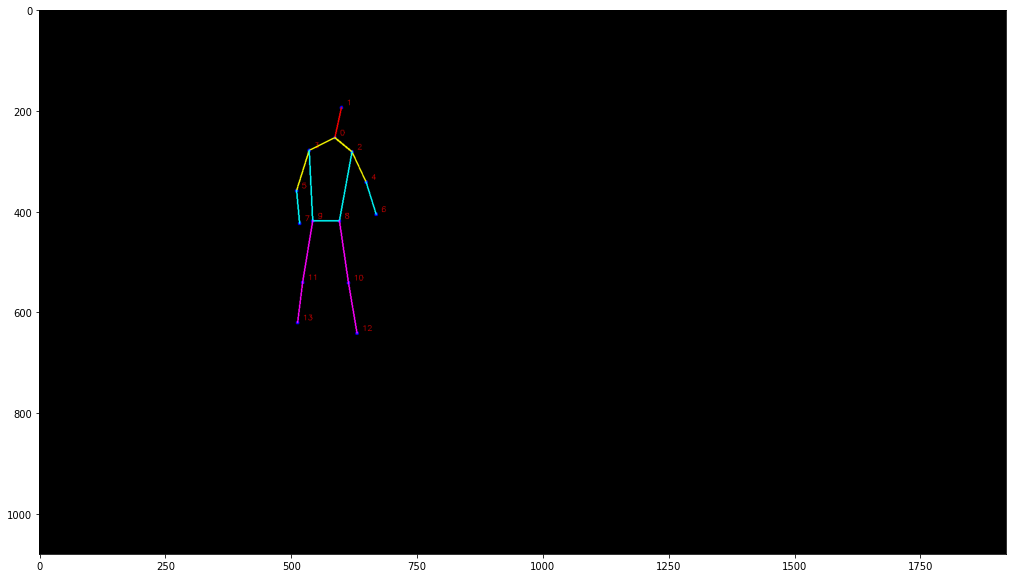

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
5 4 0


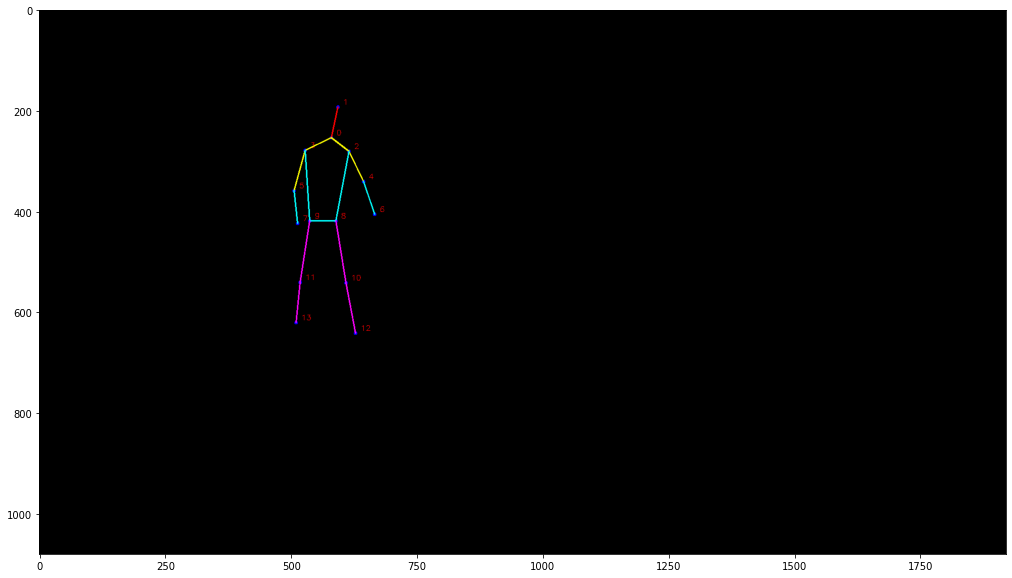

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
5 5 0


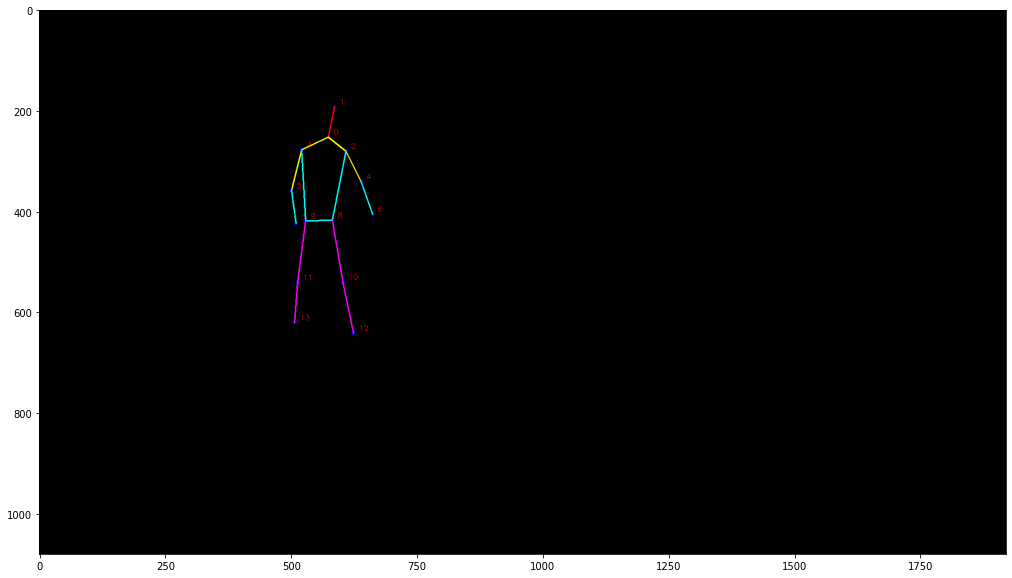

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
5 6 0


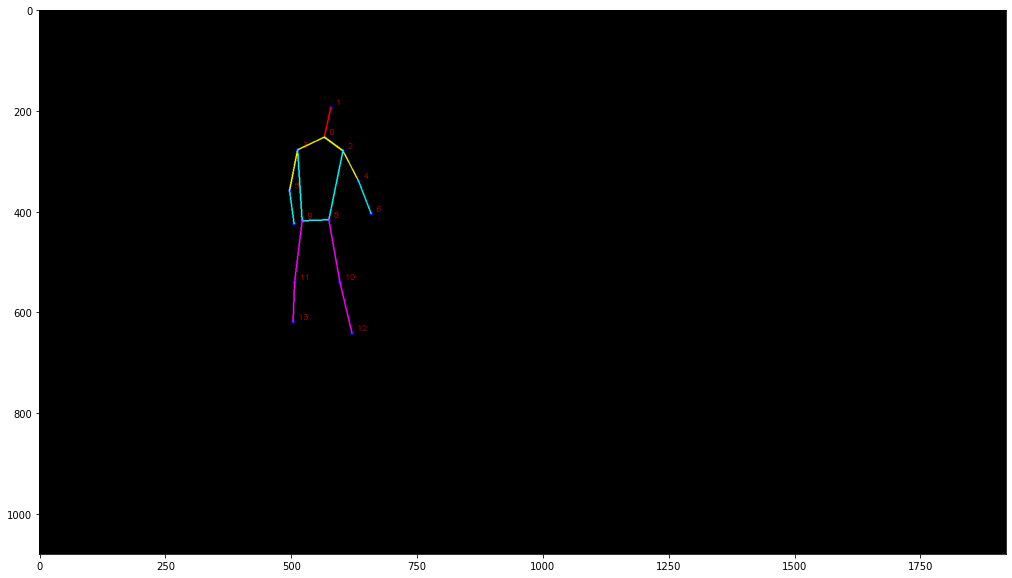

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
5 7 0


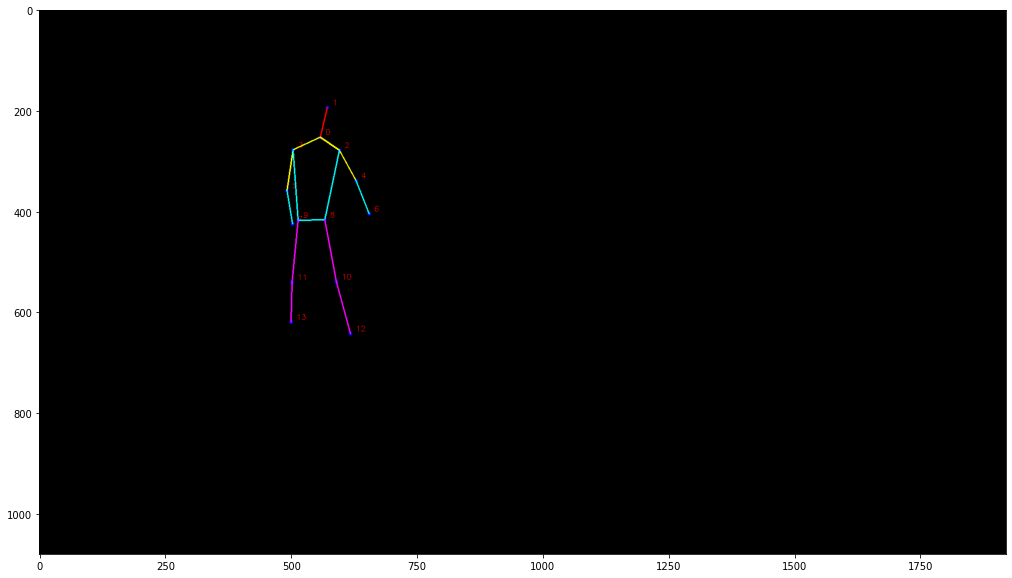

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
5 8 0


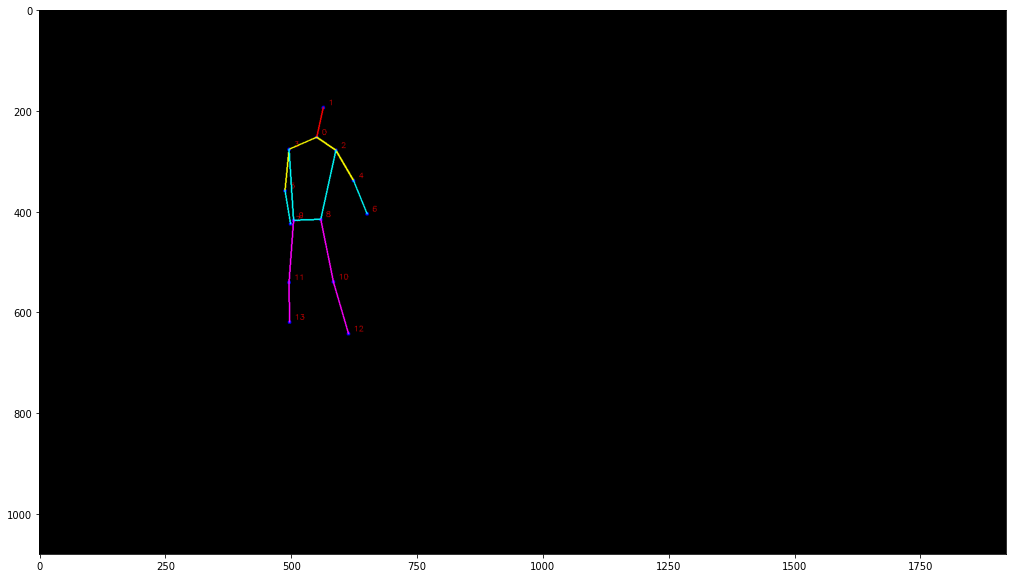

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
5 9 0


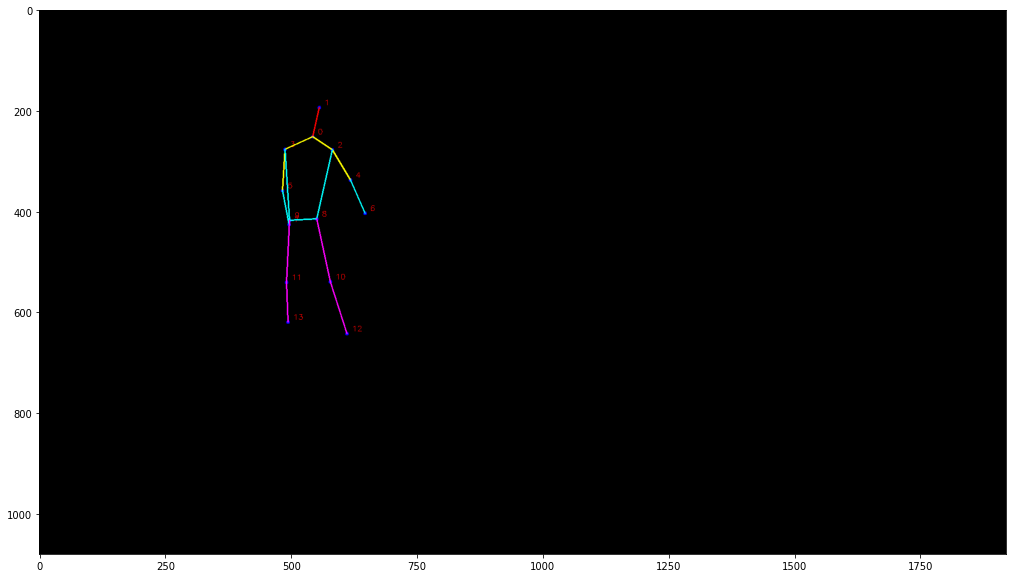

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
5 10 0


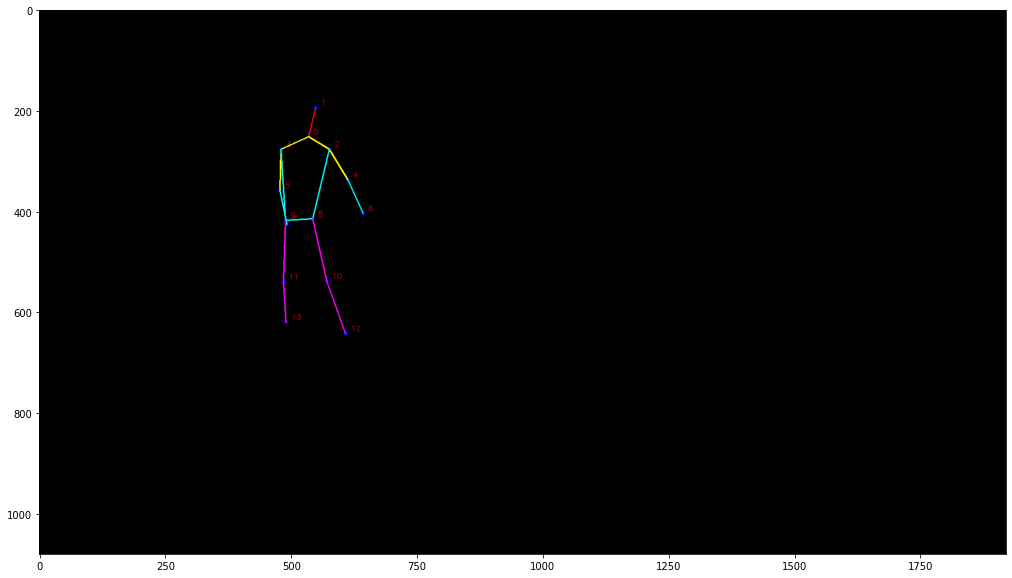

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
5 11 0


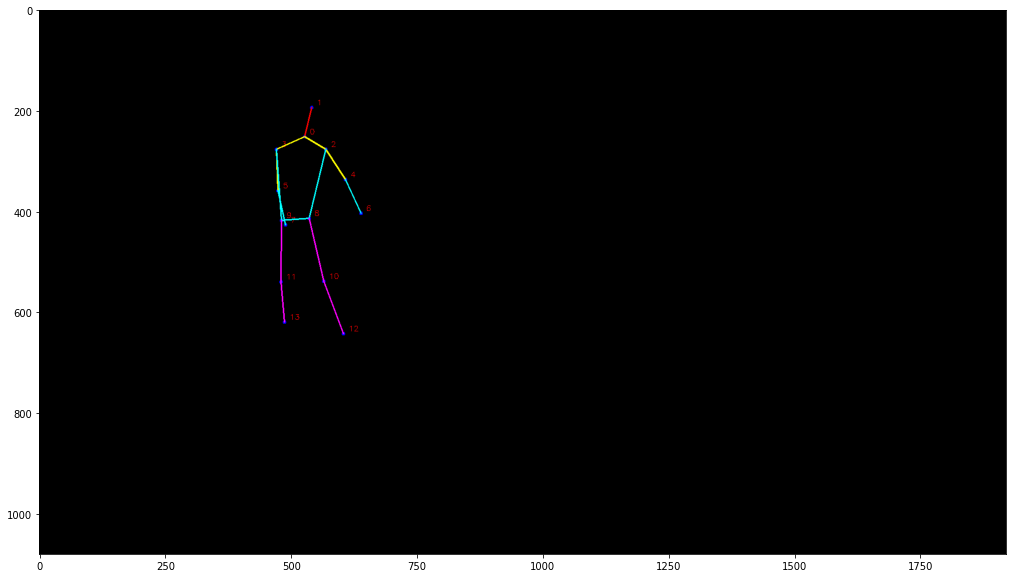

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
5 12 0


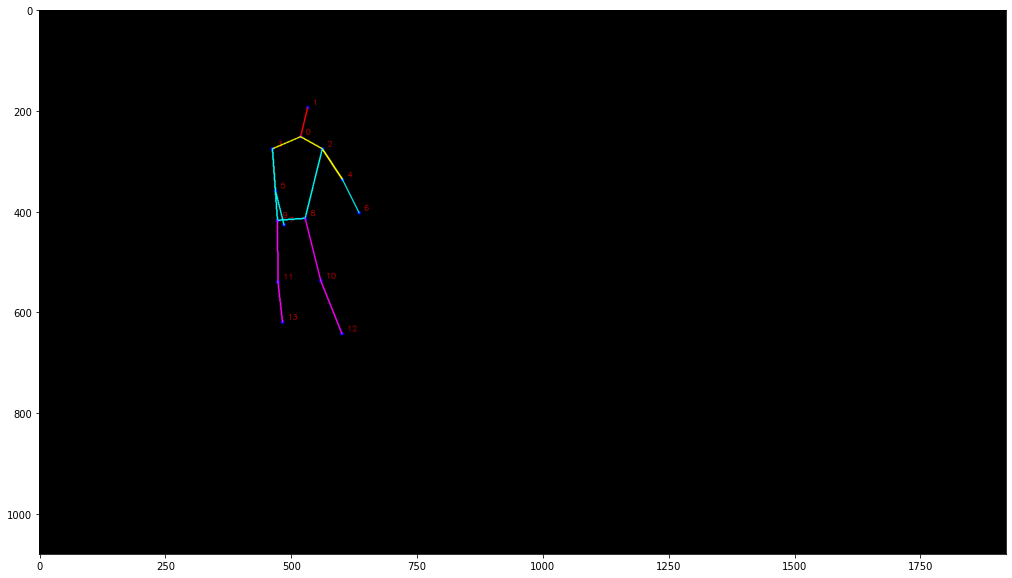

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
5 13 0


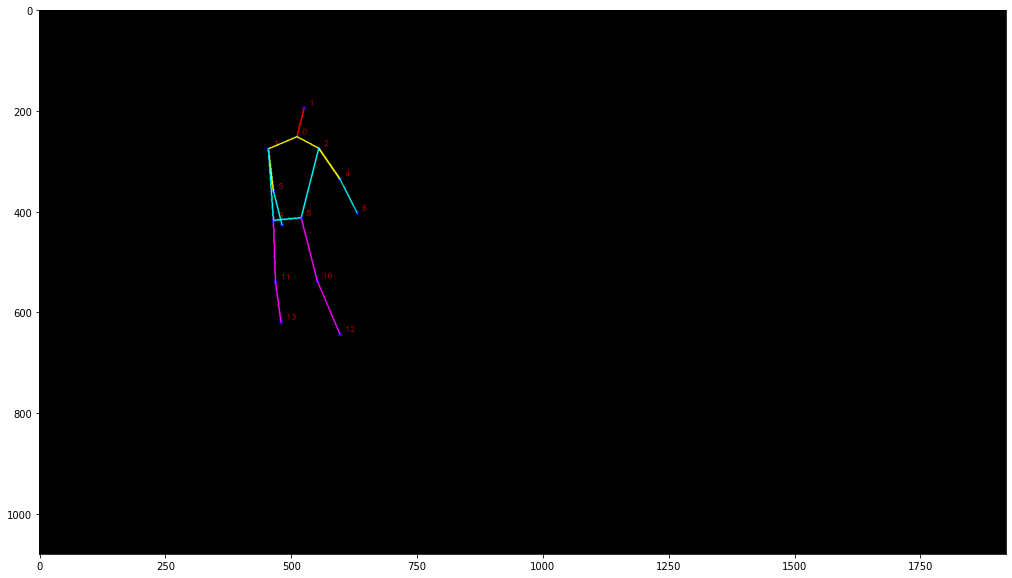

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
6 0 0


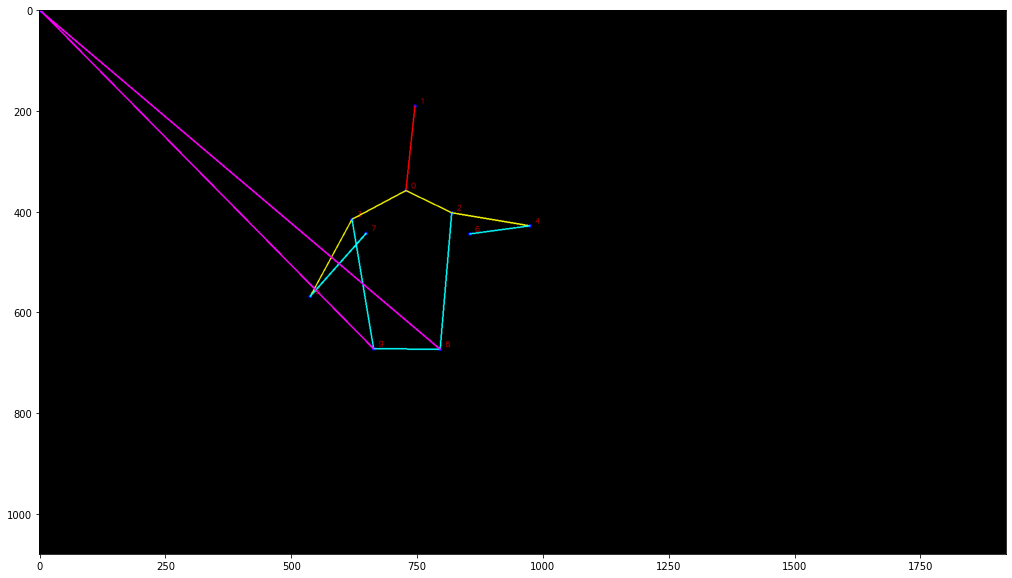

(14, 2)
6 1 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


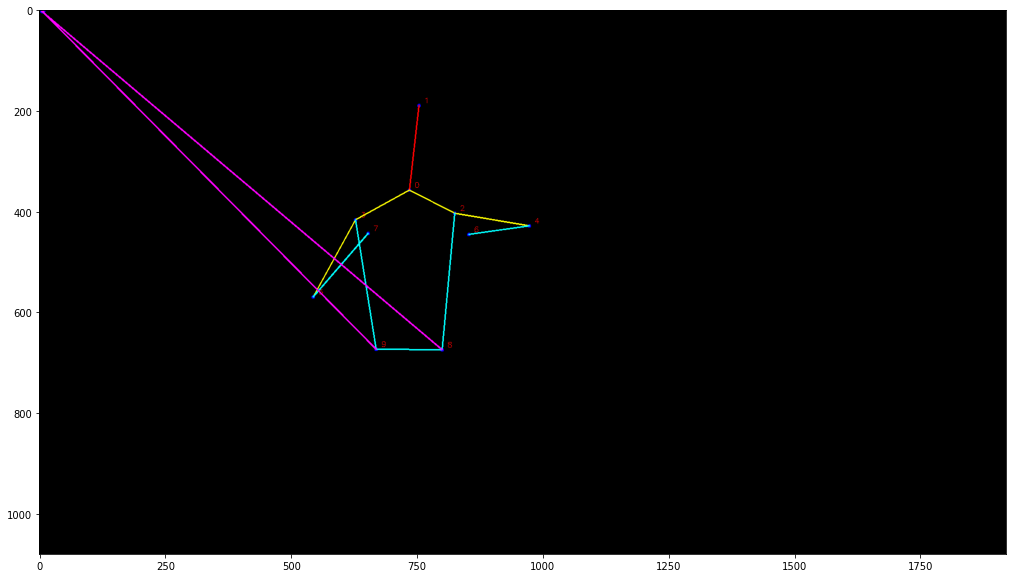

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
6 2 0


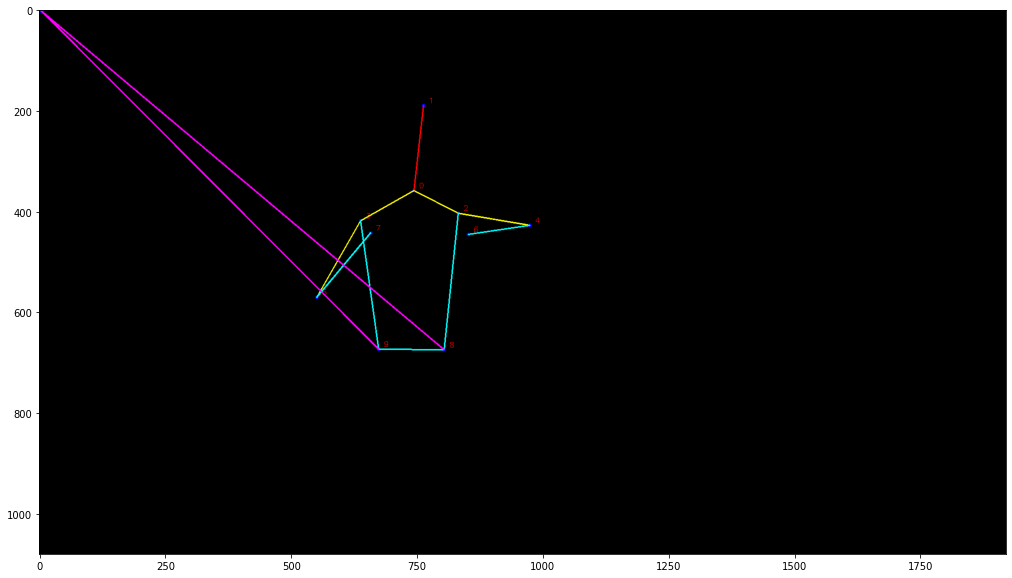

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
6 3 0


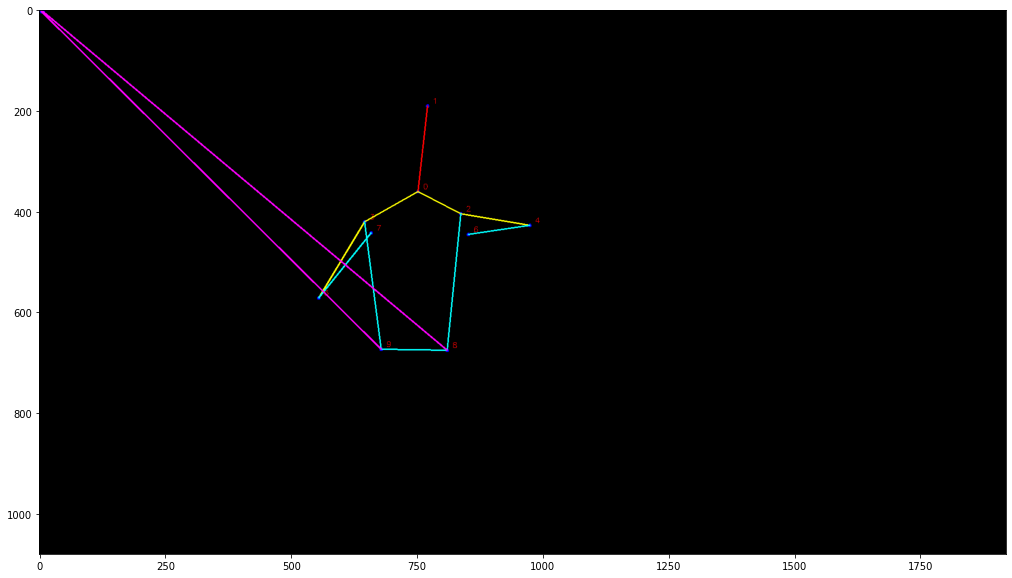

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
6 4 0


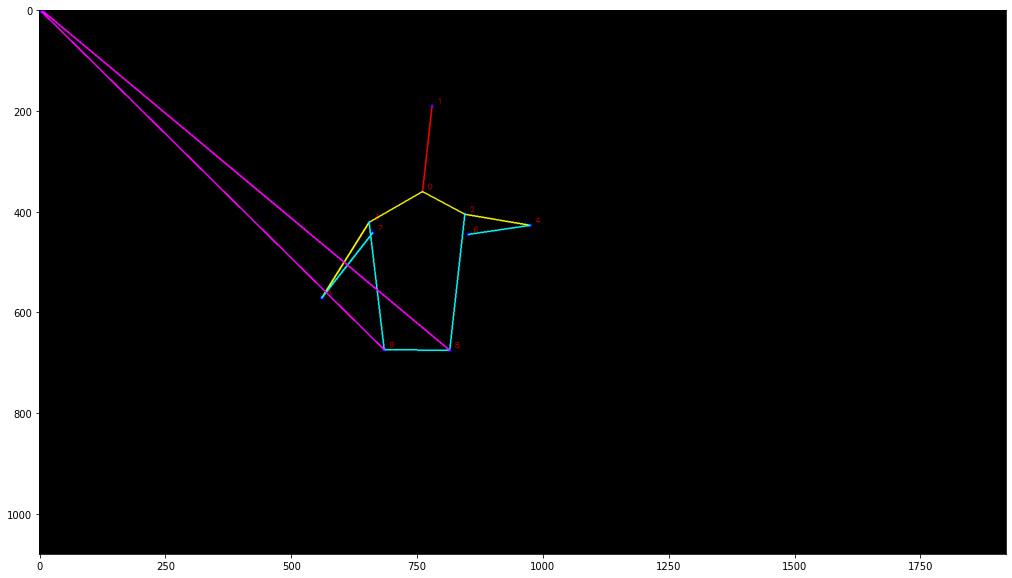

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
6 5 0


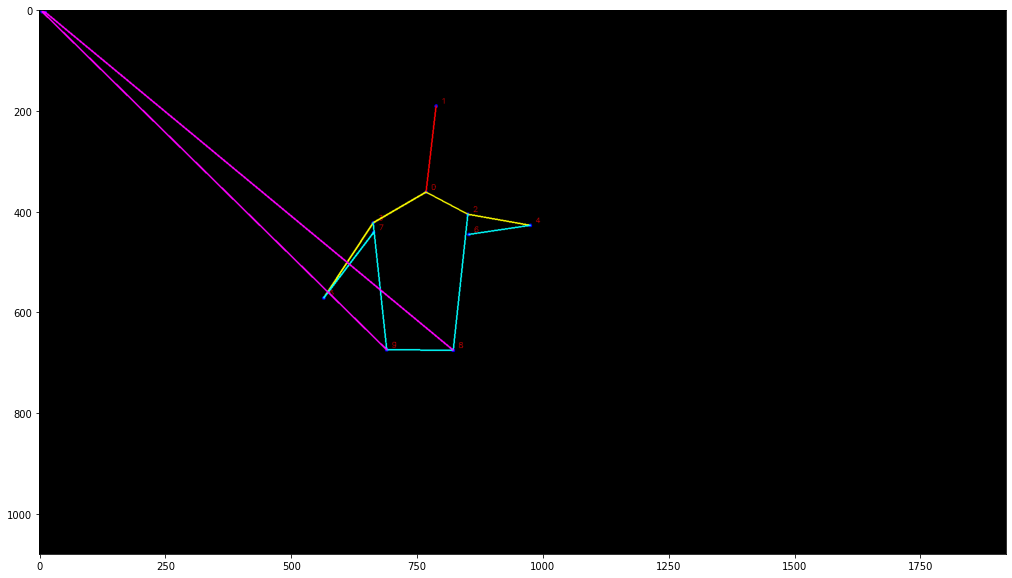

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
6 6 0


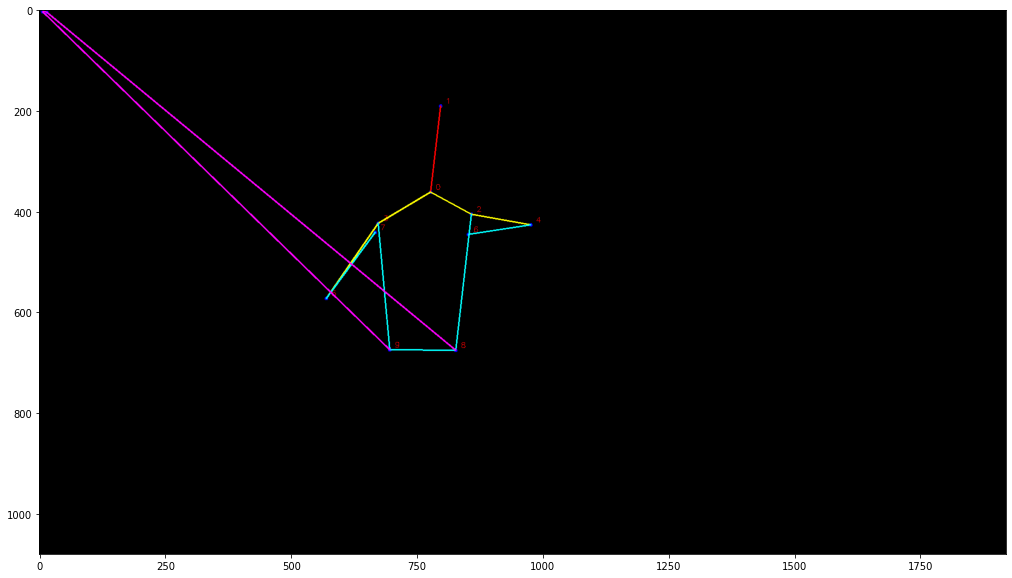

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
6 7 0


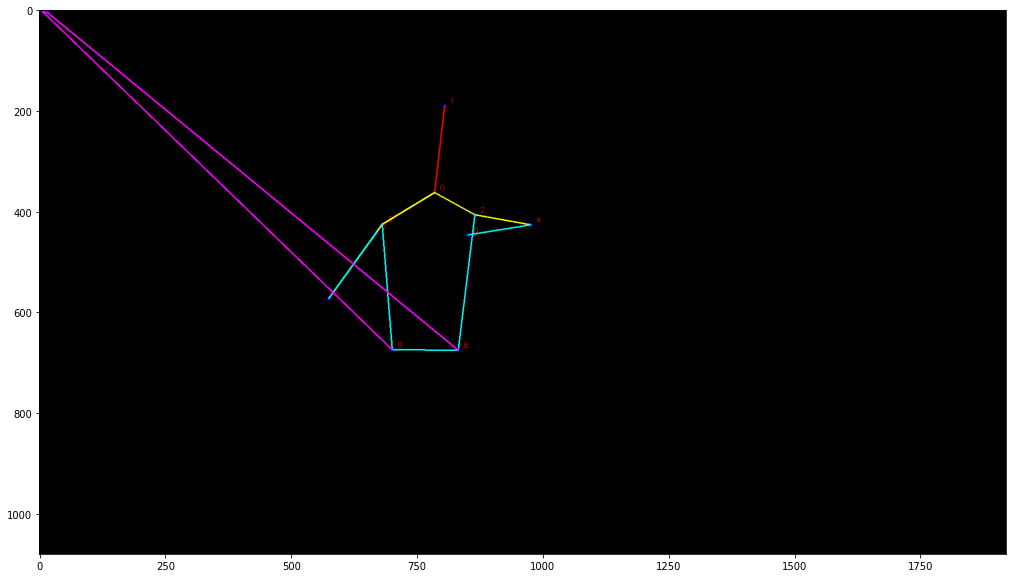

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
6 8 0


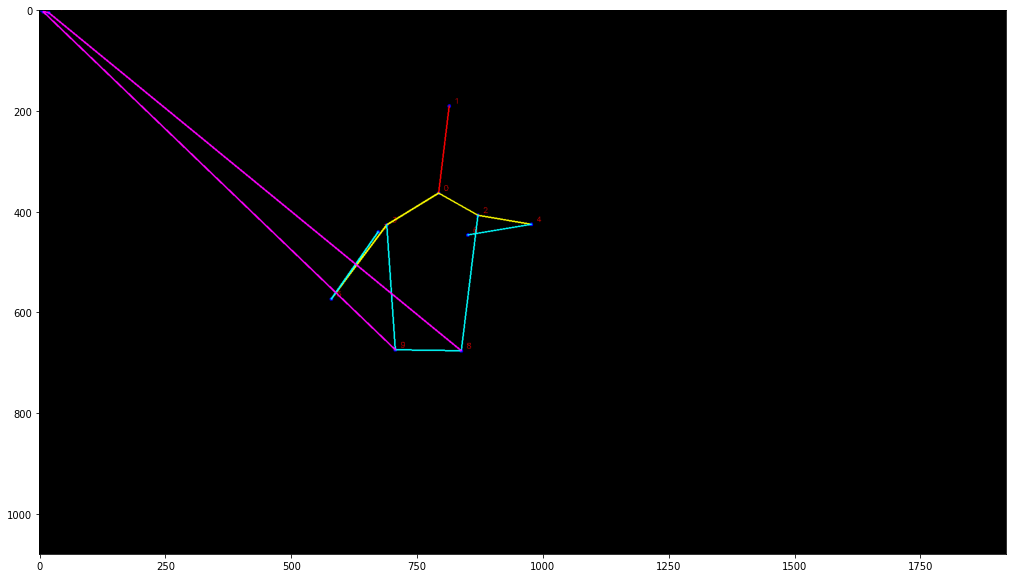

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
6 9 0


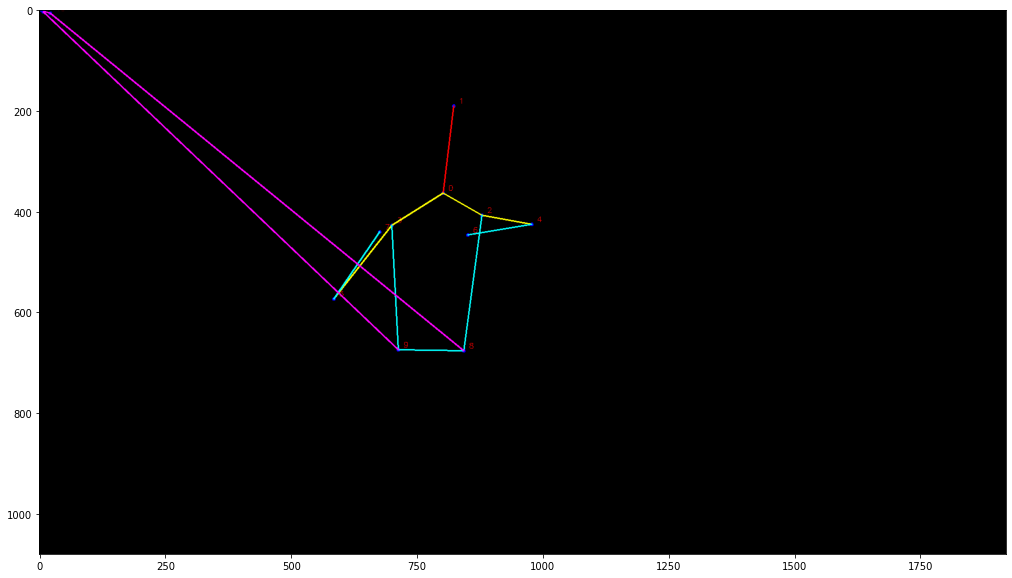

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
6 10 0


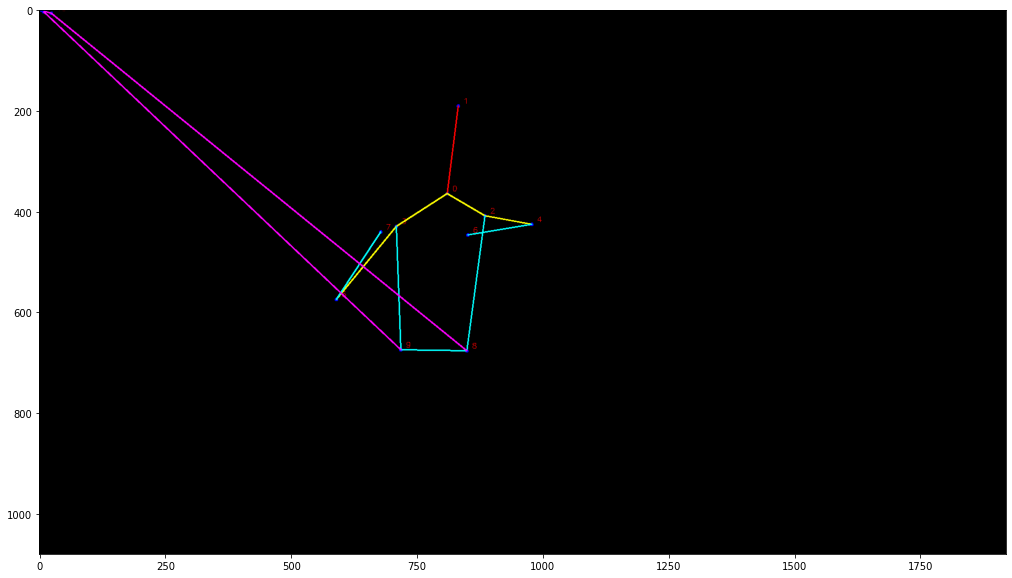

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
6 11 0


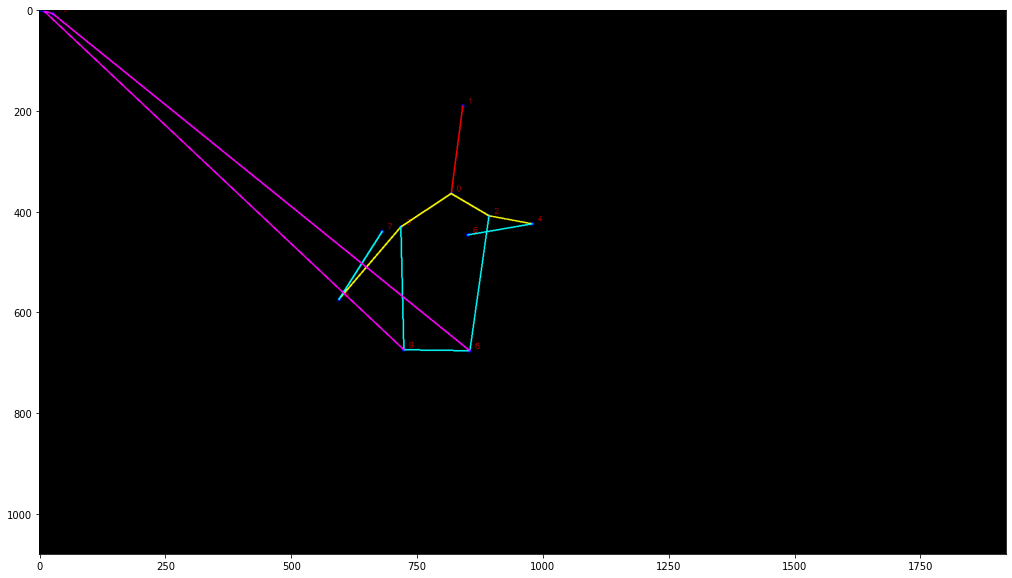

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
6 12 0


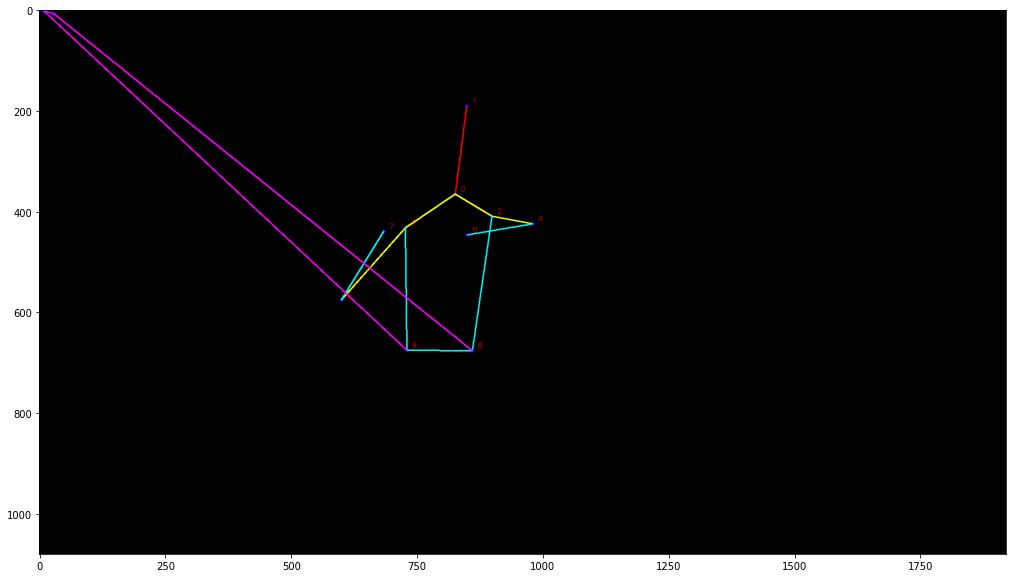

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
6 13 0


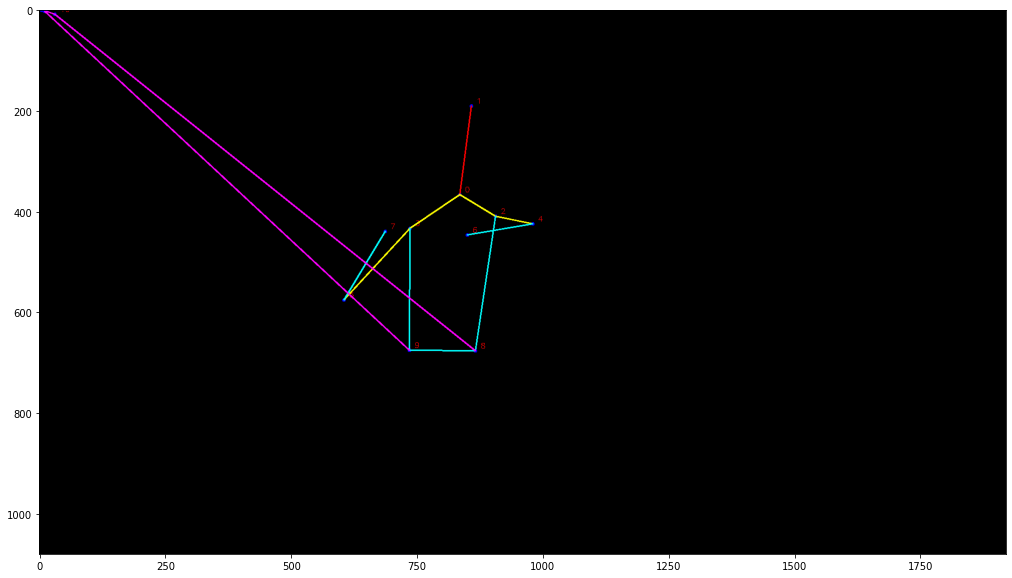

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
7 0 0


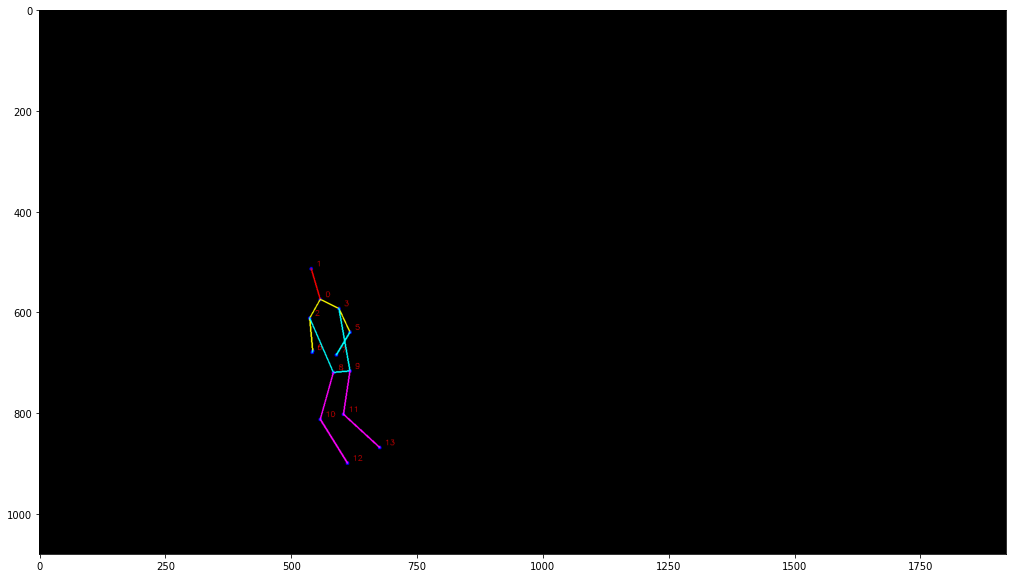

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
7 1 0


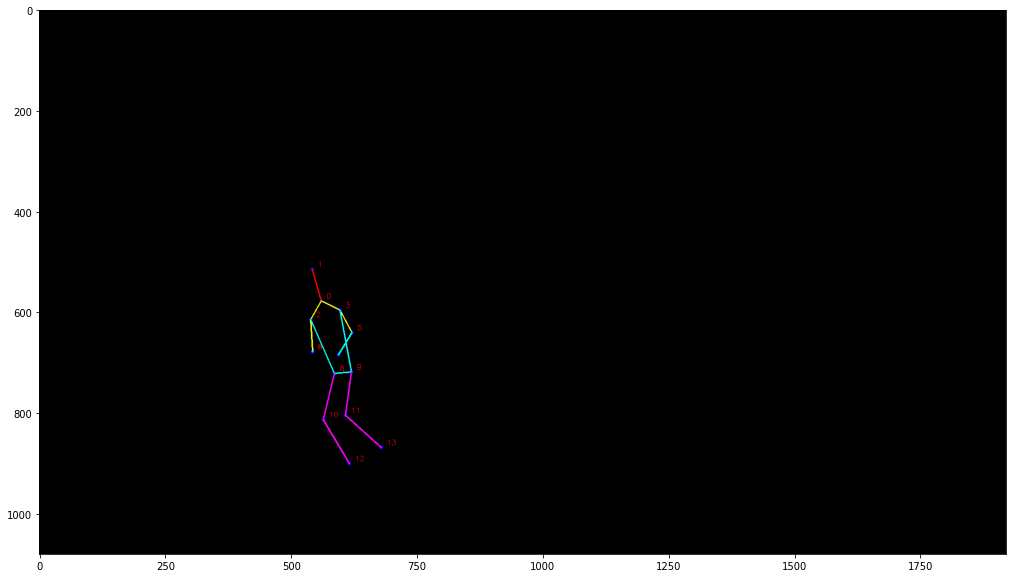

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
7 2 0


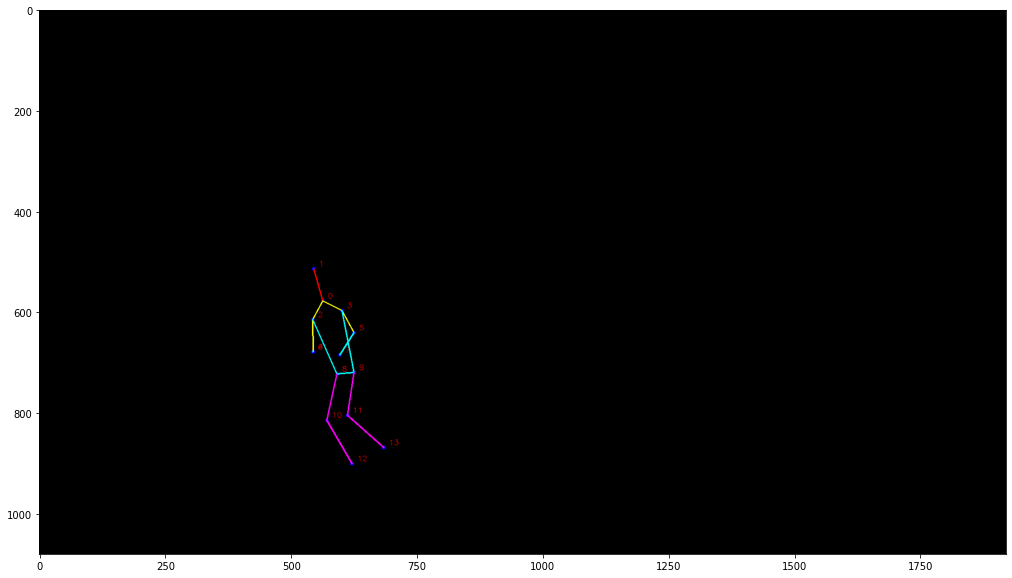

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
7 3 0


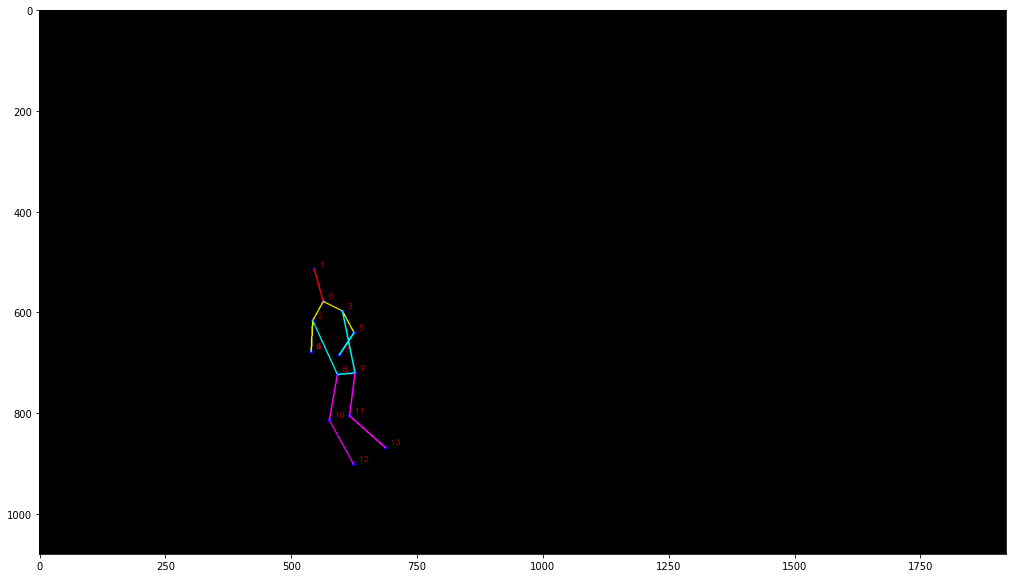

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
7 4 0


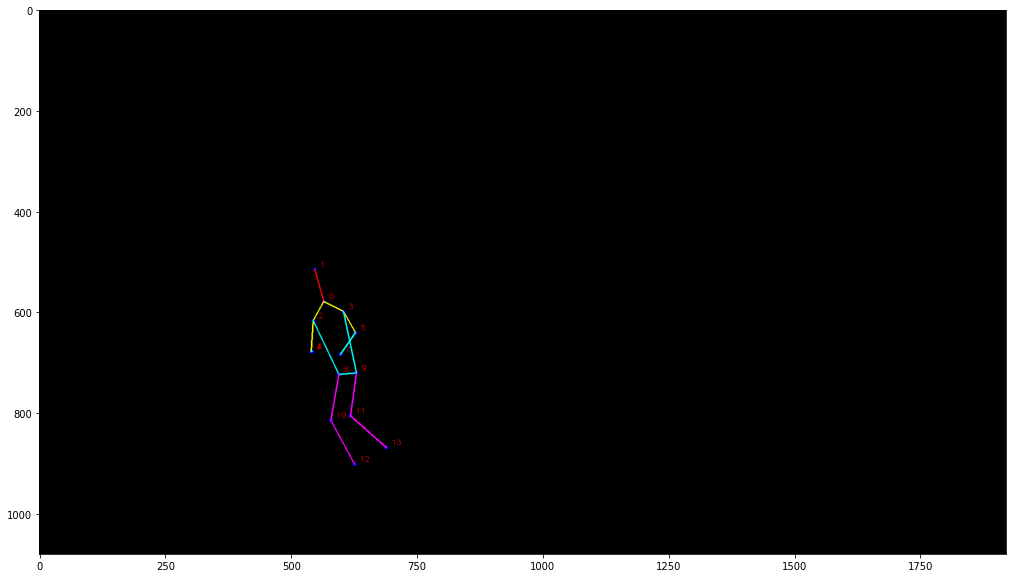

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
7 5 0


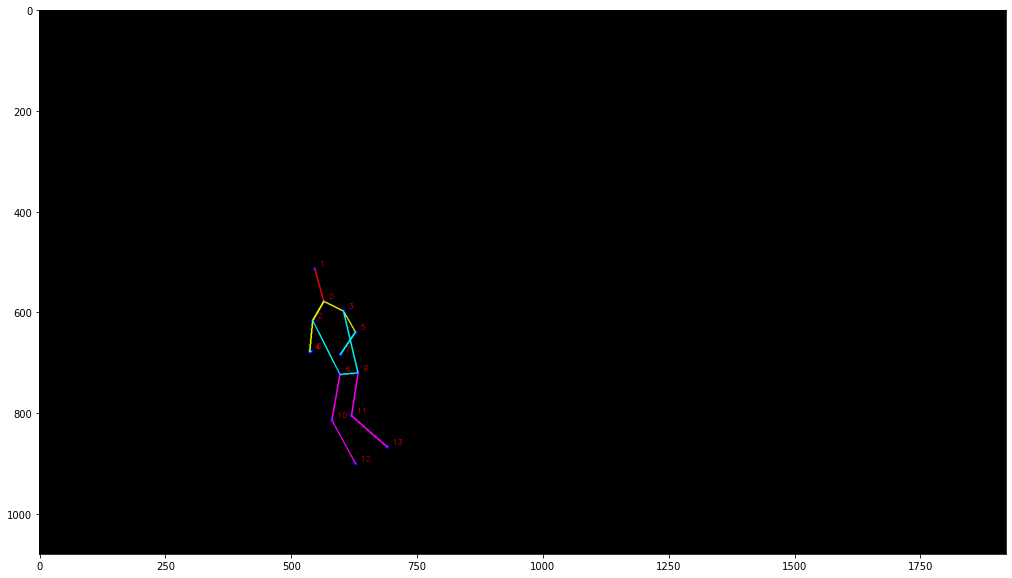

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
7 6 0


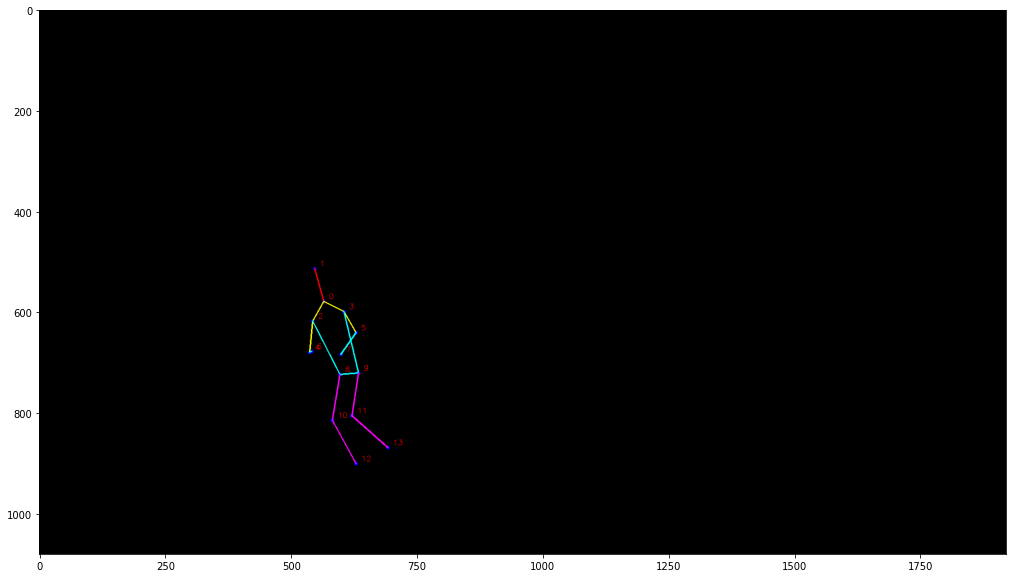

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
7 7 0


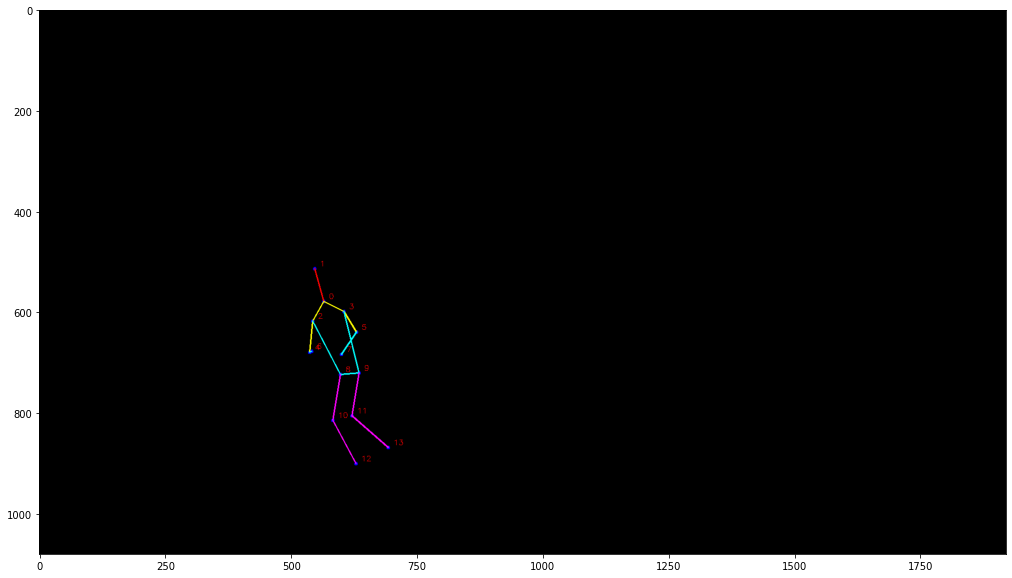

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
7 8 0


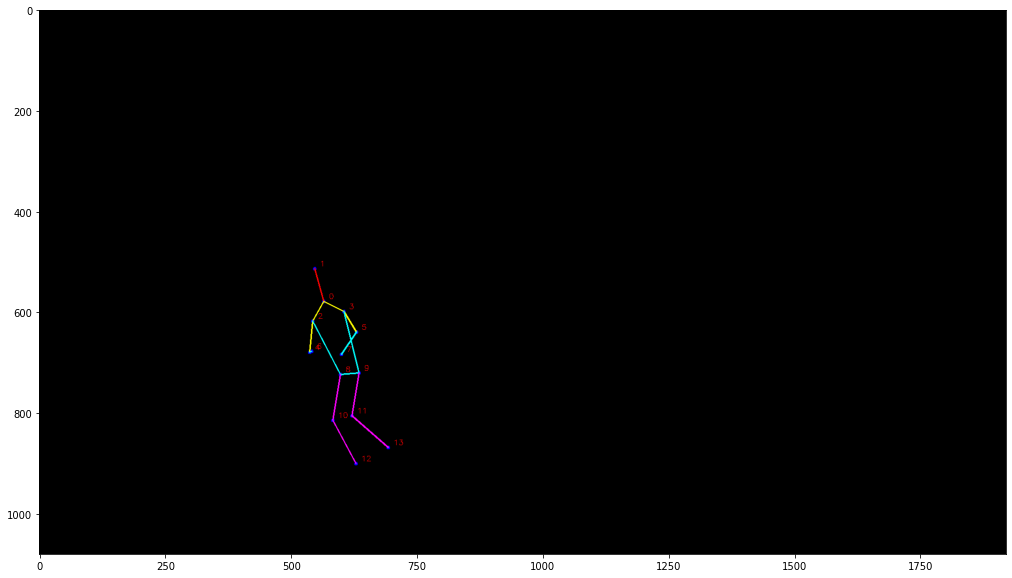

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
7 9 0


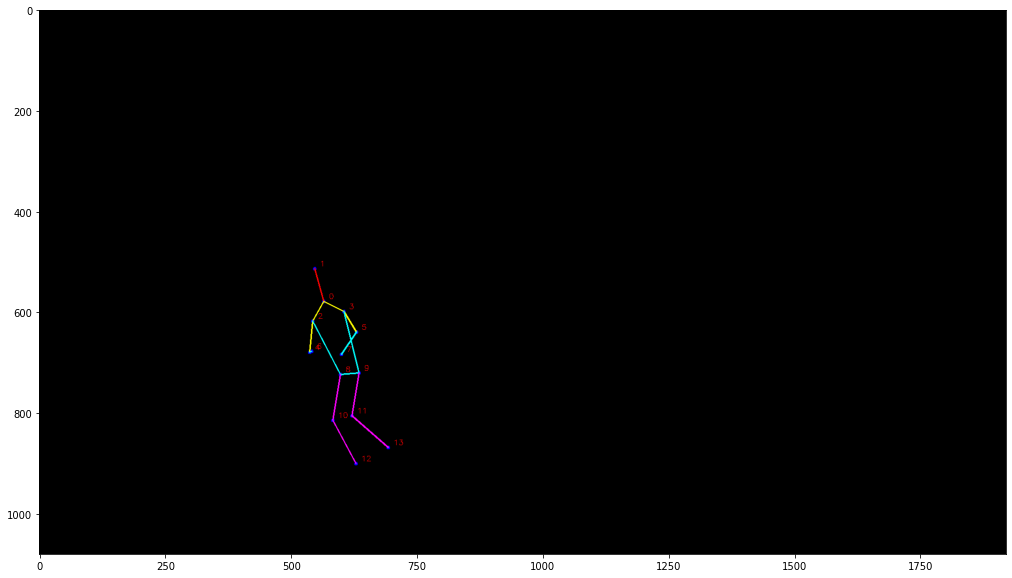

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
7 10 0


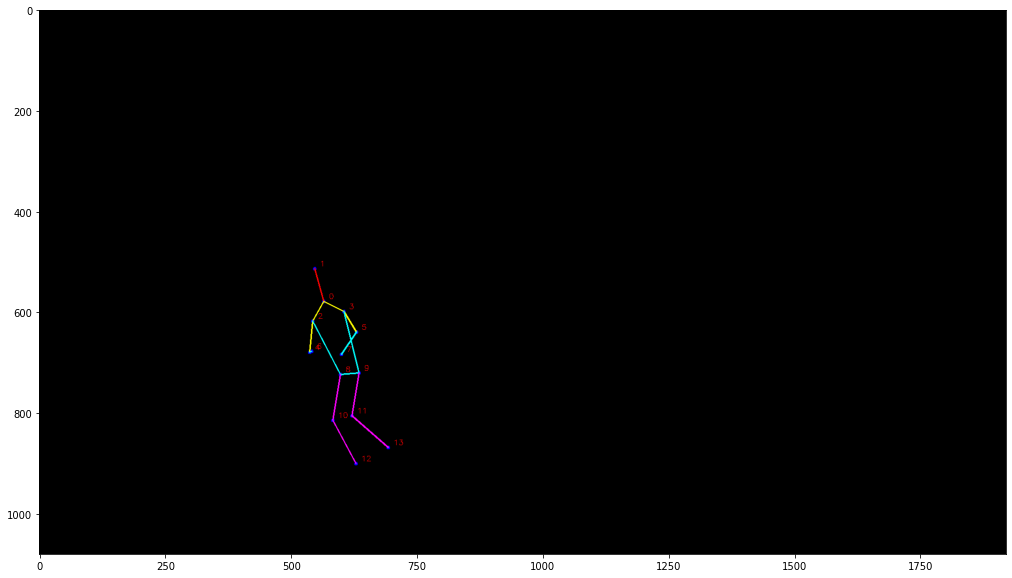

(14, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 11 0


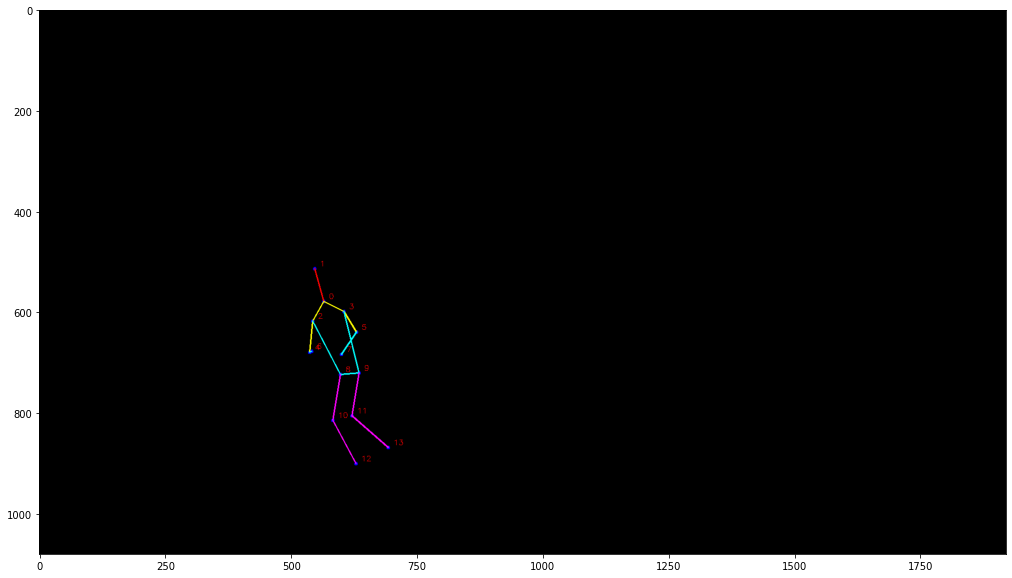

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
7 12 0


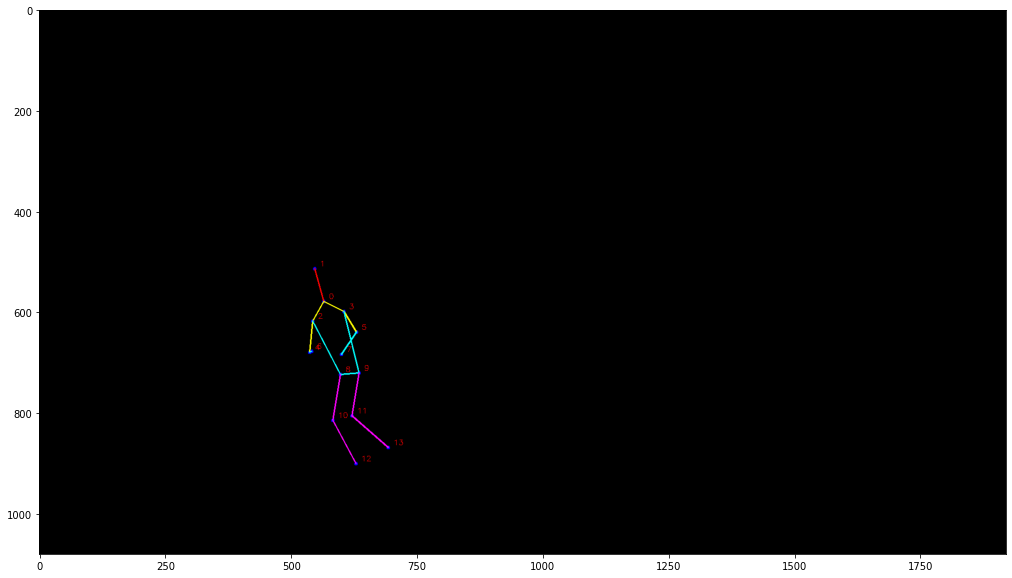

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
7 13 0


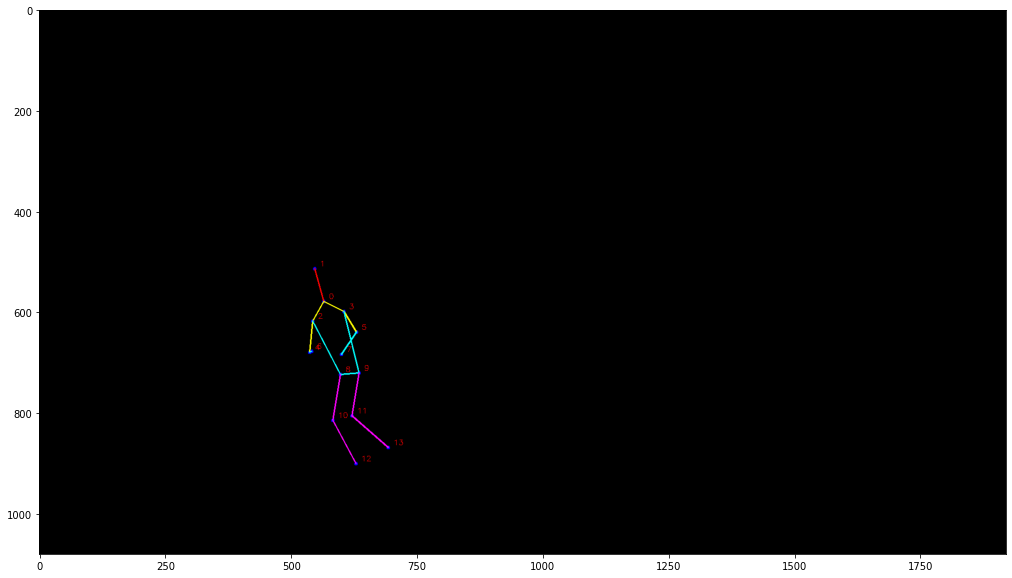

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
8 0 0


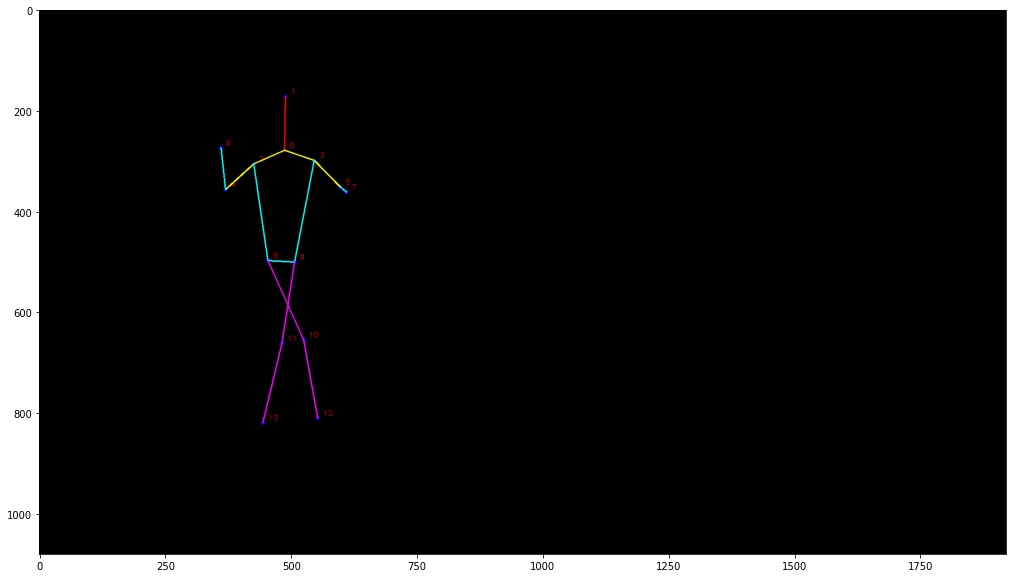

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
8 1 0


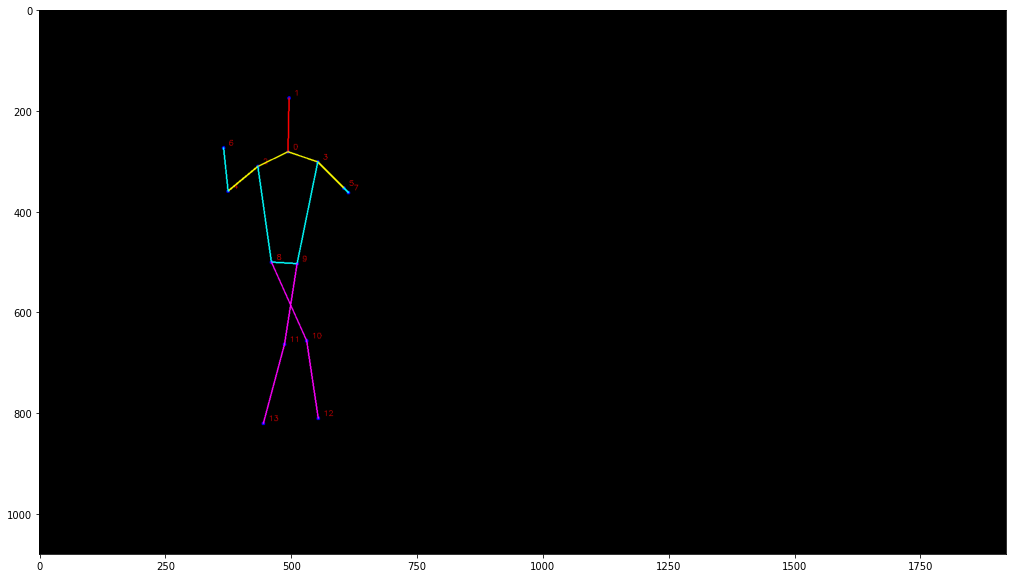

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
8 2 0


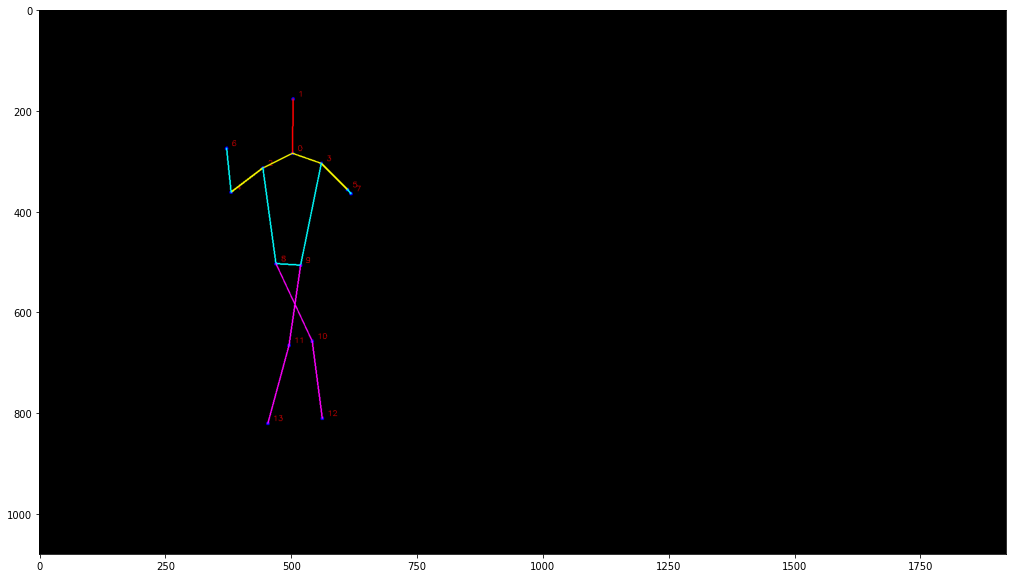

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
8 3 0


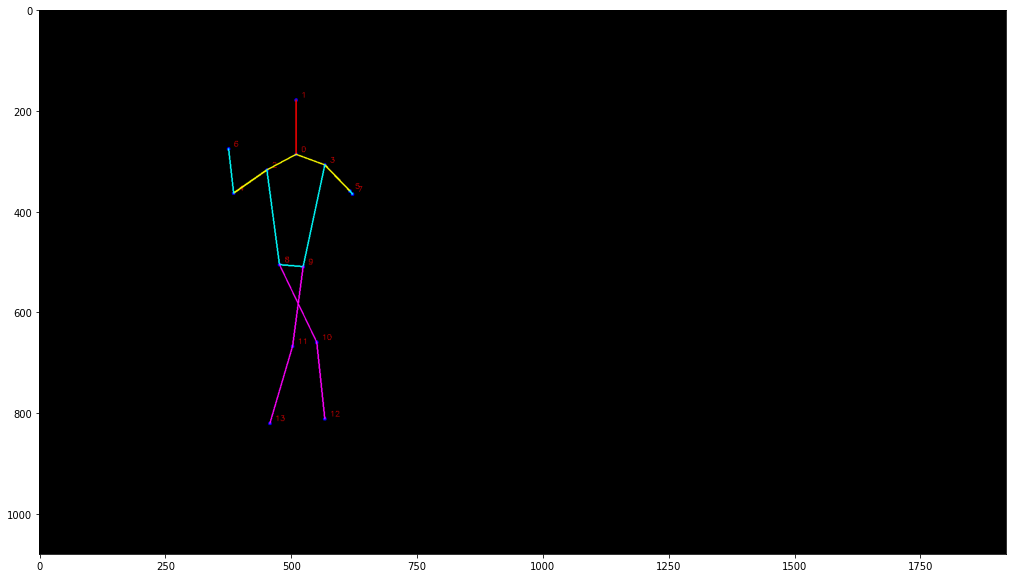

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
8 4 0


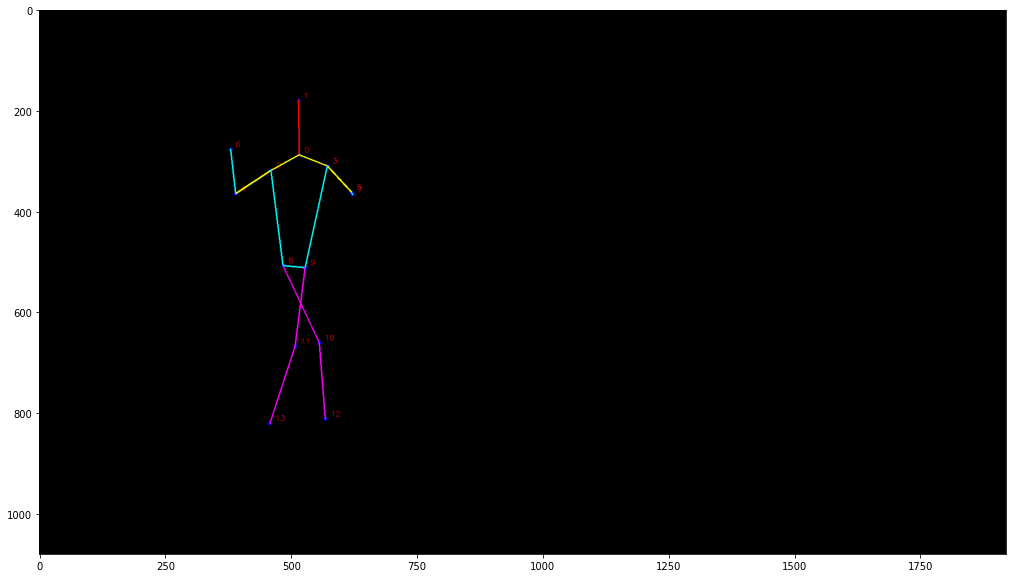

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
8 5 0


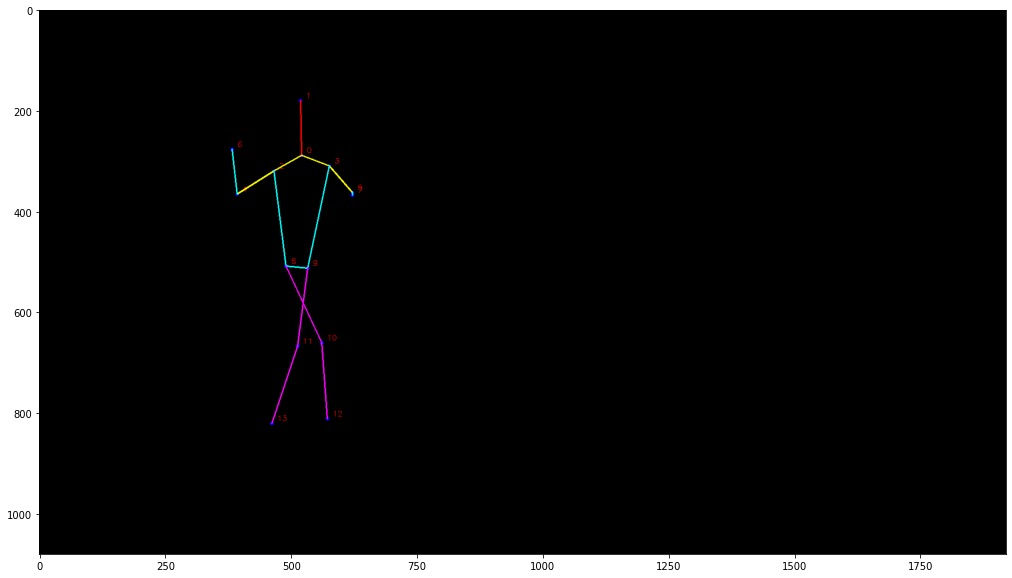

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
8 6 0


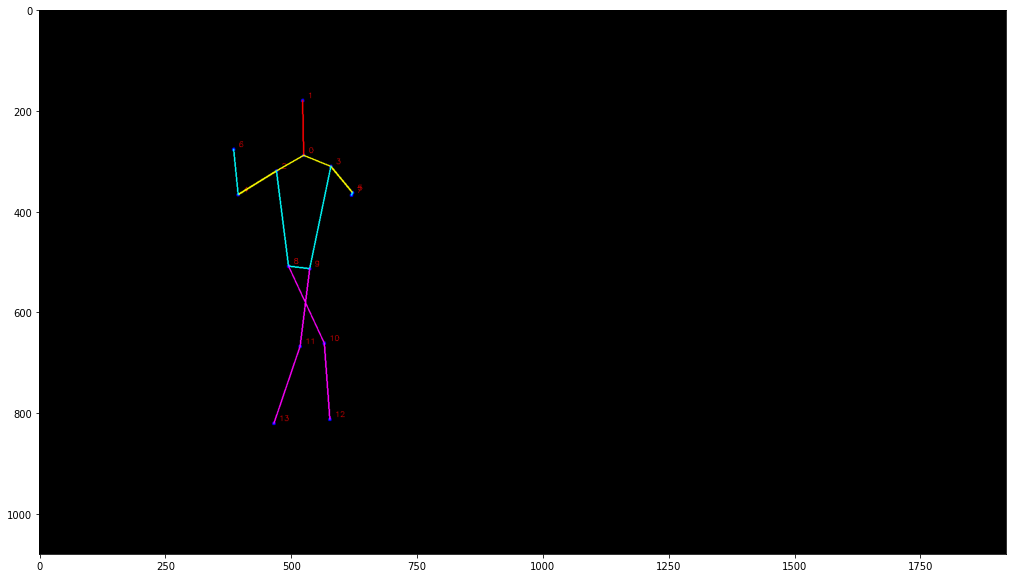

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
8 7 0


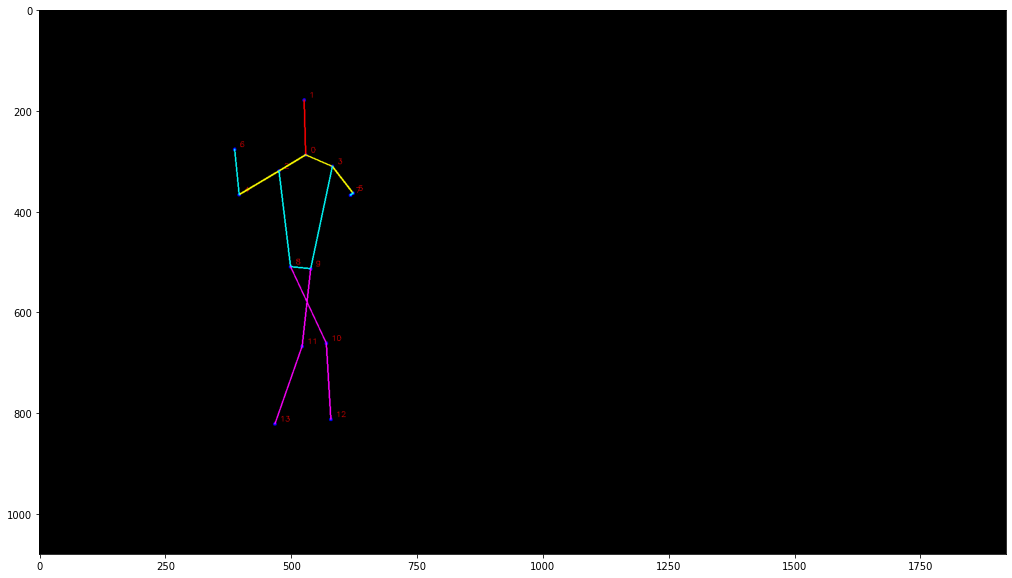

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
8 8 0


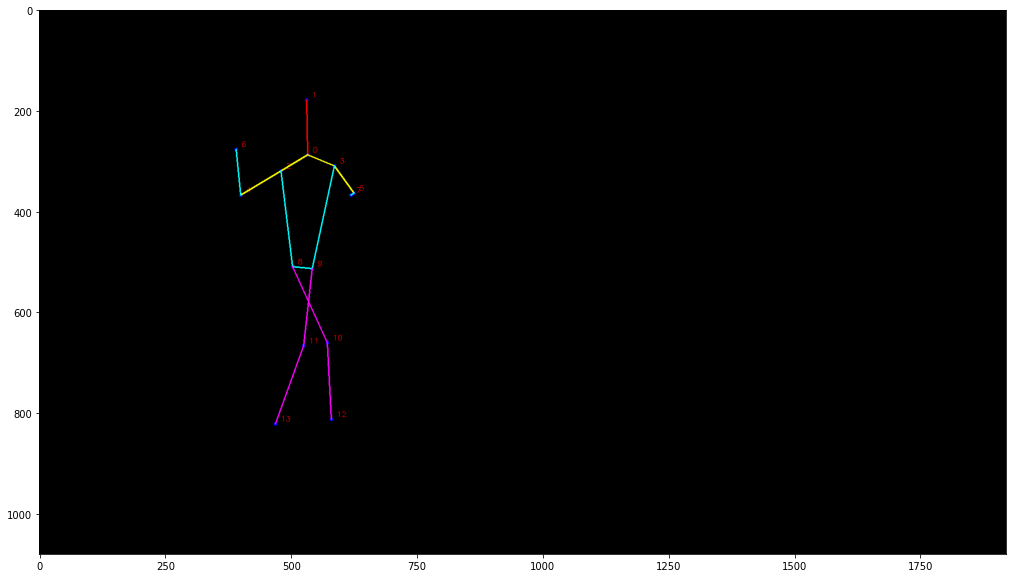

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
8 9 0


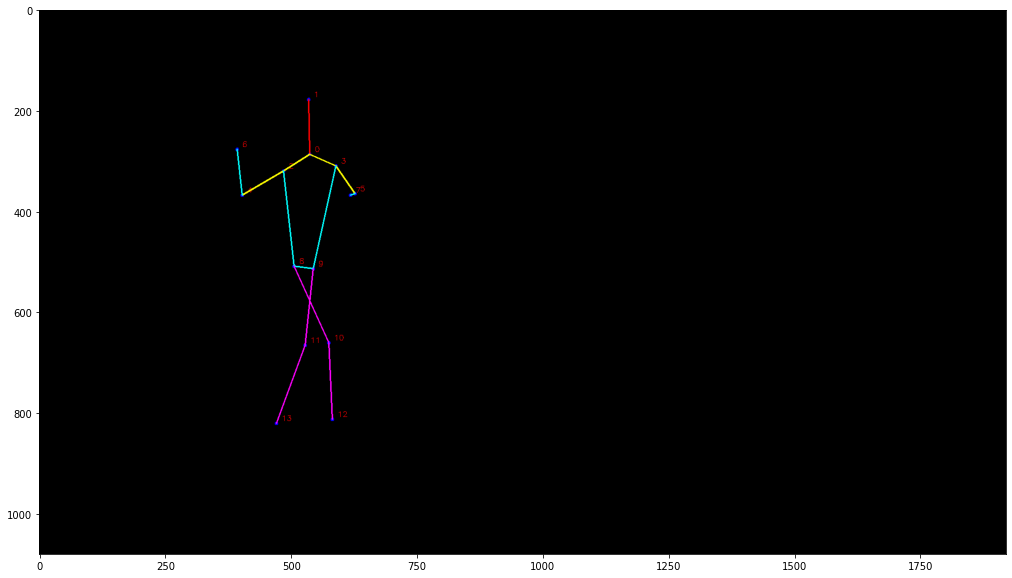

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
8 10 0


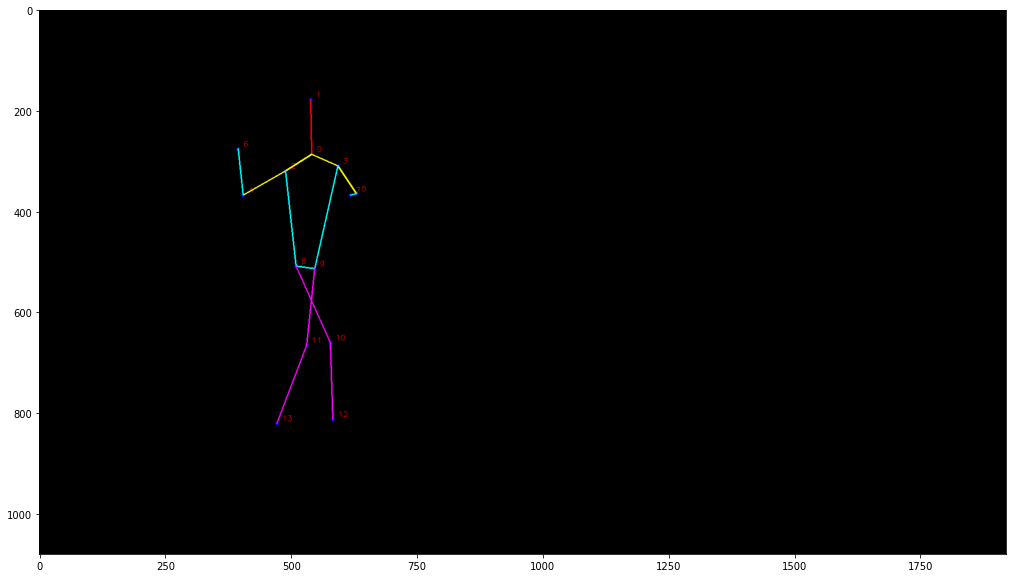

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
8 11 0


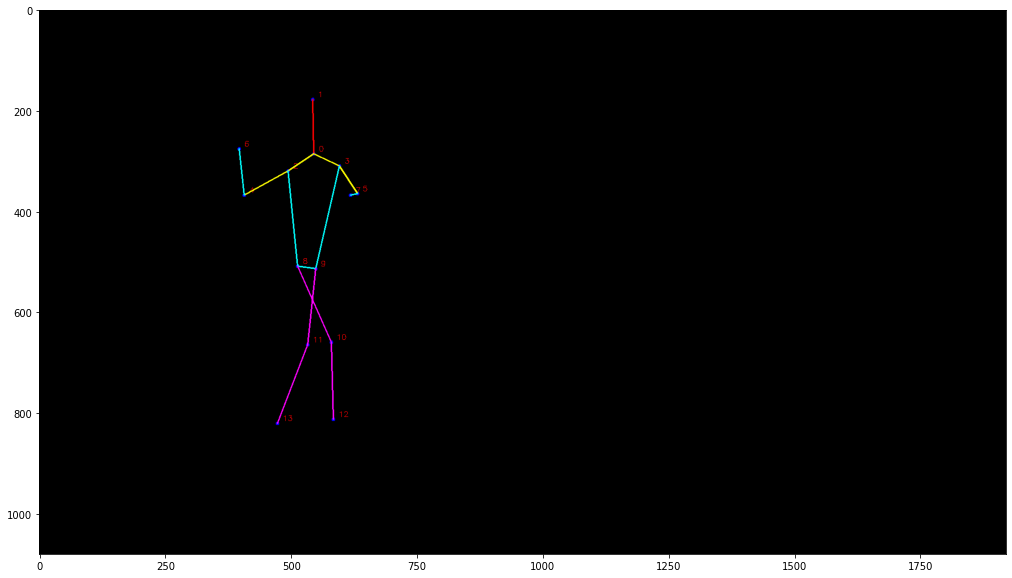

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
8 12 0


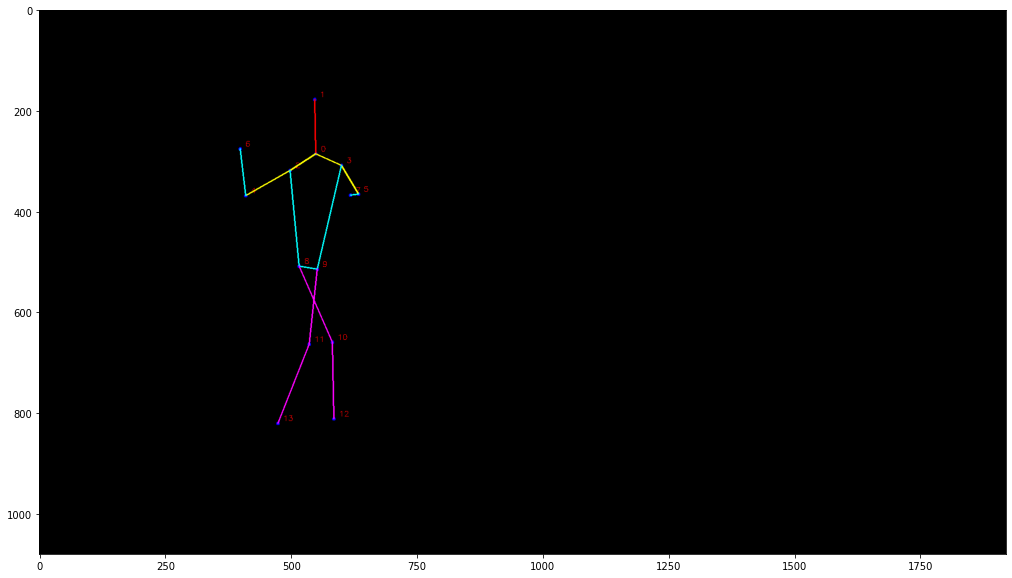

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
8 13 0


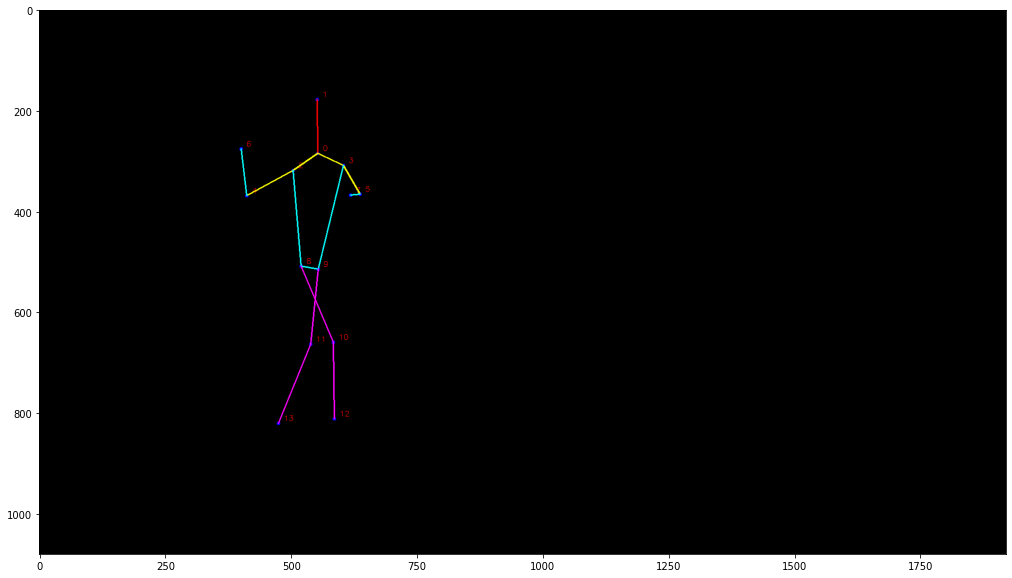

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
9 0 0


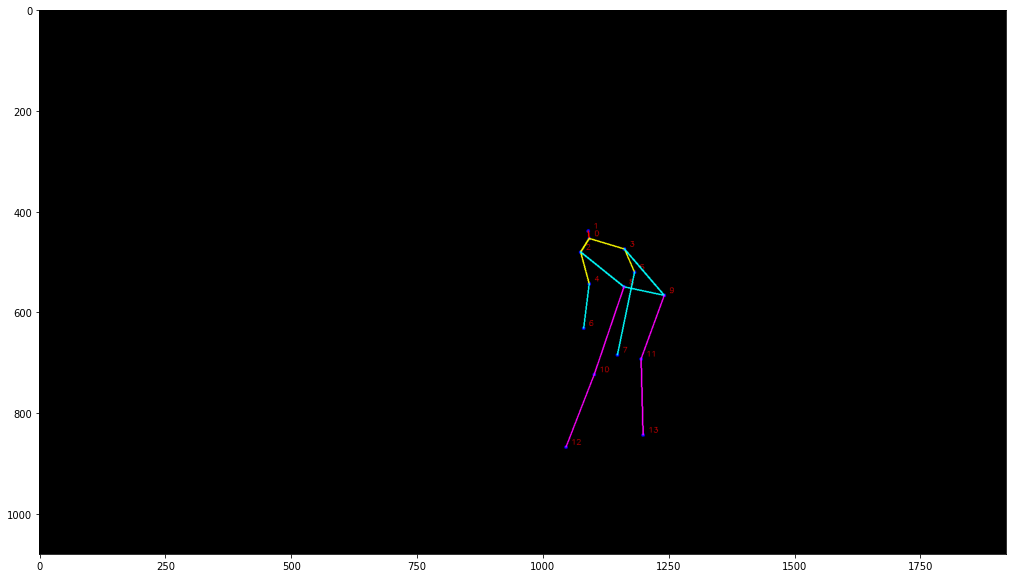

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
9 1 0


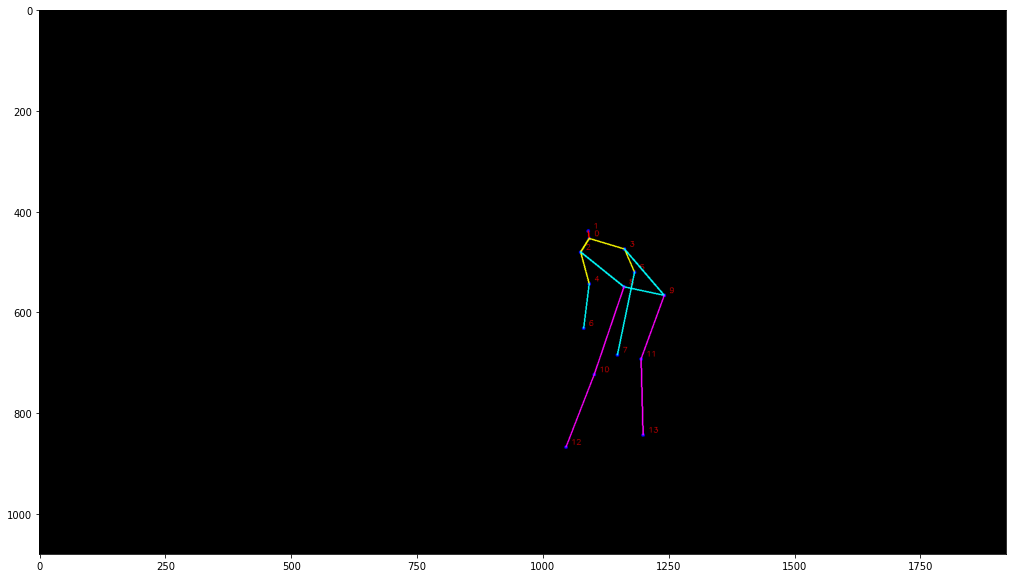

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
9 2 0


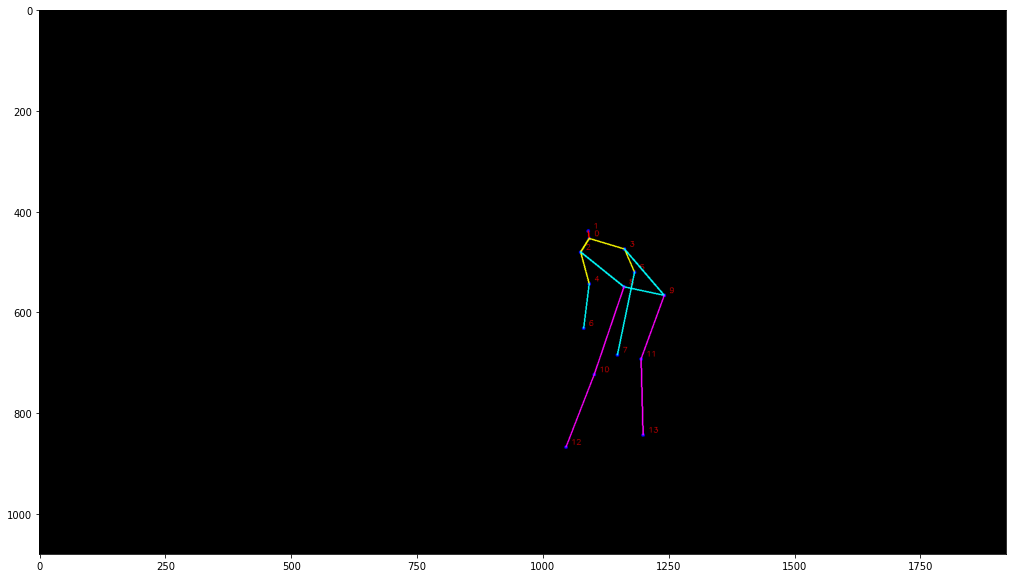

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
9 3 0


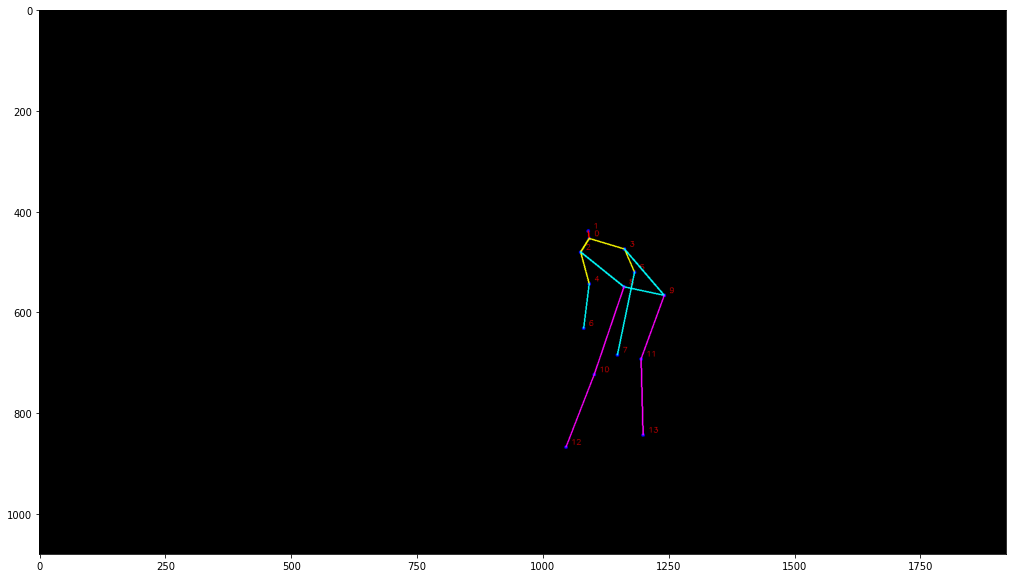

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
9 4 0


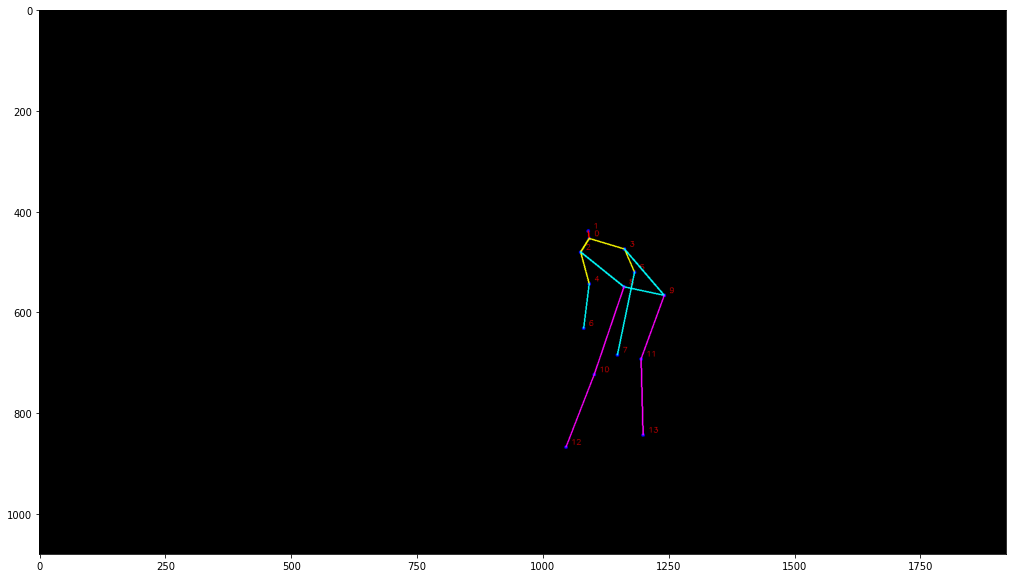

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
9 5 0


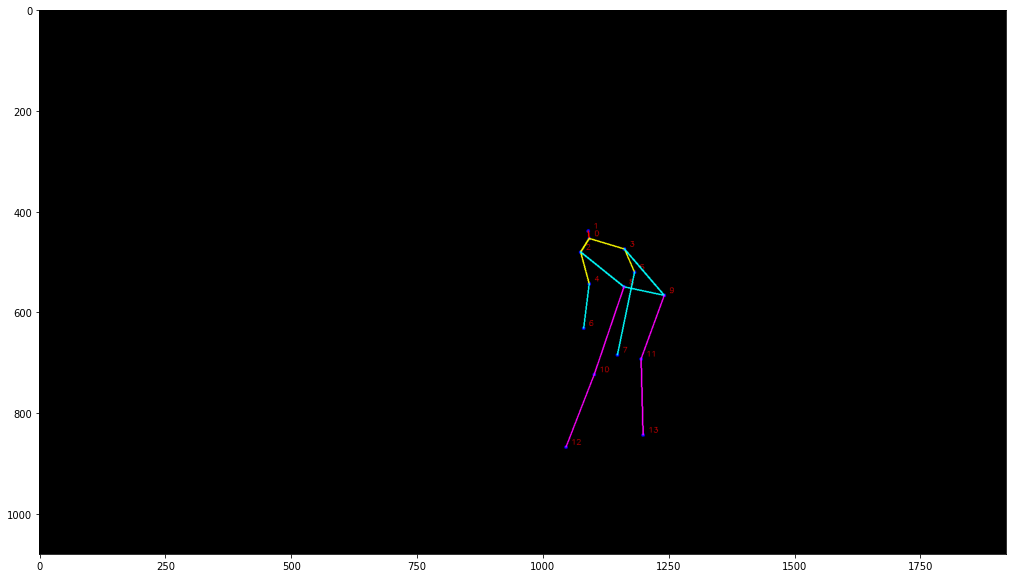

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
9 6 0


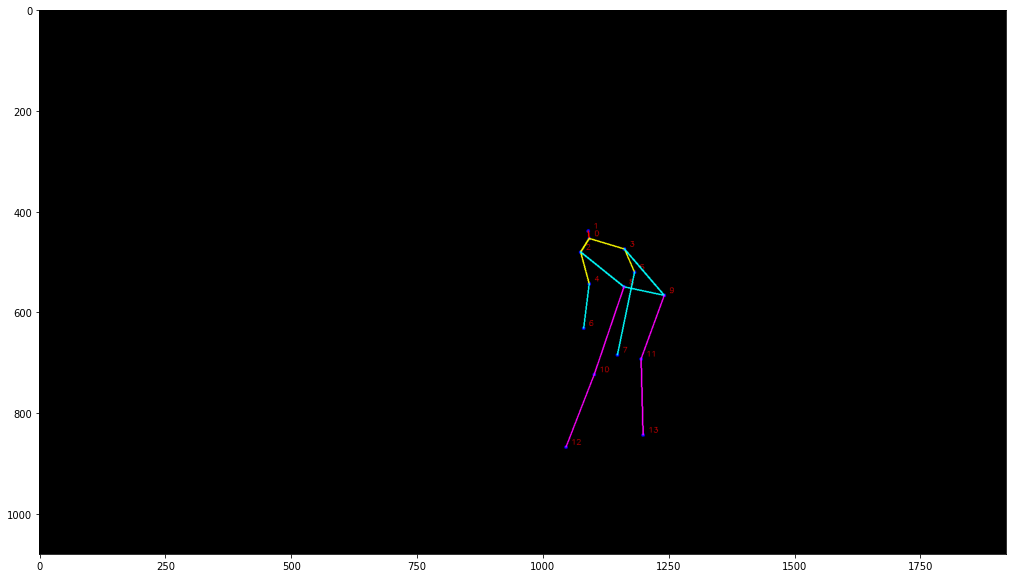

(14, 2)
9 7 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


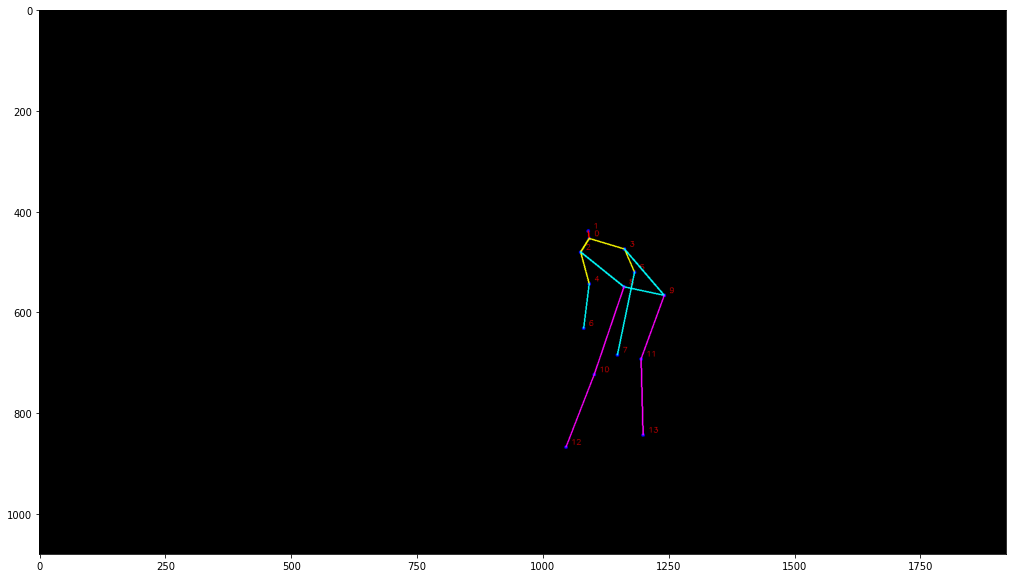

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
9 8 0


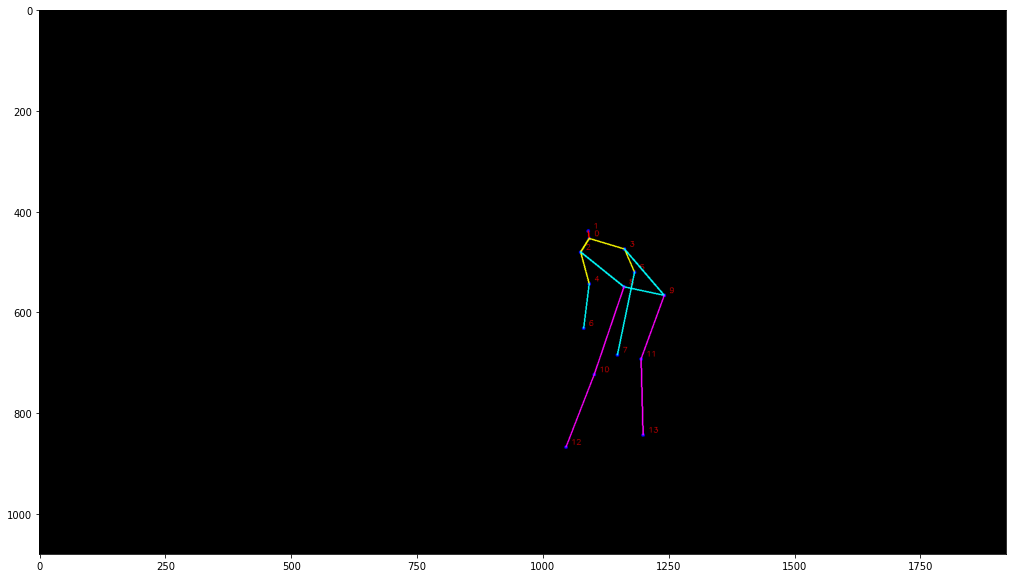

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
9 9 0


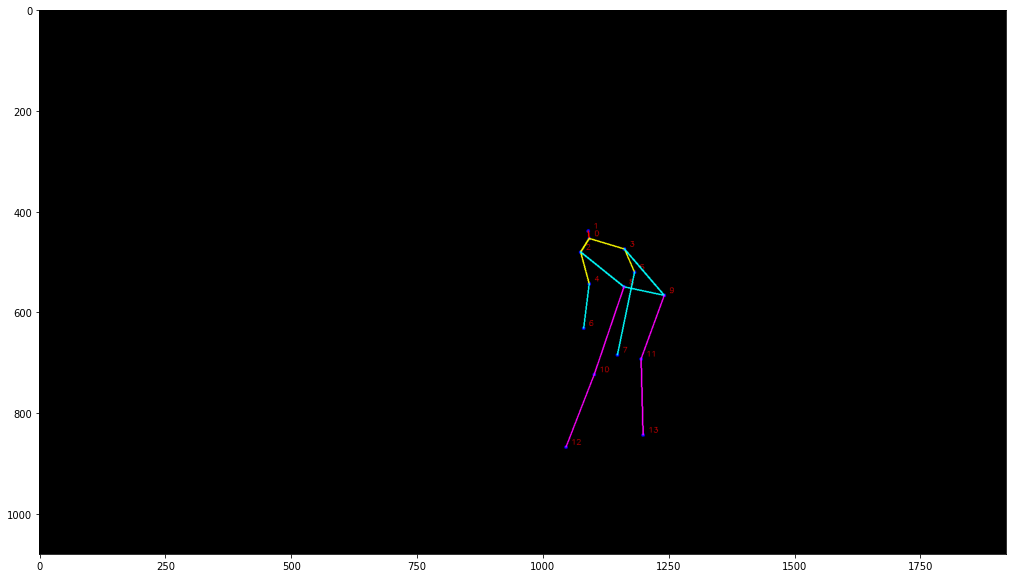

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
9 10 0


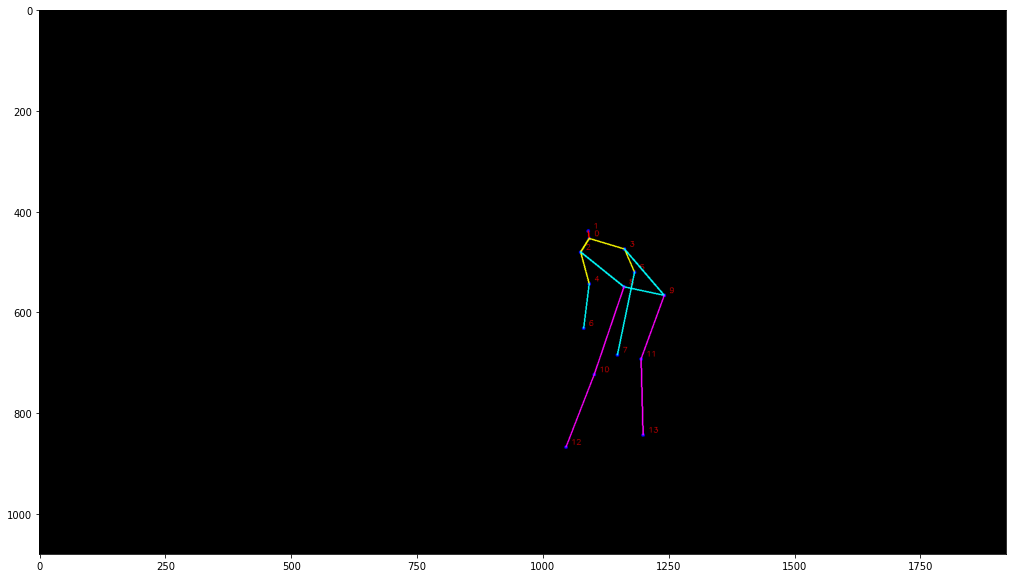

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
9 11 0


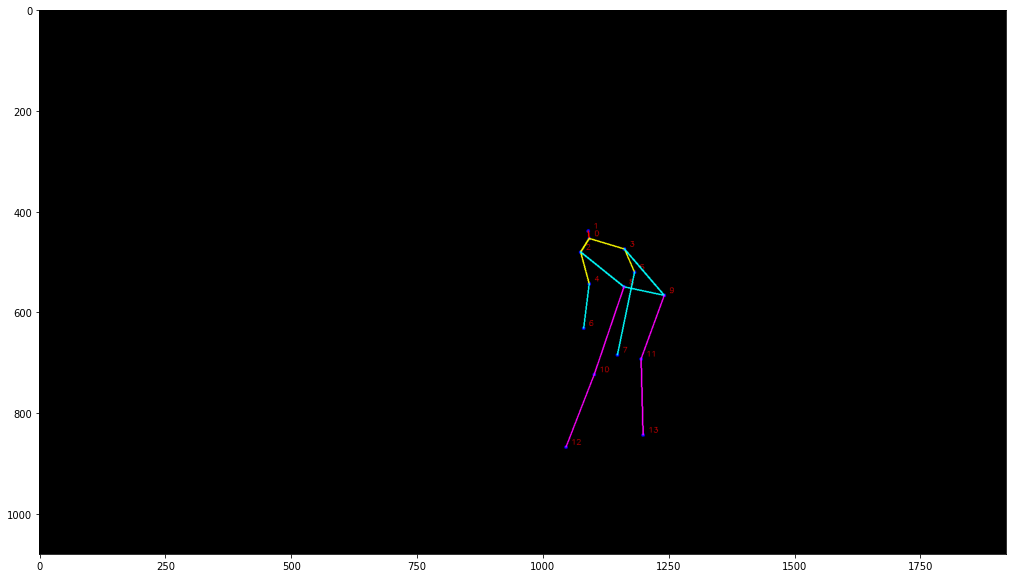

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
9 12 0


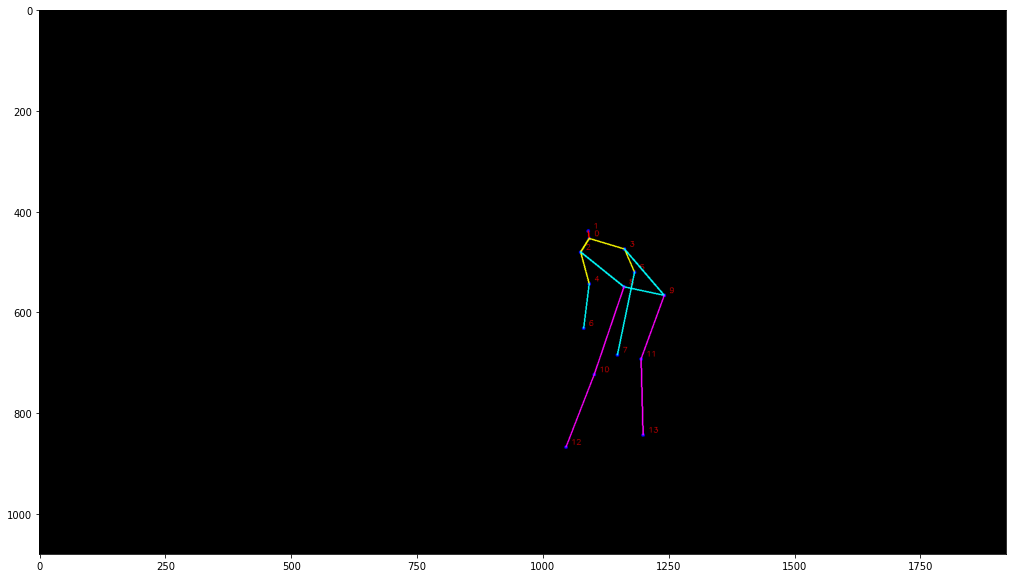

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(14, 2)
9 13 0


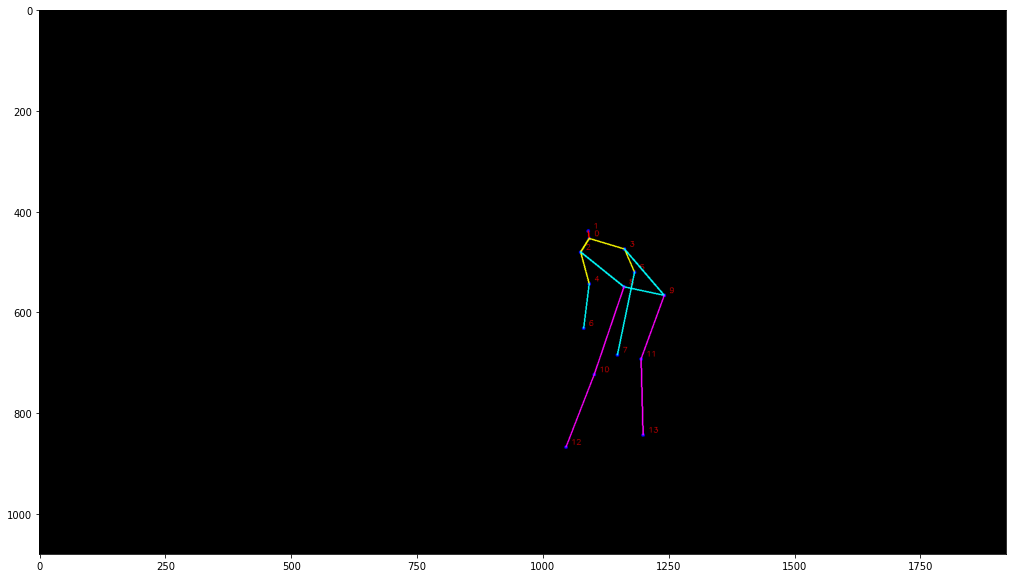

In [56]:
import json
plt.rcParams['figure.figsize'] = [20, 10]
with open("./posetrack_predictions.json", "r") as read_file:       
        data = json.load(read_file)

        for i in range(10):
            x=len(data[i])
            y=len(data[i][0])
#             print(x,y)
            for j in range(y):
                for k in range(14):
                    x1=draw_keypoints(np.array(data[i][j][k]).astype(int))
                    print(i,k,j)
                    plt.imshow(x1)
                    plt.show()
                break
                    
            


In [52]:
print(data[1][2][6])

[130.71278381347656, 351.6900329589844, 138.18247985839844, 324.1877746582031, 145.02297973632812, 356.8345642089844, 122.7223129272461, 352.95452880859375, 24.984724044799805, 1.3279798030853271, 103.92252349853516, 387.28997802734375, 28.037572860717773, 0.0, 102.91587829589844, 413.2453308105469, 156.91781616210938, 401.946533203125, 136.6813201904297, 402.3849792480469, 142.5955810546875, 450.0486755371094, 157.172607421875, 459.35748291015625, 137.191650390625, 491.3098449707031, 161.49781799316406, 496.45684814453125]


In [283]:
for idx, (obs_s, target_s, obs_pose, target_pose, obs_mask, target_mask) in enumerate(train_loader):
        counter+=1
        obs_s    = obs_s.to(device='cuda')
        target_s = target_s.to(device='cuda')
        obs_pose    = obs_pose.to(device='cuda')
        target_pose = target_pose.to(device='cuda')
        obs_mask    = obs_mask.to(device='cuda')
        target_mask = target_mask.to(device='cuda')
        
        (speed_preds,mask_preds) = net(pose=obs_pose,vel=obs_s,mask=obs_mask)
        preds_p = speed2pos(speed_preds, obs_pose)
        
        std = np.std(preds_p.detach().cpu().numpy(), axis=1, dtype=np.float64)
        print(std.mean())
        break

352.7784650339753


In [299]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
import torchvision.transforms as transforms
import random

class LSTM_posetrack_tf(nn.Module):
    def __init__(self, args):

        super(LSTM_posetrack_tf, self).__init__()
         
        self.pose_encoder = nn.LSTM(input_size=28, hidden_size=args.hidden_size)
        self.vel_encoder = nn.LSTM(input_size=28, hidden_size=args.hidden_size)
        
        self.pose_embedding = nn.Sequential(nn.Linear(in_features=args.hidden_size, out_features=28),
                                           nn.ReLU())
        
        self.vel_decoder = nn.LSTMCell(input_size=28, hidden_size=args.hidden_size)
   
        self.fc_vel    = nn.Linear(in_features=args.hidden_size, out_features=28)
        
        self.hardtanh = nn.Hardtanh(min_val=-1*args.hardtanh_limit,max_val=args.hardtanh_limit)
        self.relu = nn.LeakyReLU() 
        self.softmax = nn.Softmax(dim=1)
        
        self.mask_encoder = nn.LSTM(input_size=14, hidden_size=args.hidden_size)
        self.mask_decoder = nn.LSTMCell(input_size=14, hidden_size=args.hidden_size)
        self.fc_mask    = nn.Linear(in_features=args.hidden_size, out_features=14)
        
        self.sigmoid = nn.Sigmoid()
        
        self.args = args
        
    def forward(self, pose=None, vel=None, mask=None, target_s=None, target_mask=None):
        

        _, (hidden_vel, cell_vel) = self.vel_encoder(vel.permute(1,0,2))
        hidden_vel = hidden_vel.squeeze(0)
        cell_vel = cell_vel.squeeze(0)

        _, (hidden_dec2, cell_dec2) = self.mask_encoder(mask.permute(1,0,2))
        hidden_dec2 = hidden_dec2.squeeze(0)
        cell_dec2 = cell_dec2.squeeze(0)
        
        outputs = []
        vel_outputs    = torch.tensor([], device=self.args.device)
        mask_outputs    = torch.tensor([], device=self.args.device)
        
        VelDec_inp = vel[:,-1,:]
        MaskDec_inp = mask[:,-1,:]
        
        hidden_dec = hidden_vel
        cell_dec = cell_vel
        
        for i in range((self.args.output//self.args.skip)):
            if random.random()<0.6 and i>0:
                hidden_dec, cell_dec = self.vel_decoder(target_s[:,i-1,:], (hidden_dec, cell_dec))
                vel_output  = self.hardtanh(self.fc_vel(hidden_dec))
                vel_outputs = torch.cat((vel_outputs, vel_output.unsqueeze(1)), dim = 1)
                VelDec_inp  = vel_output.detach()

                hidden_dec2, cell_dec2 = self.mask_decoder(target_mask[:,i-1,:], (hidden_dec2, cell_dec2))
                mask_output  = self.sigmoid(self.fc_mask(hidden_dec2))
                mask_outputs = torch.cat((mask_outputs, mask_output.unsqueeze(1)), dim = 1)
                MaskDec_inp  = mask_output.detach()
            else:
                hidden_dec, cell_dec = self.vel_decoder(VelDec_inp, (hidden_dec, cell_dec))
                vel_output  = self.hardtanh(self.fc_vel(hidden_dec))
                vel_outputs = torch.cat((vel_outputs, vel_output.unsqueeze(1)), dim = 1)
                VelDec_inp  = vel_output.detach()

                hidden_dec2, cell_dec2 = self.mask_decoder(MaskDec_inp, (hidden_dec2, cell_dec2))
                mask_output  = self.sigmoid(self.fc_mask(hidden_dec2))
                mask_outputs = torch.cat((mask_outputs, mask_output.unsqueeze(1)), dim = 1)
                MaskDec_inp  = mask_output.detach()
            
        
            
        outputs.append(vel_outputs)    
        outputs.append(mask_outputs) 
        return tuple(outputs)



In [300]:
net = LSTM_posetrack_tf(args).to(args.device)
optimizer = optim.Adam(net.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, 
                                                 threshold = 1e-8, verbose=True)
print('='*100)
print('Training ...')

for epoch in range(200):
    start = time.time()
    
    avg_epoch_train_s_loss = 0
    avg_epoch_val_s_loss   = 0
    avg_epoch_train_p_loss   = 0
    avg_epoch_val_p_loss     = 0 
    
    ade  = 0
    fde  = 0
    ade_train  = 0
    fde_train  = 0
    counter = 0
    
    for idx, (obs_s, target_s, obs_pose, target_pose, obs_mask, target_mask) in enumerate(train_loader):
        counter += 1        
        
        obs_s    = obs_s.to(device='cuda')
        target_s = target_s.to(device='cuda')
        obs_pose    = obs_pose.to(device='cuda')
        target_pose = target_pose.to(device='cuda')
        obs_mask    = obs_mask.to(device='cuda')
        target_mask = target_mask.to(device='cuda')
        
#         print(obs_s.shape)
        
        net.zero_grad()
    
        (speed_preds,mask_preds) = net(pose=obs_pose, vel=obs_s,mask=obs_mask,target_mask=target_mask,target_s=target_s)

        speed_loss  = l1e(speed_preds, target_s)
        mask_loss  = bce(mask_preds, target_mask)
    
        preds_p = speed2pos(speed_preds, obs_pose) 
        ade_train += float(ADE_c(preds_p, target_pose))
        fde_train += float(FDE_c(preds_p, target_pose))
        
        loss= 0.9*speed_loss+0.1*mask_loss
        loss.backward()

        optimizer.step()
        
    
        avg_epoch_train_s_loss += float(speed_loss)
        avg_epoch_train_p_loss += float(mask_loss)

    avg_epoch_train_s_loss /= counter
    avg_epoch_train_p_loss /= counter
    train_s_scores.append(avg_epoch_train_s_loss)
    ade_train  /= counter
    fde_train  /= counter    

    counter=0

    for idx, (obs_s, target_s, obs_pose, target_pose, obs_mask, target_mask) in enumerate(val_loader):
        counter+=1
        obs_s    = obs_s.to(device='cuda')
        target_s = target_s.to(device='cuda')
        obs_pose    = obs_pose.to(device='cuda')
        target_pose = target_pose.to(device='cuda')
        obs_mask    = obs_mask.to(device='cuda')
        target_mask = target_mask.to(device='cuda')
        
        with torch.no_grad():
            (speed_preds,mask_preds) = net(pose=obs_pose,vel=obs_s,mask=obs_mask,target_mask=target_mask,target_s=target_s)

            speed_loss  = l1e(speed_preds, target_s)
            mask_loss  = bce(mask_preds, target_mask)
            
            loss= 0.7*speed_loss+0.3*mask_loss
            avg_epoch_val_s_loss += float(speed_loss)
            avg_epoch_val_p_loss += float(mask_loss)
        
            preds_p = speed2pos(speed_preds, obs_pose)
            ade += float(ADE_c(preds_p, target_pose))
            fde += float(FDE_c(preds_p, target_pose))

        
    avg_epoch_val_s_loss /= counter
    avg_epoch_val_p_loss /= counter
    val_s_scores.append(avg_epoch_val_s_loss)
    
    ade  /= counter
    fde  /= counter     
   
    scheduler.step(avg_epoch_val_s_loss)
    
     
    print('e:', epoch, '| ts: %.2f'% avg_epoch_train_s_loss,  '| vs: %.2f'% avg_epoch_val_s_loss,'| tm: %.2f'% avg_epoch_train_p_loss,  '| vm: %.2f'% avg_epoch_val_p_loss, '| ade_train: %.2f'% ade_train, '| ade_val: %.2f'% ade, '| fde_train: %.2f'% fde_train,'| fde_val: %.2f'% fde,
          '| t:%.2f'%(time.time()-start))


print('='*100) 
# print('Saving ...')
# torch.save(net.state_dict(), args.model_path)
print('Done !')

Training ...
e: 0 | ts: 11.65 | vs: 12.20 | tm: 4.77 | vm: 0.82 | ade_train: 86.61 | ade_val: 87.98 | fde_train: 145.35 | fde_val: 144.59 | t:3.18
e: 1 | ts: 10.04 | vs: 11.73 | tm: 0.66 | vm: 0.59 | ade_train: 74.02 | ade_val: 83.76 | fde_train: 122.67 | fde_val: 137.20 | t:3.10
e: 2 | ts: 9.81 | vs: 11.78 | tm: 0.51 | vm: 0.62 | ade_train: 71.96 | ade_val: 83.86 | fde_train: 119.00 | fde_val: 136.78 | t:3.11
e: 3 | ts: 9.70 | vs: 11.57 | tm: 0.47 | vm: 0.52 | ade_train: 70.91 | ade_val: 82.99 | fde_train: 116.96 | fde_val: 134.35 | t:3.10
e: 4 | ts: 9.64 | vs: 11.42 | tm: 0.47 | vm: 0.61 | ade_train: 70.22 | ade_val: 82.58 | fde_train: 116.35 | fde_val: 133.93 | t:3.12
e: 5 | ts: 9.59 | vs: 11.38 | tm: 0.48 | vm: 0.43 | ade_train: 69.81 | ade_val: 81.68 | fde_train: 115.40 | fde_val: 133.13 | t:3.09
e: 6 | ts: 9.47 | vs: 11.33 | tm: 0.42 | vm: 0.47 | ade_train: 68.43 | ade_val: 80.42 | fde_train: 112.96 | fde_val: 131.01 | t:3.12
e: 7 | ts: 9.48 | vs: 11.32 | tm: 0.42 | vm: 0.49 | ad

e: 60 | ts: 9.04 | vs: 10.98 | tm: 0.36 | vm: 0.38 | ade_train: 63.63 | ade_val: 77.31 | fde_train: 105.11 | fde_val: 124.99 | t:3.14
e: 61 | ts: 8.97 | vs: 10.92 | tm: 0.33 | vm: 0.38 | ade_train: 62.99 | ade_val: 76.33 | fde_train: 103.79 | fde_val: 123.73 | t:3.16
e: 62 | ts: 8.96 | vs: 10.92 | tm: 0.33 | vm: 0.38 | ade_train: 62.73 | ade_val: 76.28 | fde_train: 103.72 | fde_val: 122.89 | t:3.13
e: 63 | ts: 8.98 | vs: 10.96 | tm: 0.33 | vm: 0.38 | ade_train: 62.97 | ade_val: 77.37 | fde_train: 104.14 | fde_val: 125.74 | t:3.23
e: 64 | ts: 8.95 | vs: 10.94 | tm: 0.33 | vm: 0.39 | ade_train: 62.50 | ade_val: 76.67 | fde_train: 103.19 | fde_val: 124.36 | t:3.12
e: 65 | ts: 8.92 | vs: 10.92 | tm: 0.34 | vm: 0.39 | ade_train: 62.15 | ade_val: 76.81 | fde_train: 102.96 | fde_val: 123.87 | t:3.13
e: 66 | ts: 8.94 | vs: 10.94 | tm: 0.34 | vm: 0.39 | ade_train: 62.28 | ade_val: 76.21 | fde_train: 103.30 | fde_val: 123.70 | t:3.14
e: 67 | ts: 8.91 | vs: 10.95 | tm: 0.34 | vm: 0.39 | ade_train

e: 120 | ts: 8.71 | vs: 10.76 | tm: 0.29 | vm: 0.33 | ade_train: 60.32 | ade_val: 73.88 | fde_train: 99.80 | fde_val: 119.07 | t:3.12
e: 121 | ts: 8.66 | vs: 10.82 | tm: 0.29 | vm: 0.33 | ade_train: 59.93 | ade_val: 74.47 | fde_train: 99.15 | fde_val: 120.22 | t:3.13
e: 122 | ts: 8.69 | vs: 10.83 | tm: 0.29 | vm: 0.33 | ade_train: 59.94 | ade_val: 74.32 | fde_train: 99.62 | fde_val: 120.45 | t:3.12
e: 123 | ts: 8.68 | vs: 10.83 | tm: 0.29 | vm: 0.33 | ade_train: 59.94 | ade_val: 74.34 | fde_train: 99.17 | fde_val: 120.67 | t:3.13
e: 124 | ts: 8.67 | vs: 10.81 | tm: 0.29 | vm: 0.33 | ade_train: 59.75 | ade_val: 74.60 | fde_train: 99.29 | fde_val: 120.14 | t:3.09
e: 125 | ts: 8.70 | vs: 10.80 | tm: 0.29 | vm: 0.33 | ade_train: 60.08 | ade_val: 74.50 | fde_train: 99.56 | fde_val: 120.76 | t:3.11
e: 126 | ts: 8.67 | vs: 10.87 | tm: 0.29 | vm: 0.33 | ade_train: 59.95 | ade_val: 75.01 | fde_train: 99.18 | fde_val: 121.33 | t:3.26
e: 127 | ts: 8.70 | vs: 10.88 | tm: 0.28 | vm: 0.33 | ade_trai

e: 180 | ts: 8.63 | vs: 10.78 | tm: 0.26 | vm: 0.30 | ade_train: 59.50 | ade_val: 74.56 | fde_train: 99.12 | fde_val: 119.49 | t:3.12
e: 181 | ts: 8.64 | vs: 10.76 | tm: 0.26 | vm: 0.30 | ade_train: 59.55 | ade_val: 73.47 | fde_train: 98.85 | fde_val: 119.26 | t:3.07
e: 182 | ts: 8.67 | vs: 10.87 | tm: 0.26 | vm: 0.30 | ade_train: 59.98 | ade_val: 75.18 | fde_train: 99.44 | fde_val: 121.96 | t:3.10
e: 183 | ts: 8.66 | vs: 10.82 | tm: 0.26 | vm: 0.30 | ade_train: 59.99 | ade_val: 74.73 | fde_train: 99.51 | fde_val: 121.23 | t:3.14
e: 184 | ts: 8.64 | vs: 10.84 | tm: 0.26 | vm: 0.30 | ade_train: 59.83 | ade_val: 74.68 | fde_train: 99.08 | fde_val: 120.80 | t:3.11
e: 185 | ts: 8.63 | vs: 10.84 | tm: 0.26 | vm: 0.30 | ade_train: 59.62 | ade_val: 75.49 | fde_train: 98.57 | fde_val: 121.33 | t:3.12
e: 186 | ts: 8.61 | vs: 10.82 | tm: 0.26 | vm: 0.30 | ade_train: 59.52 | ade_val: 73.88 | fde_train: 98.40 | fde_val: 120.45 | t:3.09
e: 187 | ts: 8.68 | vs: 10.83 | tm: 0.26 | vm: 0.30 | ade_trai

In [18]:
class args():
    def __init__(self):
        self.jaad_dataset = '/data/smailait-data/JAAD/processed_annotations' #folder containing parsed jaad annotations (used when first time loading data)
        self.dtype        = 'train'
        self.from_file    = False #read dataset from csv file or reprocess data
        self.save         = True
        self.file         = '/data/smailait-data/jaad_train_16_16.csv'
        self.save_path    = '/data/smailait-data/jaad_train_16_16.csv'
        self.model_path    = '/data/smailait-data/models/multitask_pv_lstm_trained.pkl'
        self.loader_workers = 1
        self.loader_shuffle = True
        self.pin_memory     = False
        self.image_resize   = [240, 426]
        self.device         = 'cuda'
        self.batch_size     = 50
        self.n_epochs       = 250
        self.hidden_size    = 1000
        self.hardtanh_limit = 100
        self.input  = 16
        self.output = 14
        self.stride = 16
        self.skip   = 1
        # self.task   = 'bounding_box-intention'
        self.task   = 'pose'
        self.use_scenes = False       
        self.lr = 0.03

args = args()


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
import torchvision.transforms as transforms


class PV_LSTM_DE(nn.Module):
    def __init__(self, args):
        '''
           input: observed body poses and velocites global and local
           output: global and local velocities
        '''
        super(PV_LSTM_DE, self).__init__()
        self.in_s=28
        self.pose_encoder = nn.LSTM(input_size=self.in_s, hidden_size=args.hidden_size)
        self.vel_encoder = nn.LSTM(input_size=self.in_s, hidden_size=args.hidden_size)
        self.vel_decoder = nn.LSTMCell(input_size=self.in_s, hidden_size=args.hidden_size)
        self.fc_vel    = nn.Linear(in_features=args.hidden_size, out_features=self.in_s)
        
        self.pose_glob_encoder = nn.LSTM(input_size=2, hidden_size=100)
        self.vel_glob_encoder = nn.LSTM(input_size=2, hidden_size=100)
        self.vel_glob_decoder = nn.LSTMCell(input_size=2, hidden_size=100)
        self.fc_global    = nn.Linear(in_features=100, out_features=2)
        
        self.fc_combine= nn.Linear(in_features=self.in_s, out_features=self.in_s)
        
        self.hardtanh = nn.Hardtanh(min_val=-1*args.hardtanh_limit,max_val=args.hardtanh_limit)
        self.relu = nn.ReLU() 
        self.softmax = nn.Softmax(dim=1)
        
        
        self.args = args
        
    def forward(self, pose_local=None, vel_local=None, pose_glob=None, vel_glob=None):


        _, (hidden_vel, cell_vel) = self.vel_encoder(vel_local.permute(1,0,2))
        hidden_vel = hidden_vel.squeeze(0)
        cell_vel = cell_vel.squeeze(0)


        _, (hidden_pose, cell_pose) = self.pose_encoder(pose_local.permute(1,0,2))
        hidden_pose = hidden_pose.squeeze(0)
        cell_pose = cell_pose.squeeze(0)
        
        _, (hidden_vel_glob, cell_vel_glob) = self.vel_glob_encoder(vel_glob.permute(1,0,2))
        hidden_vel_glob = hidden_vel_glob.squeeze(0)
        cell_vel_glob = cell_vel_glob.squeeze(0)
        
        _, (hidden_pose_glob, cell_pose_glob) = self.pose_glob_encoder(pose_glob.permute(1,0,2))
        hidden_pose_glob = hidden_pose_glob.squeeze(0)
        cell_pose_glob = cell_pose_glob.squeeze(0)
        
        outputs = []
        
 
        vel_local_outputs    = torch.tensor([], device=self.args.device)
        vel_glob_outputs    = torch.tensor([], device=self.args.device)
        vel_combine_outputs = torch.tensor([], device=self.args.device)

        VelDec_inp = vel_local[:,-1,:]
        VelDec_glob_inp = vel_glob[:,-1,:]
        
        hidden_dec = hidden_pose + hidden_vel
        cell_dec = cell_pose + cell_vel
        
        hidden_glob = hidden_pose_glob + hidden_vel_glob
        cell_glob = cell_pose_glob + cell_vel_glob
    
        
        for i in range(self.args.output//self.args.skip):
            hidden_dec, cell_dec = self.vel_decoder(VelDec_inp, (hidden_dec, cell_dec))
            vel_local_output  = self.hardtanh(self.fc_vel(hidden_dec))
            vel_local_outputs = torch.cat((vel_local_outputs, vel_local_output.unsqueeze(1)), dim = 1)
            VelDec_inp  = vel_local_output.detach()
            
            hidden_glob, cell_glob = self.vel_glob_decoder(VelDec_glob_inp, (hidden_glob, cell_glob))
            vel_glob_output  = self.hardtanh(self.fc_global(hidden_glob))
            vel_glob_outputs = torch.cat((vel_glob_outputs, vel_glob_output.unsqueeze(1)), dim = 1)
            VelDec_glob_inp  = vel_glob_output.detach()
            
            
            vel_local=vel_local_output.reshape(-1,self.in_s//2,2)
            vel_glob=vel_glob_output.reshape(-1,1,2)
            
            vel_combine=(vel_local+vel_glob).reshape(-1,self.in_s)
            
#             vel_combine_output=self.fc_combine(vel_combine)
            
            vel_combine_outputs = torch.cat((vel_combine_outputs, vel_combine.unsqueeze(1)), dim = 1)#_output

            
        outputs.append(vel_local_outputs)
        outputs.append(vel_glob_outputs)
        outputs.append(vel_combine_outputs)
        
        return tuple(outputs)



In [27]:
class myDataset_DE_posetrack(torch.utils.data.Dataset):
    def __init__(self, args, dtype):
        
        self.args = args
        self.dtype = dtype
        print("Loading",self.dtype)
        
        sequence_centric = pd.read_csv("posetrack_"+self.dtype+".csv") 

        df = sequence_centric.copy()      
        for v in list(df.columns.values):
            print(v+' loaded')
            try:
                df.loc[:,v] = df.loc[:, v].apply(lambda x: literal_eval(x))
            except:
                continue
        sequence_centric[df.columns] = df[df.columns]
        self.data = sequence_centric.copy().reset_index(drop=True)
    
        print('*'*30)
        

    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index):

        seq = self.data.iloc[index]
        outputs = []

        obs = torch.tensor([seq.Pose[i] for i in range(0,self.args.input,self.args.skip)])        
        obs_speed = (obs[1:] - obs[:-1])
        
        true = torch.tensor([seq.Future_Pose[i] for i in range(0,self.args.output,self.args.skip)])
        true_speed = torch.cat(((true[0]-obs[-1]).unsqueeze(0), true[1:]-true[:-1]))
        

        obs_resh = torch.reshape(obs, (obs.size()[0],14,2))
        
        obs_global=obs_resh[:,0]
        obs_global=obs_global.unsqueeze(1)

        obs_resh=obs_resh-obs_global
    
        obs_resh=obs_resh.reshape(obs.size())
        
        true_resh = torch.reshape(true, (true.size()[0],14,2))
        true_global=true_resh[:,0]
        true_global=true_global.unsqueeze(1)
#         print(obs_resh.size(),obs_global.size())
        true_resh=true_resh-true_global
        true_resh=true_resh.reshape(true.size())
        
        
        obs_global=torch.reshape(obs_global, (obs.size()[0],2))
        true_global=torch.reshape(true_global, (true.size()[0],2))
        
        obs_local_speed=(obs_resh[1:] - obs_resh[:-1])
        true_local_speed=torch.cat(((true_resh[0]-obs_resh[-1]).unsqueeze(0), true_resh[1:]-true_resh[:-1]))
        
        obs_global_speed = (obs_global[1:] - obs_global[:-1])
        true_global_speed = torch.cat(((true_global[0]-obs_global[-1]).unsqueeze(0), true_global[1:]-true_global[:-1]))
        
#         print(obs_resh.size(),true_resh.size(),obs_global.size(),true_global.size())
        
        outputs.append(obs)
        outputs.append(obs_resh)
        outputs.append(true_resh)
        outputs.append(obs_global)
        outputs.append(true_global)
        outputs.append(obs_local_speed)
        outputs.append(true_local_speed)
        outputs.append(obs_global_speed)
        outputs.append(true_global_speed)
        outputs.append(true_speed)
        outputs.append(true)

        
        return tuple(outputs)    
    
    
def data_loader_DE_posetrack(args,data):
    dataset = myDataset_DE_posetrack(args,data)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=args.batch_size, shuffle=args.loader_shuffle,
        pin_memory=args.pin_memory)

    return dataloader

train_loader=data_loader_DE_posetrack(args,"train")
val_loader=data_loader_DE_posetrack(args,"valid")

Loading train
Pose loaded
Future_Pose loaded
Mask loaded
Future_Mask loaded
******************************
Loading valid
Pose loaded
Future_Pose loaded
Mask loaded
Future_Mask loaded
******************************


In [32]:
mse = nn.MSELoss()
bce = nn.BCELoss()
l1e = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=8, 
                                                 threshold = 1e-8, verbose=True)


net = PV_LSTM_DE(args).to(args.device)

print('='*100)
print('Training ...')


for epoch in range(200):
    start = time.time()
    
    avg_epoch_train_s_loss = 0
    avg_epoch_val_s_loss   = 0
    avg_epoch_train_p_loss   = 0
    avg_epoch_val_p_loss     = 0 
    avg_epoch_train_g_loss   = 0
    avg_epoch_val_g_loss     = 0
    avg_epoch_train_loss   = 0
    avg_epoch_val_loss     = 0 
    ade  = 0
    fde  = 0
    ade_train  = 0
    fde_train  = 0
    counter = 0
    
    for idx, (obs_pose, obs_pose_local, target_pose_local, obs_pose_global, target_pose_global, obs_s_l, target_s_l, obs_s_g, target_s_g, target_s, target) in enumerate(train_loader):
        counter += 1        
               
        obs_pose = obs_pose.to(device='cuda')
        obs_pose_local    = obs_pose_local.to(device='cuda')
        target_pose_local = target_pose_local.to(device='cuda')
        obs_pose_global = obs_pose_global.to(device='cuda')
        target_pose_global = target_pose_global.to(device='cuda')
        obs_s_l  = obs_s_l.to(device='cuda')
        target_s_l = target_s_l.to(device='cuda')
        obs_s_g  = obs_s_g.to(device='cuda')
        target_s_g = target_s_g.to(device='cuda')
        target_s = target_s.to(device='cuda')
        target = target.to(device='cuda')
        
        net.zero_grad()
    
        (speed_preds,global_preds,target_preds) = net(pose_local=obs_pose_local, vel_local=obs_s_l, pose_glob=obs_pose_global, vel_glob=obs_s_g)

        speed_loss  = l1e(speed_preds, target_s_l)
        global_loss =  l1e(global_preds, target_s_g)
        act_loss = l1e(target_preds,target_s)
        
        loss = 0.3*speed_loss + 0.3*global_loss + 0.8*act_loss
        loss.backward()
    
        preds_p=speed2pos(target_preds,obs_pose)
        
        ade_train += float(ADE_c(preds_p, target))
        fde_train += float(FDE_c(preds_p, target))
        
        optimizer.step()
        
        avg_epoch_train_s_loss += float(speed_loss)
        avg_epoch_train_g_loss += float(global_loss)
        avg_epoch_train_loss += float(act_loss)
        
    avg_epoch_train_s_loss /= counter
    avg_epoch_train_g_loss /= counter
    avg_epoch_train_loss /= counter
    
    ade_train  /= counter
    fde_train  /= counter  
    counter=0

    for idx, (obs_pose, obs_pose_local, target_pose_local, obs_pose_global, target_pose_global, obs_s_l, target_s_l, obs_s_g, target_s_g, target_s, target) in enumerate(val_loader):
        counter+=1
        
        obs_pose = obs_pose.to(device='cuda')
        obs_pose_local = obs_pose_local.to(device='cuda')
        target_pose_local = target_pose_local.to(device='cuda')
        obs_pose_global = obs_pose_global.to(device='cuda')
        target_pose_global = target_pose_global.to(device='cuda')
        obs_s_l  = obs_s_l.to(device='cuda')
        target_s_l = target_s_l.to(device='cuda')
        obs_s_g  = obs_s_g.to(device='cuda')
        target_s_g = target_s_g.to(device='cuda')
        target_s = target_s.to(device='cuda')
        target = target.to(device='cuda')
        

        
        with torch.no_grad():
            
            (speed_preds,global_preds,target_preds) = net(pose_local=obs_pose_local, vel_local=obs_s_l, pose_glob=obs_pose_global, vel_glob=obs_s_g)
            
            speed_loss  = l1e(speed_preds, target_s_l)
            global_loss =  l1e(global_preds, target_s_g)
            act_loss = l1e(target_preds,target_s)

            val_loss = 0.3*speed_loss + 0.3*global_loss + 0.8*act_loss
            
            preds_p=speed2pos(target_preds,obs_pose)
            
            avg_epoch_val_s_loss += float(speed_loss)
            avg_epoch_val_g_loss += float(global_loss)
            avg_epoch_val_loss += float(act_loss)
            
            ade += float(ADE_c(preds_p, target))
            fde += float(FDE_c(preds_p, target))

        
    avg_epoch_val_s_loss /= counter
    avg_epoch_val_g_loss /= counter
    avg_epoch_val_loss /= counter
    
    ade  /= counter
    fde  /= counter     
    
    scheduler.step(val_loss)
    
     
    print('e:', epoch, '| ts: %.2f'% avg_epoch_train_s_loss, '| tg: %.2f'% avg_epoch_train_g_loss, '| vs: %.2f'% avg_epoch_val_s_loss, '| vg: %.2f'% avg_epoch_val_g_loss, '| t: %.2f'% avg_epoch_train_loss, '| v: %.2f'% avg_epoch_val_loss, '| ade_train: %.2f'% ade_train, '| ade_val: %.2f'% ade, '| fde_train: %.2f'% fde_train,'| fde_val: %.2f'% fde)



print('='*100) 
print('Done !')

Training ...
e: 0 | ts: 11.62 | tg: 8.31 | vs: 12.74 | vg: 9.94 | t: 9.89 | v: 10.84 | ade_train: 79.18 | ade_val: 91.31 | fde_train: 131.18 | fde_val: 145.03
e: 1 | ts: 11.66 | tg: 8.34 | vs: 12.87 | vg: 10.11 | t: 9.90 | v: 10.98 | ade_train: 79.47 | ade_val: 92.40 | fde_train: 131.40 | fde_val: 147.78
e: 2 | ts: 11.60 | tg: 8.29 | vs: 12.85 | vg: 10.14 | t: 9.87 | v: 10.98 | ade_train: 79.02 | ade_val: 91.48 | fde_train: 130.71 | fde_val: 146.88
e: 3 | ts: 11.60 | tg: 8.30 | vs: 13.91 | vg: 10.98 | t: 9.87 | v: 11.66 | ade_train: 79.01 | ade_val: 96.45 | fde_train: 130.83 | fde_val: 152.38
e: 4 | ts: 11.68 | tg: 8.38 | vs: 12.77 | vg: 9.91 | t: 9.91 | v: 10.84 | ade_train: 79.49 | ade_val: 88.63 | fde_train: 131.60 | fde_val: 142.05
e: 5 | ts: 11.62 | tg: 8.31 | vs: 12.77 | vg: 10.12 | t: 9.86 | v: 11.02 | ade_train: 79.00 | ade_val: 92.42 | fde_train: 130.79 | fde_val: 148.13
e: 6 | ts: 11.59 | tg: 8.28 | vs: 13.41 | vg: 10.36 | t: 9.86 | v: 11.53 | ade_train: 78.90 | ade_val: 99.6

e: 54 | ts: 11.60 | tg: 8.29 | vs: 13.18 | vg: 10.39 | t: 9.86 | v: 11.34 | ade_train: 79.01 | ade_val: 94.26 | fde_train: 130.79 | fde_val: 152.53
e: 55 | ts: 11.64 | tg: 8.34 | vs: 14.08 | vg: 11.23 | t: 9.88 | v: 12.07 | ade_train: 79.12 | ade_val: 97.18 | fde_train: 131.08 | fde_val: 156.67
e: 56 | ts: 11.65 | tg: 8.33 | vs: 12.78 | vg: 9.98 | t: 9.90 | v: 10.89 | ade_train: 79.24 | ade_val: 90.04 | fde_train: 131.28 | fde_val: 144.64
e: 57 | ts: 11.63 | tg: 8.33 | vs: 13.41 | vg: 10.76 | t: 9.88 | v: 11.32 | ade_train: 79.14 | ade_val: 97.42 | fde_train: 131.00 | fde_val: 155.78
Epoch    59: reducing learning rate of group 0 to 3.1250e-04.
e: 58 | ts: 11.59 | tg: 8.30 | vs: 13.36 | vg: 10.63 | t: 9.86 | v: 11.56 | ade_train: 78.87 | ade_val: 97.03 | fde_train: 130.62 | fde_val: 158.22
e: 59 | ts: 11.61 | tg: 8.31 | vs: 13.04 | vg: 9.92 | t: 9.88 | v: 11.15 | ade_train: 79.14 | ade_val: 93.35 | fde_train: 131.02 | fde_val: 148.49
e: 60 | ts: 11.62 | tg: 8.31 | vs: 12.81 | vg: 9.89 

e: 107 | ts: 11.60 | tg: 8.29 | vs: 12.99 | vg: 10.38 | t: 9.86 | v: 11.09 | ade_train: 78.88 | ade_val: 93.47 | fde_train: 130.54 | fde_val: 150.09
e: 108 | ts: 11.60 | tg: 8.29 | vs: 14.56 | vg: 12.03 | t: 9.88 | v: 11.25 | ade_train: 79.07 | ade_val: 90.88 | fde_train: 130.90 | fde_val: 147.94
e: 109 | ts: 11.61 | tg: 8.31 | vs: 13.03 | vg: 9.99 | t: 9.87 | v: 11.10 | ade_train: 79.08 | ade_val: 92.33 | fde_train: 130.91 | fde_val: 147.53
e: 110 | ts: 11.62 | tg: 8.29 | vs: 14.32 | vg: 10.77 | t: 9.88 | v: 12.02 | ade_train: 79.08 | ade_val: 103.26 | fde_train: 130.99 | fde_val: 161.89
e: 111 | ts: 11.61 | tg: 8.30 | vs: 12.87 | vg: 10.18 | t: 9.87 | v: 11.01 | ade_train: 79.10 | ade_val: 90.79 | fde_train: 130.93 | fde_val: 147.57
e: 112 | ts: 11.66 | tg: 8.33 | vs: 14.43 | vg: 10.66 | t: 9.90 | v: 12.25 | ade_train: 79.30 | ade_val: 105.01 | fde_train: 131.17 | fde_val: 163.52
e: 113 | ts: 11.61 | tg: 8.31 | vs: 12.71 | vg: 10.14 | t: 9.88 | v: 10.96 | ade_train: 79.06 | ade_val: 

Epoch   161: reducing learning rate of group 0 to 1.5259e-07.
e: 160 | ts: 11.60 | tg: 8.29 | vs: 13.34 | vg: 10.50 | t: 9.86 | v: 11.47 | ade_train: 79.03 | ade_val: 92.99 | fde_train: 130.77 | fde_val: 152.04
e: 161 | ts: 11.62 | tg: 8.30 | vs: 13.47 | vg: 10.42 | t: 9.88 | v: 11.51 | ade_train: 79.12 | ade_val: 96.89 | fde_train: 131.01 | fde_val: 154.24
e: 162 | ts: 11.60 | tg: 8.29 | vs: 13.21 | vg: 10.31 | t: 9.86 | v: 11.36 | ade_train: 78.95 | ade_val: 94.20 | fde_train: 130.67 | fde_val: 150.56
e: 163 | ts: 11.61 | tg: 8.30 | vs: 13.57 | vg: 10.04 | t: 9.87 | v: 11.60 | ade_train: 79.02 | ade_val: 94.84 | fde_train: 130.82 | fde_val: 148.43
e: 164 | ts: 11.61 | tg: 8.31 | vs: 14.37 | vg: 10.89 | t: 9.87 | v: 11.99 | ade_train: 79.06 | ade_val: 95.63 | fde_train: 130.91 | fde_val: 156.89
e: 165 | ts: 11.63 | tg: 8.33 | vs: 15.06 | vg: 11.53 | t: 9.88 | v: 11.93 | ade_train: 79.13 | ade_val: 96.53 | fde_train: 130.83 | fde_val: 150.71
e: 166 | ts: 11.62 | tg: 8.30 | vs: 14.56 | 